table flowReadings deleted


<IPython.core.display.Javascript object>


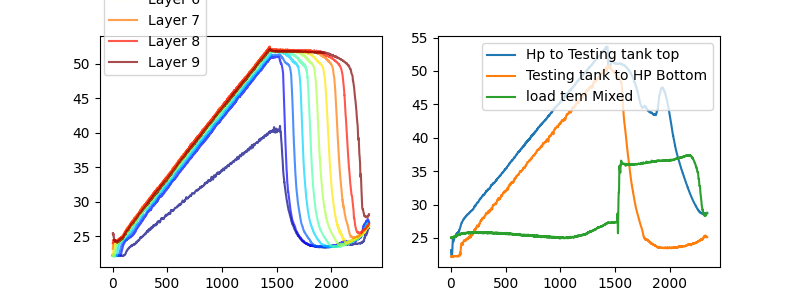

<IPython.core.display.Javascript object>


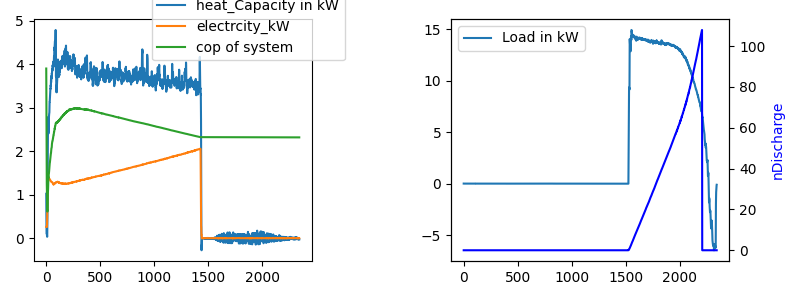

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4320437025055697 0.008969894785503097 941.975613638045
result is ((3358, datetime.datetime(2021, 3, 12, 9, 51, 43), 22.7584, 23.164, 22.2176, 20.2916, 22.8598, 25.4299, 25.0578, 19.4135, 22.4204, 22.1162, 22.1838, 22.15, 22.2852, 22.15, 25.3623, 23.9755, 23.164, 22.3866, 22.15),)
electricity in khW is: 0.00014597944444444446
cop is: 3.898039555073954
Load in kWh is: 4.059264345726709e-06
heat addition in kwh is: 0.0005690336486721653
Index([0], dtype='object')
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4460441297647022 0.009057589287596004 958.5096372758104
result is ((3360, datetime.datetime(2021, 3, 12, 9, 51, 47), 22.7584, 22.7584, 22.2514, 20.2916, 22.7584, 25.4637, 24.9902, 19.6161, 22.4204, 22.0824, 22.1838, 22.15, 22.2514, 22.1162, 25.2608, 24.077, 23.43

RangeIndex(start=0, stop=13, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4660447401348917 0.00918286714772873 982.1296710440471
result is ((3388, datetime.datetime(2021, 3, 12, 9, 52, 35), 22.7584, 23.5021, 22.2176, 19.7174, 22.7584, 25.4299, 25.0578, 18.5018, 22.3866, 22.0486, 22.15, 22.15, 22.2514, 22.1162, 24.4828, 24.4152, 24.2461, 23.8741, 22.15),)
electricity in khW is: 0.0072468
cop is: 0.8123055631727948
Load in kWh is: 6.500966316645423e-05
heat addition in kwh is: 0.005886615955200609
RangeIndex(start=0, stop=14, step=1)
________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  1.4660447401348917 0.00918286714772873 982.1296710440471
result is ((3391, datetime.datetime(2021, 3, 12, 9, 52, 40), 22.7246, 23.9417, 22.2514, 19.6837, 22.826, 25

RangeIndex(start=0, stop=26, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.462044618060854 0.009157811575702186 977.4056642904
result is ((3417, datetime.datetime(2021, 3, 12, 9, 53, 25), 22.7246, 24.7534, 22.2514, 19.4135, 22.7922, 25.4299, 25.1255, 17.8604, 22.4204, 22.826, 22.2176, 22.1162, 22.2514, 22.15, 24.3137, 24.3813, 24.3137, 24.0432, 23.5359),)
electricity in khW is: 0.026359797222222228
cop is: 1.5515683616551137
Load in kWh is: 0.00013443241759486966
heat addition in kwh is: 0.040899027389644356
RangeIndex(start=0, stop=27, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4640446790978727 0.009170339361715458 979.7676676672235
result is ((3419, datetime.datetime(2021, 3, 12, 9, 53, 28), 22.7584, 24.7534, 22.2176, 19.41

RangeIndex(start=0, stop=39, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((3447, datetime.datetime(2021, 3, 12, 9, 54, 16), 22.7584, 25.2946, 22.2514, 19.2784, 22.7584, 25.3961, 25.2608, 17.3879, 22.3528, 23.6712, 22.2176, 22.15, 22.2176, 22.1162, 24.077, 24.3137, 24.2799, 23.9755, 23.9079),)
electricity in khW is: 0.045866380555555565
cop is: 1.8636430340308807
Load in kWh is: 0.0001803230868408809
heat addition in kwh is: 0.08547856061857056
RangeIndex(start=0, stop=40, step=1)
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4660447401348917 0.00918286714772873 982.1296710440471
result is ((3449, datetime.datetime(2021, 3, 12, 9, 54, 20), 22.7246, 25.2946, 22.2514, 19.

RangeIndex(start=0, stop=52, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.462044618060854 0.009157811575702186 977.4056642904
result is ((3478, datetime.datetime(2021, 3, 12, 9, 55, 10), 22.7584, 25.6329, 22.2514, 19.0758, 22.7922, 25.2608, 25.3961, 17.0504, 22.3528, 23.9755, 23.4345, 22.1838, 22.2514, 22.15, 24.2461, 24.4828, 24.449, 24.2122, 24.1446),)
electricity in khW is: 0.065043825
cop is: 2.1511038543577023
Load in kWh is: 0.00023965653501970395
heat addition in kwh is: 0.13991602265966788
RangeIndex(start=0, stop=53, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4640446790978727 0.009170339361715458 979.7676676672235
result is ((3481, datetime.datetime(2021, 3, 12, 9, 55, 15), 22.7584, 25.5991, 22.2514, 19.0758, 22.826

RangeIndex(start=0, stop=65, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((3508, datetime.datetime(2021, 3, 12, 9, 56, 1), 22.7584, 25.8359, 22.2514, 18.907, 22.7584, 25.2269, 25.5314, 16.713, 22.3528, 24.077, 24.0093, 22.8598, 22.2514, 22.15, 24.3813, 24.7196, 24.6519, 24.4152, 24.3475),)
electricity in khW is: 0.083426825
cop is: 2.3402800428294497
Load in kWh is: 0.00030833251473358673
heat addition in kwh is: 0.195242133584125
RangeIndex(start=0, stop=66, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((3510, datetime.datetime(2021, 3, 12, 9, 56, 5), 22.7584, 25.8021, 22.2514, 18.907, 22.7922, 

RangeIndex(start=0, stop=78, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((3537, datetime.datetime(2021, 3, 12, 9, 56, 51), 22.7584, 26.2081, 22.319, 18.7382, 22.7584, 25.1255, 25.5652, 16.4768, 22.319, 24.2461, 24.2122, 23.6374, 22.6232, 22.15, 24.6181, 24.8548, 24.821, 24.4828, 24.4828),)
electricity in khW is: 0.1003797222222222
cop is: 2.522965664327029
Load in kWh is: 0.0003658702494089093
heat addition in kwh is: 0.25325459256135147
RangeIndex(start=0, stop=79, step=1)
________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  1.4660447401348917 0.00918286714772873 982.1296710440471
result is ((3539, datetime.datetime(2021, 3, 12, 9, 56, 54), 22.7584, 26.2758, 22.319, 18.7044, 22.

RangeIndex(start=0, stop=91, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((3567, datetime.datetime(2021, 3, 12, 9, 57, 43), 22.7584, 26.9865, 23.6036, 18.4681, 22.7922, 25.0916, 25.5991, 16.2406, 22.2852, 24.5504, 24.449, 23.9755, 23.4683, 22.15, 24.6857, 24.9225, 25.0916, 24.7872, 24.6519),)
electricity in khW is: 0.11876711944444442
cop is: 2.6573605371557294
Load in kWh is: 0.0004174848209894279
heat addition in kwh is: 0.3156070563233275
RangeIndex(start=0, stop=92, step=1)
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((3570, datetime.datetime(2021, 3, 12, 9, 57, 48), 22.7584, 27.0203, 23.8064, 18.468

RangeIndex(start=0, stop=104, step=1)
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((3597, datetime.datetime(2021, 3, 12, 9, 58, 34), 22.7584, 27.4604, 24.077, 18.2318, 22.826, 25.0578, 25.6329, 15.9707, 22.2852, 24.7534, 24.6519, 24.2799, 23.9755, 22.2176, 25.0916, 25.3284, 25.4299, 25.0916, 24.9225),)
electricity in khW is: 0.13743130833333328
cop is: 2.662849630503415
Load in kWh is: 0.0004836476336339509
heat addition in kwh is: 0.3659589086150174
RangeIndex(start=0, stop=105, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((3599, datetime.datetime(2021, 3, 12, 9, 58, 38), 22.7246, 27.4604, 24.0432, 18.2

RangeIndex(start=0, stop=117, step=1)
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4660447401348917 0.00918286714772873 982.1296710440471
result is ((3628, datetime.datetime(2021, 3, 12, 9, 59, 27), 22.7584, 27.7989, 24.5166, 17.9617, 22.7922, 25.0578, 25.7344, 15.5997, 22.3866, 24.9563, 24.821, 24.4152, 24.3137, 22.4204, 25.3623, 25.6329, 25.7344, 25.4299, 25.2269),)
electricity in khW is: 0.1567873416666666
cop is: 2.7003188995489875
Load in kWh is: 0.0005577240232399229
heat addition in kwh is: 0.4233758219125443
RangeIndex(start=0, stop=118, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((3630, datetime.datetime(2021, 3, 12, 9, 59, 31), 22.7922, 27.8666, 24.5843, 17.9

RangeIndex(start=0, stop=130, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4660447401348917 0.00918286714772873 982.1296710440471
result is ((3659, datetime.datetime(2021, 3, 12, 10, 0, 21), 22.7584, 28.0697, 24.5504, 17.7592, 22.7922, 25.024, 25.7344, 15.2961, 22.6232, 25.3284, 24.9902, 24.7196, 24.4828, 22.8936, 25.7682, 26.0051, 26.1066, 25.6667, 25.5314),)
electricity in khW is: 0.17555211388888878
cop is: 2.740268464287534
Load in kWh is: 0.0006109754019174132
heat addition in kwh is: 0.48105992152873556
RangeIndex(start=0, stop=131, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((3662, datetime.datetime(2021, 3, 12, 10, 0, 26), 22.7584, 28.1374, 24.5504, 17.

RangeIndex(start=0, stop=143, step=1)
________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((3689, datetime.datetime(2021, 3, 12, 10, 1, 12), 22.7246, 28.3406, 24.8887, 17.5567, 22.7922, 25.024, 25.7344, 14.9588, 22.8598, 25.4637, 25.2946, 24.8887, 24.6519, 23.1979, 25.9036, 26.3435, 26.3773, 26.1066, 25.8021),)
electricity in khW is: 0.19348843888888878
cop is: 2.780304148122892
Load in kWh is: 0.0006608603532433953
heat addition in kwh is: 0.5379567092566001
RangeIndex(start=0, stop=144, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4640446790978727 0.009170339361715458 979.7676676672235
result is ((3692, datetime.datetime(2021, 3, 12, 10, 1, 17), 22.7246, 28.4083, 24.8548, 17.

RangeIndex(start=0, stop=156, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((3719, datetime.datetime(2021, 3, 12, 10, 2, 4), 22.7246, 28.5776, 24.9225, 17.2529, 22.7584, 25.1593, 25.7682, 14.5879, 23.0626, 25.8359, 25.4976, 25.0578, 24.7872, 23.4345, 26.3096, 26.5803, 26.648, 26.3773, 26.1743),)
electricity in khW is: 0.21131683611111104
cop is: 2.825951207441163
Load in kWh is: 0.0007031723679367919
heat addition in kwh is: 0.5971710681608405
RangeIndex(start=0, stop=157, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4640446790978727 0.009170339361715458 979.7676676672235
result is ((3721, datetime.datetime(2021, 3, 12, 10, 2, 7), 22.7246, 28.5776, 24.9225, 17.2

RangeIndex(start=0, stop=169, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4640446790978727 0.009170339361715458 979.7676676672235
result is ((3749, datetime.datetime(2021, 3, 12, 10, 2, 55), 22.7584, 28.7808, 25.0916, 17.0167, 22.8598, 25.2269, 25.8359, 14.2844, 23.2655, 26.1066, 25.7682, 25.2608, 24.9225, 23.6036, 26.648, 26.9526, 26.9526, 26.7834, 26.5127),)
electricity in khW is: 0.2290786527777777
cop is: 2.862059555547889
Load in kWh is: 0.0007559090212573404
heat addition in kwh is: 0.6556367471546756
RangeIndex(start=0, stop=170, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((3751, datetime.datetime(2021, 3, 12, 10, 2, 58), 22.7584, 28.7808, 24.9902, 17.

RangeIndex(start=0, stop=182, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((3777, datetime.datetime(2021, 3, 12, 10, 3, 43), 22.7584, 29.0179, 25.1255, 16.848, 22.7584, 25.4299, 25.7344, 14.0147, 23.4345, 26.3435, 26.0389, 25.5652, 25.1255, 23.705, 26.8172, 27.1219, 27.2573, 26.7496, 26.7496),)
electricity in khW is: 0.24614083888888877
cop is: 2.886415892097661
Load in kWh is: 0.0007959790464899211
heat addition in kwh is: 0.7104648290631386
RangeIndex(start=0, stop=183, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((3779, datetime.datetime(2021, 3, 12, 10, 3, 46), 22.7922, 29.0179, 25.1255, 16.

RangeIndex(start=0, stop=195, step=1)
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((3806, datetime.datetime(2021, 3, 12, 10, 4, 33), 22.7584, 29.1872, 25.5652, 16.6455, 22.7584, 25.5991, 25.7682, 13.7449, 23.6374, 26.6819, 26.445, 25.8359, 25.3961, 23.8403, 27.0542, 27.4942, 27.5281, 27.2573, 27.1557),)
electricity in khW is: 0.2635660416666666
cop is: 2.914464464686736
Load in kWh is: 0.0008382483231292223
heat addition in kwh is: 0.7681538625356433
RangeIndex(start=0, stop=196, step=1)
________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  1.4660447401348917 0.00918286714772873 982.1296710440471
result is ((3809, datetime.datetime(2021, 3, 12, 10, 4, 38), 22.7922, 29.2211, 25.4299, 16.611

RangeIndex(start=0, stop=208, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4660447401348917 0.00918286714772873 982.1296710440471
result is ((3835, datetime.datetime(2021, 3, 12, 10, 5, 23), 22.7584, 29.4581, 25.8021, 16.3418, 22.7922, 25.8359, 25.8359, 13.4415, 23.8064, 26.9865, 26.6819, 26.1743, 25.6667, 23.9079, 27.3927, 27.6635, 27.6635, 27.3927, 27.2573),)
electricity in khW is: 0.28105309166666653
cop is: 2.933002723431343
Load in kWh is: 0.0008959602574343565
heat addition in kwh is: 0.8243294832871318
RangeIndex(start=0, stop=209, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((3838, datetime.datetime(2021, 3, 12, 10, 5, 28), 22.7584, 29.492, 25.8021, 16.3

RangeIndex(start=0, stop=221, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((3871, datetime.datetime(2021, 3, 12, 10, 6, 25), 22.7584, 29.8646, 26.1743, 16.0719, 22.7922, 26.0051, 25.8021, 13.1044, 24.077, 27.325, 27.0203, 26.5127, 26.0728, 24.1784, 27.6296, 27.9682, 28.0697, 27.765, 27.4604),)
electricity in khW is: 0.30285229166666655
cop is: 2.9533658617731215
Load in kWh is: 0.0009251059030106738
heat addition in kwh is: 0.8944336193680894
RangeIndex(start=0, stop=222, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4640446790978727 0.009170339361715458 979.7676676672235
result is ((3874, datetime.datetime(2021, 3, 12, 10, 6, 30), 22.7922, 29.7969, 26.1404, 16.

RangeIndex(start=0, stop=234, step=1)
________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((3902, datetime.datetime(2021, 3, 12, 10, 7, 18), 22.7584, 30.1356, 26.648, 15.8358, 22.7922, 26.2758, 25.7682, 12.8011, 24.2799, 27.6296, 27.5281, 26.7496, 26.3773, 24.3813, 27.9343, 28.2729, 28.3067, 28.0359, 27.8666),)
electricity in khW is: 0.3216253694444443
cop is: 2.964209336362003
Load in kWh is: 0.0009847975748494555
heat addition in kwh is: 0.9533649229181004
RangeIndex(start=0, stop=235, step=1)
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4640446790978727 0.009170339361715458 979.7676676672235
result is ((3904, datetime.datetime(2021, 3, 12, 10, 7, 21), 22.7246, 30.1695, 26.6142, 15.80

Load in kWh is: 0.001013792475993652
heat addition in kwh is: 1.0089290952258911
RangeIndex(start=0, stop=247, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((3935, datetime.datetime(2021, 3, 12, 10, 8, 14), 22.7584, 30.3389, 26.7496, 15.5997, 22.7922, 26.445, 25.8359, 12.5652, 24.6181, 28.0359, 27.5958, 27.0542, 26.7157, 24.6181, 28.2729, 28.5776, 28.5099, 28.3744, 28.0697),)
electricity in khW is: 0.34157182222222204
cop is: 2.9703310995070193
Load in kWh is: 0.0010153454619312194
heat addition in kwh is: 1.014581406261949
RangeIndex(start=0, stop=248, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is 

RangeIndex(start=0, stop=260, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((3966, datetime.datetime(2021, 3, 12, 10, 9, 8), 22.7922, 30.6777, 27.1896, 15.3973, 22.7922, 26.6819, 25.8359, 12.3293, 24.8887, 28.1036, 27.9682, 27.325, 26.9865, 24.8548, 28.476, 28.8147, 28.8824, 28.5438, 28.3067),)
electricity in khW is: 0.3605769055555555
cop is: 2.984239857336427
Load in kWh is: 0.0010593785549439883
heat addition in kwh is: 1.0760479731939212
RangeIndex(start=0, stop=261, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((3968, datetime.datetime(2021, 3, 12, 10, 9, 11), 22.7584, 30.7116, 27.1219, 15.363

RangeIndex(start=0, stop=273, step=1)
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((3997, datetime.datetime(2021, 3, 12, 10, 10, 1), 22.7584, 30.9149, 27.5619, 15.1275, 22.7922, 26.9188, 25.8021, 12.0934, 25.1931, 28.5438, 28.1713, 27.7312, 27.2911, 24.9902, 28.7808, 29.0856, 29.2888, 28.984, 28.7469),)
electricity in khW is: 0.3800764722222223
cop is: 2.984612769298479
Load in kWh is: 0.001098008339869411
heat addition in kwh is: 1.1343810923043633
RangeIndex(start=0, stop=274, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((4000, datetime.datetime(2021, 3, 12, 10, 10, 6), 22.7584, 30.9488, 27.5619, 15.12

RangeIndex(start=0, stop=286, step=1)
________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((4028, datetime.datetime(2021, 3, 12, 10, 10, 54), 22.7922, 31.2538, 28.002, 14.8914, 22.7922, 27.1896, 25.7344, 11.7565, 25.5314, 28.8485, 28.6115, 28.002, 27.6296, 25.1255, 29.0517, 29.3227, 29.4581, 29.1533, 28.9501),)
electricity in khW is: 0.3993432750000001
cop is: 2.9814115123633256
Load in kWh is: 0.0011289849000535462
heat addition in kwh is: 1.1906066374698738
RangeIndex(start=0, stop=287, step=1)
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((4030, datetime.datetime(2021, 3, 12, 10, 10, 58), 22.7922, 31.2877, 27.9682, 1

RangeIndex(start=0, stop=299, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((4056, datetime.datetime(2021, 3, 12, 10, 11, 42), 22.7922, 31.4232, 27.9682, 14.6553, 22.7922, 27.3927, 25.7682, 11.5543, 25.7682, 28.9163, 28.7808, 28.1374, 27.8666, 25.2946, 29.2888, 29.6275, 29.6275, 29.3227, 29.1195),)
electricity in khW is: 0.416902263888889
cop is: 2.9790847813859136
Load in kWh is: 0.0011588268216364836
heat addition in kwh is: 1.2419871896767234
RangeIndex(start=0, stop=300, step=1)
________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((4059, datetime.datetime(2021, 3, 12, 10, 11, 47), 22.7246, 31.4232, 28.002, 14

RangeIndex(start=0, stop=312, step=1)
________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((4087, datetime.datetime(2021, 3, 12, 10, 12, 35), 22.7922, 31.7283, 28.3744, 14.453, 22.7584, 27.6296, 25.7682, 11.3522, 26.0389, 29.1533, 28.9501, 28.476, 28.239, 25.7006, 29.5259, 29.8307, 29.8985, 29.6614, 29.6275),)
electricity in khW is: 0.436749288888889
cop is: 2.9733838819228198
Load in kWh is: 0.0012015831416736986
heat addition in kwh is: 1.2986232960234758
RangeIndex(start=0, stop=313, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4660447401348917 0.00918286714772873 982.1296710440471
result is ((4090, datetime.datetime(2021, 3, 12, 10, 12, 41), 22.7584, 31.6944, 28.3744, 14.45

RangeIndex(start=0, stop=325, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4660447401348917 0.00918286714772873 982.1296710440471
result is ((4119, datetime.datetime(2021, 3, 12, 10, 13, 30), 22.7922, 32.0333, 28.7131, 14.3855, 22.7922, 27.9343, 25.8021, 11.2511, 26.3096, 29.6275, 29.2211, 28.8147, 28.5438, 25.8021, 29.7291, 30.034, 30.0679, 29.8646, 29.7291),)
electricity in khW is: 0.45677329722222226
cop is: 2.9691125436944206
Load in kWh is: 0.001216503486591221
heat addition in kwh is: 1.35621132640716
RangeIndex(start=0, stop=326, step=1)
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((4121, datetime.datetime(2021, 3, 12, 10, 13, 34), 22.7584, 32.0333, 28.7469, 14.

RangeIndex(start=0, stop=338, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((4148, datetime.datetime(2021, 3, 12, 10, 14, 20), 22.7584, 32.2028, 28.8147, 14.2844, 22.826, 28.1713, 25.7682, 11.1837, 26.6142, 29.8307, 29.6953, 29.0517, 28.7131, 25.8697, 30.1356, 30.3728, 30.4067, 30.2373, 30.1018),)
electricity in khW is: 0.47578688611111103
cop is: 2.962212180170666
Load in kWh is: 0.0012464639446253664
heat addition in kwh is: 1.4093817092038066
RangeIndex(start=0, stop=339, step=1)
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((4151, datetime.datetime(2021, 3, 12, 10, 14, 25), 22.7584, 32.2367, 28.8824, 14

RangeIndex(start=0, stop=351, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((4179, datetime.datetime(2021, 3, 12, 10, 15, 14), 22.7584, 32.3384, 28.8824, 14.1832, 22.7922, 28.3744, 25.7006, 10.9142, 26.8849, 30.0679, 29.8646, 29.2888, 28.9163, 26.1743, 30.3728, 30.7455, 30.7455, 30.4067, 30.034),)
electricity in khW is: 0.49519797777777763
cop is: 2.9622987217894514
Load in kWh is: 0.001279745297427887
heat addition in kwh is: 1.4669243366038318
RangeIndex(start=0, stop=352, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((4181, datetime.datetime(2021, 3, 12, 10, 15, 17), 22.7584, 32.4062, 28.9163, 1

RangeIndex(start=0, stop=364, step=1)
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((4210, datetime.datetime(2021, 3, 12, 10, 16, 7), 22.7584, 32.8131, 29.1533, 14.1832, 22.8598, 28.6792, 25.7006, 10.8805, 27.1896, 30.3389, 29.8985, 29.6275, 29.3227, 26.2758, 30.6777, 30.9488, 31.0166, 30.6438, 30.5761),)
electricity in khW is: 0.5151312055555555
cop is: 2.9605078533199345
Load in kWh is: 0.001308700373586415
heat addition in kwh is: 1.5250499795373875
RangeIndex(start=0, stop=365, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((4212, datetime.datetime(2021, 3, 12, 10, 16, 10), 22.7584, 32.7452, 29.2549, 14

RangeIndex(start=0, stop=377, step=1)
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((4239, datetime.datetime(2021, 3, 12, 10, 16, 57), 22.7584, 32.9487, 29.2549, 14.1158, 22.8936, 28.9501, 25.8021, 10.8469, 27.4265, 30.5761, 30.0679, 29.7969, 29.4581, 26.5127, 30.8471, 31.2199, 31.2199, 30.9488, 30.5761),)
electricity in khW is: 0.5344817611111112
cop is: 2.9568272518483028
Load in kWh is: 0.0013409959756946423
heat addition in kwh is: 1.580370236869208
RangeIndex(start=0, stop=378, step=1)
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((4241, datetime.datetime(2021, 3, 12, 10, 17), 22.7584, 32.9826, 29.3565, 14.0

RangeIndex(start=0, stop=390, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((4272, datetime.datetime(2021, 3, 12, 10, 17, 53), 22.7584, 33.186, 29.8985, 14.0821, 22.826, 29.1872, 25.7006, 10.9142, 27.7312, 30.8471, 30.4744, 30.0001, 29.7969, 26.6819, 31.2199, 31.5249, 31.5588, 31.2199, 31.0843),)
electricity in khW is: 0.5554515472222223
cop is: 2.9507930171900916
Load in kWh is: 0.0013892761675801874
heat addition in kwh is: 1.639022546930766
RangeIndex(start=0, stop=391, step=1)
________________________________________________________________
flow rates load is =  0.6280191656239509 0.003939400110550439 -1.0440182043749497
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((4274, datetime.datetime(2021, 3, 12, 10, 17, 57), 22.7584, 33.186, 29.9324, 14.1

RangeIndex(start=0, stop=403, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((4302, datetime.datetime(2021, 3, 12, 10, 18, 45), 22.7584, 33.3895, 30.1356, 14.0821, 22.826, 29.492, 25.7006, 10.8132, 28.002, 31.0166, 30.8471, 30.305, 29.9662, 26.7496, 31.2538, 31.6944, 31.7283, 31.3893, 31.3555),)
electricity in khW is: 0.5757429361111113
cop is: 2.9396613817880515
Load in kWh is: 0.001414721652635854
heat addition in kwh is: 1.692489275123099
RangeIndex(start=0, stop=404, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((4305, datetime.datetime(2021, 3, 12, 10, 18, 50), 22.7584, 33.4573, 30.1695, 14.0484

RangeIndex(start=0, stop=416, step=1)
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((4333, datetime.datetime(2021, 3, 12, 10, 19, 38), 22.7584, 33.6608, 30.305, 14.0147, 22.826, 29.763, 25.7682, 10.7795, 28.239, 31.3893, 31.1182, 30.7116, 30.3389, 27.1219, 31.5249, 31.8977, 31.9994, 31.7622, 31.5588),)
electricity in khW is: 0.5961496500000002
cop is: 2.935353411574158
Load in kWh is: 0.0014352278622172298
heat addition in kwh is: 1.7499099089362409
RangeIndex(start=0, stop=417, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((4335, datetime.datetime(2021, 3, 12, 10, 19, 42), 22.7246, 33.7286, 30.305, 14.0

RangeIndex(start=0, stop=429, step=1)
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((4362, datetime.datetime(2021, 3, 12, 10, 20, 28), 22.7246, 33.966, 30.7116, 14.0484, 22.7584, 29.9662, 25.7006, 10.7458, 28.476, 31.6266, 31.4571, 30.9149, 30.6438, 27.0203, 31.8977, 32.1689, 32.2706, 31.8977, 31.7961),)
electricity in khW is: 0.6159315638888891
cop is: 2.925390844824263
Load in kWh is: 0.0014541453944516814
heat addition in kwh is: 1.801840558038847
RangeIndex(start=0, stop=430, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((4365, datetime.datetime(2021, 3, 12, 10, 20, 33), 22.7246, 33.966, 30.8133, 14.

RangeIndex(start=0, stop=442, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((4393, datetime.datetime(2021, 3, 12, 10, 21, 21), 22.7246, 34.2374, 30.7455, 13.9809, 22.7922, 30.2034, 25.7006, 10.7795, 28.7469, 31.8638, 31.4571, 31.0843, 30.7455, 27.5281, 32.1011, 32.5757, 32.5757, 32.3384, 32.0672),)
electricity in khW is: 0.6362107083333337
cop is: 2.9173052292253523
Load in kWh is: 0.0014706674849157008
heat addition in kwh is: 1.8560208263099998
RangeIndex(start=0, stop=443, step=1)
________________________________________________________________
flow rates load is =  0.6400195318460646 0.004014675271898536 3.6902686728639007
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((4395, datetime.datetime(2021, 3, 12, 10, 21, 24), 22.7246, 34.2374, 30.7794, 1

RangeIndex(start=0, stop=455, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((4424, datetime.datetime(2021, 3, 12, 10, 22, 14), 22.7246, 34.4409, 31.186, 14.0147, 22.7584, 30.5761, 25.6667, 10.7121, 29.0179, 32.2028, 31.7622, 31.3216, 31.0843, 27.5281, 32.3384, 32.8131, 32.7791, 32.5079, 32.3384),)
electricity in khW is: 0.6569664472222226
cop is: 2.910706744564897
Load in kWh is: 0.0015010860627782485
heat addition in kwh is: 1.9122366688825618
RangeIndex(start=0, stop=456, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((4426, datetime.datetime(2021, 3, 12, 10, 22, 18), 22.7246, 34.4409, 31.2199, 1

RangeIndex(start=0, stop=468, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((4454, datetime.datetime(2021, 3, 12, 10, 23, 6), 22.7246, 34.7123, 31.3555, 13.9809, 22.7922, 30.7116, 25.6667, 10.8132, 29.2888, 32.3723, 31.9316, 31.6944, 31.2877, 27.5958, 32.6096, 33.0843, 33.0504, 32.847, 32.6096),)
electricity in khW is: 0.6775003472222227
cop is: 2.901981031196549
Load in kWh is: 0.0015201322472973187
heat addition in kwh is: 1.966093156267966
RangeIndex(start=0, stop=469, step=1)
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((4457, datetime.datetime(2021, 3, 12, 10, 23, 11), 22.7246, 34.7801, 31.4232, 14.0

RangeIndex(start=0, stop=481, step=1)
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((4485, datetime.datetime(2021, 3, 12, 10, 23, 59), 22.7922, 34.9497, 31.7622, 14.0147, 22.826, 30.9827, 25.6667, 10.7458, 29.5598, 32.6435, 32.3045, 31.9994, 31.5588, 27.9343, 33.0165, 33.3217, 33.3895, 33.0165, 32.847),)
electricity in khW is: 0.6985115444444452
cop is: 2.8911921959953686
Load in kWh is: 0.0015483328998195079
heat addition in kwh is: 2.019531126110452
RangeIndex(start=0, stop=482, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((4487, datetime.datetime(2021, 3, 12, 10, 24, 2), 22.7246, 34.9497, 31.83, 13.9809

RangeIndex(start=0, stop=494, step=1)
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((4515, datetime.datetime(2021, 3, 12, 10, 24, 50), 22.7922, 35.2212, 31.9994, 13.9809, 22.7922, 31.2538, 25.7344, 10.6448, 29.7291, 32.9487, 32.4401, 32.1689, 31.7283, 28.0359, 33.1182, 33.4912, 33.5251, 33.3217, 33.1521),)
electricity in khW is: 0.7192008000000011
cop is: 2.8797174902194542
Load in kWh is: 0.0015800517887153915
heat addition in kwh is: 2.071095122739827
RangeIndex(start=0, stop=495, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((4518, datetime.datetime(2021, 3, 12, 10, 24, 56), 22.7922, 35.2551, 31.8977, 

RangeIndex(start=0, stop=507, step=1)
________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((4545, datetime.datetime(2021, 3, 12, 10, 25, 42), 22.7922, 35.4587, 32.2028, 13.9472, 22.7246, 31.5249, 25.5991, 10.6111, 29.9662, 33.0843, 32.8131, 32.4401, 31.9994, 28.1374, 33.4234, 33.7964, 33.8304, 33.4573, 33.3217),)
electricity in khW is: 0.7395887277777788
cop is: 2.8742481592255
Load in kWh is: 0.001624796238963646
heat addition in kwh is: 2.1257615393992104
RangeIndex(start=0, stop=508, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((4547, datetime.datetime(2021, 3, 12, 10, 25, 45), 22.7584, 35.4926, 32.1011, 13.98

RangeIndex(start=0, stop=520, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((4579, datetime.datetime(2021, 3, 12, 10, 26, 40), 22.7584, 35.798, 32.3384, 13.9472, 22.7922, 31.83, 25.7006, 10.6111, 30.2711, 33.3217, 33.1521, 32.6096, 32.3045, 28.2729, 33.7625, 34.1017, 34.1017, 33.8643, 33.6269),)
electricity in khW is: 0.7633435194444455
cop is: 2.8649619962578146
Load in kWh is: 0.0016540585421473378
heat addition in kwh is: 2.1869501732980243
RangeIndex(start=0, stop=521, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((4582, datetime.datetime(2021, 3, 12, 10, 26, 45), 22.7584, 35.798, 32.2367, 13.

RangeIndex(start=0, stop=533, step=1)
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((4612, datetime.datetime(2021, 3, 12, 10, 27, 37), 22.7584, 36.1034, 32.847, 13.9472, 22.7246, 32.0333, 25.6329, 10.5774, 30.6777, 33.6947, 33.2878, 32.9487, 32.6096, 28.7469, 33.966, 34.3052, 34.373, 34.0339, 33.9321),)
electricity in khW is: 0.7856130777777788
cop is: 2.860025581634284
Load in kWh is: 0.001692661365166636
heat addition in kwh is: 2.2468734997108917
RangeIndex(start=0, stop=534, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((4614, datetime.datetime(2021, 3, 12, 10, 27, 41), 22.7584, 36.1713, 32.8809, 13.94

RangeIndex(start=0, stop=546, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((4644, datetime.datetime(2021, 3, 12, 10, 28, 32), 22.6908, 36.375, 33.1182, 13.9472, 22.7922, 32.3384, 25.5652, 10.5437, 30.8471, 34.0339, 33.6608, 33.1521, 32.9487, 28.6792, 34.2713, 34.6783, 34.6783, 34.4409, 34.2713),)
electricity in khW is: 0.8084077527777788
cop is: 2.8503556990430914
Load in kWh is: 0.001717029840996193
heat addition in kwh is: 2.3042496452807604
RangeIndex(start=0, stop=547, step=1)
________________________________________________________________
flow rates load is =  0.6280191656239509 0.003939400110550439 -1.0440182043749497
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((4647, datetime.datetime(2021, 3, 12, 10, 28, 37), 22.7246, 36.375, 33.1182, 13.9

RangeIndex(start=0, stop=559, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((4676, datetime.datetime(2021, 3, 12, 10, 29, 27), 22.6908, 36.6126, 33.3895, 13.9135, 22.7584, 32.6435, 25.6329, 10.5774, 31.186, 34.373, 33.8982, 33.4234, 33.1521, 28.8147, 34.5426, 34.8819, 35.0855, 34.6444, 34.373),)
electricity in khW is: 0.8309411777777788
cop is: 2.840859731932064
Load in kWh is: 0.0017281905090148985
heat addition in kwh is: 2.360587331553094
RangeIndex(start=0, stop=560, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((4679, datetime.datetime(2021, 3, 12, 10, 29, 32), 22.657, 36.6465, 33.3556, 13.913

RangeIndex(start=0, stop=572, step=1)
________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((4706, datetime.datetime(2021, 3, 12, 10, 30, 19), 22.7246, 36.8841, 33.3895, 13.9135, 22.7922, 32.8809, 25.5652, 10.51, 31.491, 34.5766, 34.3391, 33.7964, 33.3556, 29.0856, 34.7801, 35.1872, 35.2551, 34.9497, 34.6444),)
electricity in khW is: 0.8523545000000013
cop is: 2.834884865582875
Load in kWh is: 0.0017653604745017802
heat addition in kwh is: 2.4163268721614624
RangeIndex(start=0, stop=573, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((4708, datetime.datetime(2021, 3, 12, 10, 30, 22), 22.7246, 36.8841, 33.5251, 13.913

RangeIndex(start=0, stop=585, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((4738, datetime.datetime(2021, 3, 12, 10, 31, 14), 22.7246, 37.1217, 33.8304, 13.8798, 22.7584, 33.186, 25.4637, 10.5774, 31.7283, 34.7462, 34.5766, 34.1356, 33.6608, 29.1872, 35.0855, 35.3908, 35.4926, 35.2212, 35.1194),)
electricity in khW is: 0.875120555555557
cop is: 2.826893295536771
Load in kWh is: 0.001791935228090676
heat addition in kwh is: 2.4738724312864186
RangeIndex(start=0, stop=586, step=1)
________________________________________________________________
flow rates load is =  0.6400195318460646 0.004014675271898536 3.6902686728639007
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((4741, datetime.datetime(2021, 3, 12, 10, 31, 19), 22.7246, 37.0878, 33.9321, 13.879

RangeIndex(start=0, stop=598, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((4770, datetime.datetime(2021, 3, 12, 10, 32, 9), 22.7246, 37.4952, 34.2034, 13.8798, 22.826, 33.4573, 25.5314, 10.6111, 31.9994, 35.0515, 34.7123, 34.407, 33.9321, 29.3565, 35.4247, 35.798, 35.7641, 35.5944, 35.1533),)
electricity in khW is: 0.898040155555557
cop is: 2.818301009658166
Load in kWh is: 0.0018215592269529926
heat addition in kwh is: 2.530947477115803
RangeIndex(start=0, stop=599, step=1)
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((4772, datetime.datetime(2021, 3, 12, 10, 32, 12), 22.7584, 37.4952, 34.2713, 13.8798,

RangeIndex(start=0, stop=611, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4780451063570055 0.009258033863808364 996.3016913049889
result is ((4801, datetime.datetime(2021, 3, 12, 10, 33, 2), 22.7922, 37.7329, 34.407, 13.9135, 22.7246, 33.7286, 25.4637, 10.5437, 32.2028, 35.2212, 34.9158, 34.6444, 34.2374, 29.6275, 35.6962, 36.0356, 36.0695, 35.7641, 35.4587),)
electricity in khW is: 0.9202599666666681
cop is: 2.809709514196983
Load in kWh is: 0.0018613987606103475
heat addition in kwh is: 2.585663183877936
RangeIndex(start=0, stop=612, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4780451063570055 0.009258033863808364 996.3016913049889
result is ((4803, datetime.datetime(2021, 3, 12, 10, 33, 5), 22.7584, 37.8008, 34.4748, 13.8

RangeIndex(start=0, stop=624, step=1)
________________________________________________________________
flow rates load is =  0.6400195318460646 0.004014675271898536 3.6902686728639007
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((4832, datetime.datetime(2021, 3, 12, 10, 33, 55), 22.7922, 37.9706, 34.7462, 13.9135, 22.8598, 33.9321, 25.3961, 10.5774, 32.5757, 35.6962, 35.2551, 34.848, 34.5426, 29.6953, 35.9677, 36.2731, 36.2731, 35.9677, 35.7641),)
electricity in khW is: 0.9422236555555568
cop is: 2.80378074379166
Load in kWh is: 0.0019042234269755116
heat addition in kwh is: 2.6417885417916556
RangeIndex(start=0, stop=625, step=1)
________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((4834, datetime.datetime(2021, 3, 12, 10, 33, 59), 22.7584, 38.0045, 34.7462, 13.879

RangeIndex(start=0, stop=637, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((4863, datetime.datetime(2021, 3, 12, 10, 34, 49), 22.7584, 38.2083, 34.9837, 13.8798, 22.826, 34.2374, 25.4637, 10.6111, 32.8809, 35.9338, 35.323, 35.1194, 34.7462, 30.1018, 36.2392, 36.5107, 36.4768, 36.341, 36.341),)
electricity in khW is: 0.9651427138888901
cop is: 2.793461966959962
Load in kWh is: 0.0019474638110763408
heat addition in kwh is: 2.6960894639371347
RangeIndex(start=0, stop=638, step=1)
________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((4865, datetime.datetime(2021, 3, 12, 10, 34, 52), 22.7584, 38.2762, 34.9497, 13.846

RangeIndex(start=0, stop=650, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((4894, datetime.datetime(2021, 3, 12, 10, 35, 42), 22.7584, 38.5139, 35.1194, 13.8461, 22.7922, 34.5087, 25.4299, 10.6111, 33.0843, 36.2731, 35.8998, 35.3569, 35.0176, 29.9324, 36.4428, 36.7823, 36.7483, 36.4768, 36.2731),)
electricity in khW is: 0.9881878055555569
cop is: 2.785269343041873
Load in kWh is: 0.0019770150898275186
heat addition in kwh is: 2.752369199981716
RangeIndex(start=0, stop=651, step=1)
________________________________________________________________
flow rates load is =  0.6280191656239509 0.003939400110550439 -1.0440182043749497
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((4896, datetime.datetime(2021, 3, 12, 10, 35, 45), 22.7922, 38.5139, 35.1533, 13.

RangeIndex(start=0, stop=663, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((4924, datetime.datetime(2021, 3, 12, 10, 36, 33), 22.7922, 38.7517, 35.4247, 13.8461, 22.7922, 34.7801, 25.3961, 10.6111, 33.2538, 36.4768, 36.1374, 35.5605, 35.2551, 30.2034, 36.7144, 37.0538, 37.0199, 36.7144, 36.7144),)
electricity in khW is: 1.0100606250000015
cop is: 2.778263174839256
Load in kWh is: 0.0020052128778558845
heat addition in kwh is: 2.806214238792627
RangeIndex(start=0, stop=664, step=1)
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((4927, datetime.datetime(2021, 3, 12, 10, 36, 39), 22.7922, 38.7517, 35.4926, 13.

RangeIndex(start=0, stop=676, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((4955, datetime.datetime(2021, 3, 12, 10, 37, 27), 22.7584, 38.9894, 35.5944, 13.8798, 22.7922, 35.0515, 25.3961, 10.5437, 33.5251, 36.6804, 36.2731, 35.8319, 35.5605, 30.5761, 37.0538, 37.4273, 37.3594, 37.1896, 36.9181),)
electricity in khW is: 1.0333299750000018
cop is: 2.7703657291578194
Load in kWh is: 0.0020421902561917355
heat addition in kwh is: 2.862701949651511
RangeIndex(start=0, stop=677, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((4957, datetime.datetime(2021, 3, 12, 10, 37, 30), 22.7922, 39.0234, 35.5605, 

RangeIndex(start=0, stop=689, step=1)
________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((4986, datetime.datetime(2021, 3, 12, 10, 38, 20), 22.7922, 39.2612, 35.9338, 13.8461, 22.7584, 35.323, 25.3623, 10.5774, 33.6947, 36.8502, 36.4768, 36.1374, 35.798, 30.5422, 37.2575, 37.631, 37.5631, 37.2915, 37.0199),)
electricity in khW is: 1.0567421750000017
cop is: 2.7625158352987405
Load in kWh is: 0.002067128556316762
heat addition in kwh is: 2.919266992265537
RangeIndex(start=0, stop=690, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((4989, datetime.datetime(2021, 3, 12, 10, 38, 25), 22.7584, 39.3291, 35.9338, 13.81

RangeIndex(start=0, stop=702, step=1)
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((5019, datetime.datetime(2021, 3, 12, 10, 39, 17), 22.7922, 39.5669, 36.341, 13.8461, 22.826, 35.5605, 25.3623, 10.51, 34.0678, 37.2915, 36.9181, 36.4089, 36.1034, 30.7455, 37.4952, 37.7668, 37.9366, 37.6989, 37.5971),)
electricity in khW is: 1.0806873777777792
cop is: 2.7554133109263077
Load in kWh is: 0.002095261970265709
heat addition in kwh is: 2.97774038567894
RangeIndex(start=0, stop=703, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((5021, datetime.datetime(2021, 3, 12, 10, 39, 20), 22.7584, 39.5669, 36.341, 13.7786, 

RangeIndex(start=0, stop=715, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((5049, datetime.datetime(2021, 3, 12, 10, 40, 8), 22.7584, 39.8387, 36.5447, 13.8124, 22.7922, 35.8998, 25.3623, 10.51, 34.3391, 37.4952, 37.0199, 36.7144, 36.3071, 30.881, 37.8347, 38.2762, 38.2422, 37.9027, 37.5971),)
electricity in khW is: 1.1034534250000014
cop is: 2.7460292561955484
Load in kWh is: 0.002125911774646438
heat addition in kwh is: 3.030115387899184
RangeIndex(start=0, stop=716, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((5051, datetime.datetime(2021, 3, 12, 10, 40, 12), 22.7584, 39.8387, 36.5107, 13.77

RangeIndex(start=0, stop=728, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((5078, datetime.datetime(2021, 3, 12, 10, 40, 58), 22.7584, 40.0086, 36.7144, 13.8124, 22.7584, 36.1034, 25.2946, 10.4764, 34.5766, 37.8008, 37.2236, 36.952, 36.5447, 31.2199, 38.1064, 38.3441, 38.412, 38.1404, 37.9366),)
electricity in khW is: 1.1258683000000014
cop is: 2.7371561637528723
Load in kWh is: 0.002153681937838479
heat addition in kwh is: 3.0816773569189717
RangeIndex(start=0, stop=729, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((5081, datetime.datetime(2021, 3, 12, 10, 41, 3), 22.7922, 40.0766, 36.8162, 13.812

RangeIndex(start=0, stop=741, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((5110, datetime.datetime(2021, 3, 12, 10, 41, 53), 22.7922, 40.3484, 37.0538, 13.7786, 22.7922, 36.341, 25.3284, 10.4764, 34.814, 38.0385, 37.5631, 37.1896, 36.8841, 31.186, 38.3441, 38.5479, 38.7177, 38.446, 38.1743),)
electricity in khW is: 1.1497567666666677
cop is: 2.730385545912833
Load in kWh is: 0.0021764003148389247
heat addition in kwh is: 3.139279257022143
RangeIndex(start=0, stop=742, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((5112, datetime.datetime(2021, 3, 12, 10, 41, 57), 22.7584, 40.3484, 37.0878, 13.7786

RangeIndex(start=0, stop=754, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4780451063570055 0.009258033863808364 996.3016913049889
result is ((5139, datetime.datetime(2021, 3, 12, 10, 42, 43), 22.7922, 40.5183, 37.3254, 13.7786, 22.826, 36.5786, 25.2946, 10.4764, 35.1533, 38.2422, 37.8008, 37.4273, 37.1217, 31.491, 38.5819, 38.7856, 38.9555, 38.6837, 38.48),)
electricity in khW is: 1.1719671694444453
cop is: 2.7222918208587346
Load in kWh is: 0.002203631336817109
heat addition in kwh is: 3.1904366396935764
RangeIndex(start=0, stop=755, step=1)
________________________________________________________________
flow rates load is =  0.6280191656239509 0.003939400110550439 -1.0440182043749497
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((5141, datetime.datetime(2021, 3, 12, 10, 42, 47), 22.7922, 40.5863, 37.3254, 13.744

Load in kWh is: 0.0022218842798893733
heat addition in kwh is: 3.242611184599696
RangeIndex(start=0, stop=767, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((5171, datetime.datetime(2021, 3, 12, 10, 43, 38), 22.7584, 40.8242, 37.4952, 13.7449, 22.8598, 36.8841, 25.3284, 10.4764, 35.4587, 38.5139, 38.1064, 37.7668, 37.2915, 31.6605, 38.8536, 39.2272, 39.2272, 38.9555, 38.8196),)
electricity in khW is: 1.1965315972222235
cop is: 2.714421611452611
Load in kWh is: 0.002223077105145725
heat addition in kwh is: 3.247891226285914
RangeIndex(start=0, stop=768, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is (

RangeIndex(start=0, stop=780, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((5201, datetime.datetime(2021, 3, 12, 10, 44, 30), 22.7922, 41.0281, 37.8008, 13.8124, 22.8598, 37.0878, 25.3284, 10.4764, 35.6623, 38.7856, 38.3781, 38.0045, 37.665, 31.6944, 39.1253, 39.3631, 39.465, 39.1593, 39.0234),)
electricity in khW is: 1.2198719333333343
cop is: 2.706673310284263
Load in kWh is: 0.0022532462548870242
heat addition in kwh is: 3.3017948039182
RangeIndex(start=0, stop=781, step=1)
________________________________________________________________
flow rates load is =  0.6280191656239509 0.003939400110550439 -1.0440182043749497
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((5204, datetime.datetime(2021, 3, 12, 10, 44, 35), 22.7922, 41.0621, 37.8687, 13.744

RangeIndex(start=0, stop=793, step=1)
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((5231, datetime.datetime(2021, 3, 12, 10, 45, 22), 22.7584, 41.368, 38.1404, 13.7112, 22.826, 37.4273, 25.2269, 10.4764, 35.8659, 39.0913, 38.5819, 38.2083, 37.8687, 31.8977, 39.3291, 39.6349, 39.7368, 39.499, 39.2272),)
electricity in khW is: 1.2433488833333344
cop is: 2.697665329578637
Load in kWh is: 0.002274048662706339
heat addition in kwh is: 3.35413917513865
RangeIndex(start=0, stop=794, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4780451063570055 0.009258033863808364 996.3016913049889
result is ((5234, datetime.datetime(2021, 3, 12, 10, 45, 27), 22.7922, 41.368, 38.1743, 13.7449

Load in kWh is: 0.0023038515853689733
heat addition in kwh is: 3.4045125011531137
RangeIndex(start=0, stop=806, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((5262, datetime.datetime(2021, 3, 12, 10, 46, 15), 22.7584, 41.64, 38.2762, 13.7449, 22.7584, 37.665, 25.2269, 10.4764, 36.1374, 39.3291, 38.8196, 38.5139, 38.2422, 32.0333, 39.499, 39.8727, 39.9746, 39.7028, 39.533),)
electricity in khW is: 1.267423561111112
cop is: 2.689535523408671
Load in kWh is: 0.002306382602162112
heat addition in kwh is: 3.408780690813456
RangeIndex(start=0, stop=807, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((526

RangeIndex(start=0, stop=819, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((5292, datetime.datetime(2021, 3, 12, 10, 47, 6), 22.7584, 41.8439, 38.6498, 13.7449, 22.826, 37.9027, 25.2946, 10.5437, 36.375, 39.533, 39.0574, 38.7856, 38.412, 32.2028, 39.9407, 40.2465, 40.2805, 40.0086, 39.7708),)
electricity in khW is: 1.2907026166666677
cop is: 2.682660501170245
Load in kWh is: 0.002339333880756644
heat addition in kwh is: 3.46251692848875
RangeIndex(start=0, stop=820, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((5294, datetime.datetime(2021, 3, 12, 10, 47, 10), 22.7584, 41.9119, 38.6498, 13.7449,

RangeIndex(start=0, stop=832, step=1)
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((5322, datetime.datetime(2021, 3, 12, 10, 47, 58), 22.7922, 42.1159, 38.7856, 13.7112, 22.8936, 38.1064, 25.2608, 10.4764, 36.6804, 39.7708, 39.3971, 38.9894, 38.6498, 32.3723, 40.1445, 40.4504, 40.5183, 40.2805, 40.0766),)
electricity in khW is: 1.3140820750000013
cop is: 2.6765059890691556
Load in kWh is: 0.002374136214750049
heat addition in kwh is: 3.5171485438659267
RangeIndex(start=0, stop=833, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((5324, datetime.datetime(2021, 3, 12, 10, 48, 1), 22.7922, 42.1159, 38.7856, 13.71

RangeIndex(start=0, stop=845, step=1)
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((5351, datetime.datetime(2021, 3, 12, 10, 48, 48), 22.7584, 42.3199, 39.1593, 13.7112, 22.7584, 38.3441, 25.2608, 10.4427, 37.0199, 40.0086, 39.6349, 39.2952, 38.8536, 32.6774, 40.3824, 40.6543, 40.8242, 40.4843, 40.3144),)
electricity in khW is: 1.3375737805555568
cop is: 2.667967231737621
Load in kWh is: 0.0024016299599467447
heat addition in kwh is: 3.568603016553633
RangeIndex(start=0, stop=846, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((5353, datetime.datetime(2021, 3, 12, 10, 48, 51), 22.7922, 42.3879, 39.1593, 1

RangeIndex(start=0, stop=858, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((5381, datetime.datetime(2021, 3, 12, 10, 49, 39), 22.7584, 42.5919, 39.3291, 13.7112, 22.8598, 38.6158, 25.2608, 10.4764, 37.2236, 40.3824, 39.8727, 39.465, 39.1593, 32.6774, 40.7222, 40.9941, 41.0281, 40.7222, 40.5523),)
electricity in khW is: 1.3616335944444455
cop is: 2.6595410614479618
Load in kWh is: 0.002424349220763994
heat addition in kwh is: 3.621320455071984
RangeIndex(start=0, stop=859, step=1)
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((5384, datetime.datetime(2021, 3, 12, 10, 49, 44), 22.7922, 42.5919, 39.3291, 13.

RangeIndex(start=0, stop=871, step=1)
________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((5412, datetime.datetime(2021, 3, 12, 10, 50, 32), 22.7922, 42.83, 39.5669, 13.7112, 22.8598, 38.9555, 25.1931, 10.4764, 37.4273, 40.4504, 40.0426, 39.7708, 39.465, 33.0504, 40.9601, 41.3, 41.266, 41.0281, 40.8582),)
electricity in khW is: 1.38580606388889
cop is: 2.653243397220783
Load in kWh is: 0.0024474101977673235
heat addition in kwh is: 3.67688078884172
RangeIndex(start=0, stop=872, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((5414, datetime.datetime(2021, 3, 12, 10, 50, 36), 22.7922, 42.83, 39.6009, 13.6775, 22.826,

RangeIndex(start=0, stop=884, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4780451063570055 0.009258033863808364 996.3016913049889
result is ((5443, datetime.datetime(2021, 3, 12, 10, 51, 26), 22.7922, 43.102, 39.8387, 13.7112, 22.7922, 39.1593, 25.1931, 10.4764, 37.665, 40.8582, 40.3144, 40.0766, 39.6689, 33.0504, 41.1641, 41.47, 41.47, 41.3, 41.0621),)
electricity in khW is: 1.4110383194444458
cop is: 2.6455497131467123
Load in kWh is: 0.002478553146922229
heat addition in kwh is: 3.7329720212452724
RangeIndex(start=0, stop=885, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4780451063570055 0.009258033863808364 996.3016913049889
result is ((5445, datetime.datetime(2021, 3, 12, 10, 51, 29), 22.7922, 43.136, 39.8387, 13.6775, 2

RangeIndex(start=0, stop=897, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4800451673940245 0.009270561649821638 998.6636946818128
result is ((5473, datetime.datetime(2021, 3, 12, 10, 52, 17), 22.7922, 43.3401, 40.1445, 13.6775, 22.7584, 39.3631, 25.0578, 10.4427, 37.9027, 41.1301, 40.6543, 40.2805, 39.9067, 33.2199, 41.368, 41.7419, 41.8099, 41.538, 41.368),)
electricity in khW is: 1.4349975861111124
cop is: 2.641022252848524
Load in kWh is: 0.0025093602680353213
heat addition in kwh is: 3.789860557703364
RangeIndex(start=0, stop=898, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((5476, datetime.datetime(2021, 3, 12, 10, 52, 22), 22.7922, 43.3401, 40.2465, 13.7

Load in kWh is: 0.002534834138765726
heat addition in kwh is: 3.8428805468133835
RangeIndex(start=0, stop=910, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((5505, datetime.datetime(2021, 3, 12, 10, 53, 12), 22.7922, 43.6122, 40.2465, 13.7112, 22.8598, 39.533, 25.1593, 10.4427, 38.1404, 41.368, 41.0621, 40.5183, 40.1785, 33.4912, 41.64, 41.9459, 42.0819, 41.8099, 41.538),)
electricity in khW is: 1.460974180555557
cop is: 2.6325366853264147
Load in kWh is: 0.0025365593958368306
heat addition in kwh is: 3.8460681266272005
RangeIndex(start=0, stop=911, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4800451673940245 0.009270561649821638 998.6636946818128
result is ((5

RangeIndex(start=0, stop=923, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((5535, datetime.datetime(2021, 3, 12, 10, 54, 4), 22.7922, 43.8503, 40.6203, 13.7112, 22.7922, 39.8048, 25.0916, 10.4764, 38.412, 41.606, 41.232, 40.8582, 40.5183, 33.4912, 41.9459, 42.2859, 42.2859, 42.0479, 41.8099),)
electricity in khW is: 1.4851662944444457
cop is: 2.6259506800833567
Load in kWh is: 0.0025610960677584778
heat addition in kwh is: 3.8999734409332714
RangeIndex(start=0, stop=924, step=1)
________________________________________________________________
flow rates load is =  0.6400195318460646 0.004014675271898536 3.6902686728639007
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((5537, datetime.datetime(2021, 3, 12, 10, 54, 7), 22.7922, 43.8503, 40.6543, 13.677

RangeIndex(start=0, stop=936, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((5567, datetime.datetime(2021, 3, 12, 10, 54, 59), 22.7922, 44.1905, 40.5183, 13.7112, 22.7922, 40.0086, 25.0916, 10.4427, 38.6837, 41.9119, 41.436, 41.0961, 40.7902, 33.559, 42.2519, 42.5239, 42.5919, 42.2519, 42.0819),)
electricity in khW is: 1.5118920500000013
cop is: 2.617547702304041
Load in kWh is: 0.0026007562286809614
heat addition in kwh is: 3.9574495616092498
RangeIndex(start=0, stop=937, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((5569, datetime.datetime(2021, 3, 12, 10, 55, 2), 22.7922, 44.1905, 40.5523, 13.7

RangeIndex(start=0, stop=949, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4800451673940245 0.009270561649821638 998.6636946818128
result is ((5598, datetime.datetime(2021, 3, 12, 10, 55, 52), 22.7584, 44.4287, 41.266, 13.6775, 22.7922, 40.3484, 25.1255, 10.4764, 38.9215, 42.0819, 41.7419, 41.266, 41.0961, 33.9321, 42.5239, 42.83, 42.898, 42.5919, 42.4559),)
electricity in khW is: 1.537341941666668
cop is: 2.61004102154509
Load in kWh is: 0.002633665019392756
heat addition in kwh is: 4.012525531891782
RangeIndex(start=0, stop=950, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((5600, datetime.datetime(2021, 3, 12, 10, 55, 56), 22.7584, 44.4967, 41.232, 13.7112, 2

RangeIndex(start=0, stop=962, step=1)
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((5627, datetime.datetime(2021, 3, 12, 10, 56, 42), 22.7584, 44.6328, 41.504, 13.6775, 22.7922, 40.6203, 25.0578, 10.51, 39.2272, 42.2859, 41.8779, 41.606, 41.3, 34.1356, 42.762, 43.1701, 43.136, 42.864, 42.796),)
electricity in khW is: 1.5619189861111122
cop is: 2.6008880304884885
Load in kWh is: 0.002656683087113298
heat addition in kwh is: 4.062376395569108
RangeIndex(start=0, stop=963, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((5630, datetime.datetime(2021, 3, 12, 10, 56, 47), 22.7922, 44.7009, 41.538, 13.6775, 22.8

RangeIndex(start=0, stop=975, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((5657, datetime.datetime(2021, 3, 12, 10, 57, 34), 22.7922, 44.905, 41.7419, 13.6775, 22.826, 40.8242, 25.0578, 10.4764, 39.499, 42.4899, 42.2179, 41.8439, 41.504, 34.1017, 43.0, 43.2721, 43.5442, 43.068, 43.136),)
electricity in khW is: 1.5866043944444452
cop is: 2.5933278852987893
Load in kWh is: 0.00268466131130882
heat addition in kwh is: 4.114585419050379
RangeIndex(start=0, stop=976, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((5660, datetime.datetime(2021, 3, 12, 10, 57, 39), 22.7922, 44.905, 41.7079, 13.6775, 22.7

RangeIndex(start=0, stop=988, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((5688, datetime.datetime(2021, 3, 12, 10, 58, 27), 22.7922, 45.1092, 42.0139, 13.6775, 22.8598, 41.0621, 24.9902, 10.51, 39.7708, 42.796, 42.5919, 42.0139, 41.7759, 34.373, 43.2381, 43.5782, 43.6122, 43.3741, 43.1701),)
electricity in khW is: 1.612381727777779
cop is: 2.584952047834414
Load in kWh is: 0.0027075015225476117
heat addition in kwh is: 4.167929449109961
RangeIndex(start=0, stop=989, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((5691, datetime.datetime(2021, 3, 12, 10, 58, 32), 22.7922, 45.1432, 42.0139, 13.6775,

Load in kWh is: 0.002727565666310651
heat addition in kwh is: 4.2162530004309255
RangeIndex(start=0, stop=1001, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4780451063570055 0.009258033863808364 996.3016913049889
result is ((5719, datetime.datetime(2021, 3, 12, 10, 59, 20), 22.7922, 45.4155, 42.2859, 13.6775, 22.7584, 41.402, 24.9563, 10.51, 40.0426, 43.2041, 42.728, 42.2859, 42.1159, 34.4409, 43.5102, 43.8503, 43.8163, 43.5782, 43.4421),)
electricity in khW is: 1.6377849166666678
cop is: 2.5774009160308937
Load in kWh is: 0.0027303643631084217
heat addition in kwh is: 4.22122834447825
RangeIndex(start=0, stop=1002, step=1)
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is (

RangeIndex(start=0, stop=1014, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4800451673940245 0.009270561649821638 998.6636946818128
result is ((5749, datetime.datetime(2021, 3, 12, 11, 0, 12), 22.7922, 45.6197, 42.5919, 13.6438, 22.826, 41.606, 25.024, 10.4764, 40.2805, 43.4762, 43.0, 42.5919, 42.3199, 34.6783, 43.7483, 44.1565, 44.1225, 43.8503, 43.6122),)
electricity in khW is: 1.6633153277777788
cop is: 2.569146275180672
Load in kWh is: 0.0027491679039177846
heat addition in kwh is: 4.273300378811199
RangeIndex(start=0, stop=1015, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((5751, datetime.datetime(2021, 3, 12, 11, 0, 15), 22.7922, 45.6197, 42.6259, 13.6775,

RangeIndex(start=0, stop=1027, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((5779, datetime.datetime(2021, 3, 12, 11, 1, 3), 22.7922, 45.8239, 42.5919, 13.6775, 22.7922, 41.8439, 24.9563, 10.409, 40.4504, 43.6462, 43.1701, 42.932, 42.5239, 34.9158, 43.9864, 44.2926, 44.2926, 44.0885, 43.8503),)
electricity in khW is: 1.688414805555557
cop is: 2.5610793242302607
Load in kWh is: 0.0027685345240816093
heat addition in kwh is: 4.324164249232593
RangeIndex(start=0, stop=1028, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((5781, datetime.datetime(2021, 3, 12, 11, 1, 7), 22.826, 45.892, 42.6259, 13.6775,

RangeIndex(start=0, stop=1040, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((5809, datetime.datetime(2021, 3, 12, 11, 1, 55), 22.7922, 46.1643, 42.932, 13.6438, 22.7584, 42.1499, 25.024, 10.409, 40.7222, 43.8843, 43.3741, 43.136, 42.796, 34.9158, 44.2586, 44.4287, 44.6328, 44.2245, 44.0204),)
electricity in khW is: 1.7141472250000014
cop is: 2.554197948056235
Load in kWh is: 0.0027884946665179735
heat addition in kwh is: 4.378271324761293
RangeIndex(start=0, stop=1041, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((5811, datetime.datetime(2021, 3, 12, 11, 1, 58), 22.7922, 46.1302, 42.932, 13.6775,

RangeIndex(start=0, stop=1053, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((5840, datetime.datetime(2021, 3, 12, 11, 2, 48), 22.826, 46.4366, 43.2721, 13.6775, 22.7584, 42.3539, 24.9902, 10.409, 40.9941, 44.1225, 43.7483, 43.3741, 43.102, 35.2212, 44.3946, 44.9731, 44.939, 44.6668, 44.5307),)
electricity in khW is: 1.7410113250000017
cop is: 2.547060816148555
Load in kWh is: 0.0028062983184585564
heat addition in kwh is: 4.434461726378381
RangeIndex(start=0, stop=1054, step=1)
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((5842, datetime.datetime(2021, 3, 12, 11, 2, 52), 22.826, 46.4707, 43.2721, 13.67

RangeIndex(start=0, stop=1066, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((5871, datetime.datetime(2021, 3, 12, 11, 3, 41), 22.826, 46.709, 43.5782, 13.6775, 22.826, 42.5919, 24.9902, 10.4427, 41.1981, 44.4287, 44.0544, 43.6802, 43.3061, 35.3569, 44.7689, 45.0071, 45.1092, 44.871, 44.5648),)
electricity in khW is: 1.7675065638888907
cop is: 2.538410159113417
Load in kWh is: 0.002833896181503434
heat addition in kwh is: 4.486656618075208
RangeIndex(start=0, stop=1067, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((5873, datetime.datetime(2021, 3, 12, 11, 3, 45), 22.7922, 46.6068, 43.5442, 13.7112

RangeIndex(start=0, stop=1079, step=1)
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((5901, datetime.datetime(2021, 3, 12, 11, 4, 33), 22.7922, 46.8792, 43.8503, 13.7112, 22.826, 42.864, 25.0578, 10.4764, 41.436, 44.6668, 44.2245, 43.9184, 43.5782, 35.4587, 45.0752, 45.5176, 45.3474, 45.1092, 44.905),)
electricity in khW is: 1.7941152277777794
cop is: 2.5293859478657237
Load in kWh is: 0.0028705677002651237
heat addition in kwh is: 4.538009845993027
RangeIndex(start=0, stop=1080, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4800451673940245 0.009270561649821638 998.6636946818128
result is ((5904, datetime.datetime(2021, 3, 12, 11, 4, 38), 22.826, 46.9133, 43.8503, 13.711

RangeIndex(start=0, stop=1092, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((5931, datetime.datetime(2021, 3, 12, 11, 5, 25), 22.826, 47.1516, 44.0204, 13.6775, 22.7922, 43.1701, 25.0916, 10.51, 41.674, 44.905, 44.5648, 44.2245, 43.7823, 35.6623, 45.2453, 45.6537, 45.6197, 45.4155, 45.0752),)
electricity in khW is: 1.819851011111113
cop is: 2.521865395426176
Load in kWh is: 0.002897516179106027
heat addition in kwh is: 4.589419289752453
RangeIndex(start=0, stop=1093, step=1)
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((5934, datetime.datetime(2021, 3, 12, 11, 5, 30), 22.826, 47.1516, 43.9184, 13.6775,

RangeIndex(start=0, stop=1105, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4780451063570055 0.009258033863808364 996.3016913049889
result is ((5962, datetime.datetime(2021, 3, 12, 11, 6, 18), 22.826, 47.39, 44.2586, 13.7112, 22.826, 43.4081, 25.1593, 10.51, 41.9459, 45.2793, 44.871, 44.4287, 44.0885, 35.798, 45.5856, 45.7899, 45.96, 45.6197, 45.4495),)
electricity in khW is: 1.8467207944444466
cop is: 2.5149602098072696
Load in kWh is: 0.002920615241538053
heat addition in kwh is: 4.644429316651453
RangeIndex(start=0, stop=1106, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((5964, datetime.datetime(2021, 3, 12, 11, 6, 21), 22.826, 47.424, 44.2926, 13.7112, 22.8

RangeIndex(start=0, stop=1118, step=1)
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((5992, datetime.datetime(2021, 3, 12, 11, 7, 10), 22.7922, 47.5943, 44.4967, 13.7112, 22.826, 43.7143, 25.0916, 10.5774, 42.2179, 45.4495, 45.2113, 44.6328, 44.3606, 36.1034, 45.8239, 46.1302, 46.1302, 45.8579, 45.6197),)
electricity in khW is: 1.873200483333335
cop is: 2.5063567515900664
Load in kWh is: 0.0029422414691079096
heat addition in kwh is: 4.69490867848428
RangeIndex(start=0, stop=1119, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((5995, datetime.datetime(2021, 3, 12, 11, 7, 15), 22.826, 47.6965, 44.5307, 13.7

RangeIndex(start=0, stop=1131, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((6025, datetime.datetime(2021, 3, 12, 11, 8, 6), 22.826, 47.8667, 44.7689, 13.7449, 22.826, 43.8843, 25.1931, 10.51, 42.4219, 45.6877, 45.3134, 44.9731, 44.6668, 36.0016, 46.1302, 46.5047, 46.4026, 46.0962, 45.96),)
electricity in khW is: 1.9018550444444464
cop is: 2.498196288368816
Load in kWh is: 0.0029653241942295774
heat addition in kwh is: 4.751207213046626
RangeIndex(start=0, stop=1132, step=1)
________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((6027, datetime.datetime(2021, 3, 12, 11, 8, 10), 22.826, 47.9008, 44.7689, 13.7112, 22

RangeIndex(start=0, stop=1144, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((6057, datetime.datetime(2021, 3, 12, 11, 9, 1), 22.826, 48.2073, 45.0411, 13.7449, 22.826, 44.1565, 25.2608, 10.5774, 42.762, 45.96, 45.4495, 45.3474, 44.9731, 36.3071, 46.2664, 46.5728, 46.6749, 46.3004, 46.1643),)
electricity in khW is: 1.9296331527777797
cop is: 2.490569496052654
Load in kWh is: 0.0029968432361075887
heat addition in kwh is: 4.805885468880248
RangeIndex(start=0, stop=1145, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((6060, datetime.datetime(2021, 3, 12, 11, 9, 6), 22.7922, 48.2414, 45.1432, 13.7112, 

RangeIndex(start=0, stop=1157, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((6088, datetime.datetime(2021, 3, 12, 11, 9, 54), 22.7922, 48.4117, 45.3814, 13.7112, 22.826, 44.3606, 25.3284, 10.5437, 43.034, 46.1983, 45.6877, 45.4495, 45.2453, 36.5107, 46.5047, 46.8792, 46.9133, 46.6068, 46.4366),)
electricity in khW is: 1.9575747416666684
cop is: 2.4814314489946865
Load in kWh is: 0.0030247048494777577
heat addition in kwh is: 4.85758752772932
RangeIndex(start=0, stop=1158, step=1)
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((6090, datetime.datetime(2021, 3, 12, 11, 9, 58), 22.826, 48.4117, 45.3814, 13.744

RangeIndex(start=0, stop=1170, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((6119, datetime.datetime(2021, 3, 12, 11, 10, 48), 22.7922, 48.7864, 45.4495, 13.7449, 22.7922, 44.7009, 25.3623, 10.6111, 43.3061, 46.5047, 46.0281, 45.7218, 45.3814, 36.6126, 46.6749, 47.2197, 47.1516, 46.9473, 46.743),)
electricity in khW is: 1.9856591416666682
cop is: 2.474378390857922
Load in kWh is: 0.003057739983458013
heat addition in kwh is: 4.9132720717494935
RangeIndex(start=0, stop=1171, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((6122, datetime.datetime(2021, 3, 12, 11, 10, 53), 22.7922, 48.7864, 45.5856, 

RangeIndex(start=0, stop=1183, step=1)
________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((6150, datetime.datetime(2021, 3, 12, 11, 11, 41), 22.826, 48.8886, 45.6877, 13.7449, 22.826, 44.837, 25.3623, 10.6111, 43.5442, 46.7771, 46.4026, 45.9941, 45.6197, 36.986, 47.0835, 47.2878, 47.424, 47.1856, 46.9813),)
electricity in khW is: 2.013310602777779
cop is: 2.467126714933556
Load in kWh is: 0.0030808366338551116
heat addition in kwh is: 4.967092373572039
RangeIndex(start=0, stop=1184, step=1)
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((6153, datetime.datetime(2021, 3, 12, 11, 11, 46), 22.7922, 48.8886, 45.7218, 13.74

RangeIndex(start=0, stop=1196, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((6181, datetime.datetime(2021, 3, 12, 11, 12, 34), 22.826, 49.1612, 46.0281, 13.7786, 22.826, 45.1092, 25.4299, 10.6111, 43.7823, 47.0835, 46.6068, 46.2664, 45.926, 36.8162, 47.3219, 47.5943, 47.6624, 47.3559, 47.1856),)
electricity in khW is: 2.041621005555557
cop is: 2.45868676668353
Load in kWh is: 0.003104620495078316
heat addition in kwh is: 5.01970654894257
RangeIndex(start=0, stop=1197, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((6184, datetime.datetime(2021, 3, 12, 11, 12, 40), 22.8598, 49.1953, 46.0962, 13.7786,

RangeIndex(start=0, stop=1209, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((6213, datetime.datetime(2021, 3, 12, 11, 13, 29), 22.7922, 49.3997, 46.3685, 13.8124, 22.826, 45.3134, 25.4976, 10.6448, 44.0544, 47.2878, 46.8452, 46.5387, 46.1302, 37.1217, 47.5602, 47.9008, 47.9349, 47.6624, 47.4581),)
electricity in khW is: 2.0705908638888895
cop is: 2.4507828161182177
Load in kWh is: 0.003127733300239189
heat addition in kwh is: 5.074568508430266
RangeIndex(start=0, stop=1210, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((6216, datetime.datetime(2021, 3, 12, 11, 13, 34), 22.826, 49.4338, 46.4026, 1

RangeIndex(start=0, stop=1222, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4780451063570055 0.009258033863808364 996.3016913049889
result is ((6245, datetime.datetime(2021, 3, 12, 11, 14, 24), 22.826, 49.7064, 46.6409, 13.8124, 22.7584, 45.5516, 25.5652, 10.6784, 44.2926, 47.6624, 47.1175, 46.8111, 46.3685, 37.3254, 47.7986, 48.1052, 48.1733, 47.9349, 47.7646),)
electricity in khW is: 2.0986268972222217
cop is: 2.443505716829713
Load in kWh is: 0.0031548943235247327
heat addition in kwh is: 5.128006820855101
RangeIndex(start=0, stop=1223, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((6247, datetime.datetime(2021, 3, 12, 11, 14, 28), 22.826, 49.7064, 46.6749, 13

RangeIndex(start=0, stop=1235, step=1)
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((6276, datetime.datetime(2021, 3, 12, 11, 15, 18), 22.826, 49.9449, 46.8792, 13.8124, 22.7584, 45.8579, 25.5314, 10.6448, 44.5307, 47.7646, 47.2878, 47.0154, 46.6409, 37.5292, 48.003, 48.3776, 48.3776, 48.1733, 47.9689),)
electricity in khW is: 2.127351466666666
cop is: 2.4360281548631506
Load in kWh is: 0.0031783937732728744
heat addition in kwh is: 5.182288068089416
RangeIndex(start=0, stop=1236, step=1)
________________________________________________________________
flow rates load is =  0.6400195318460646 0.004014675271898536 3.6902686728639007
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((6279, datetime.datetime(2021, 3, 12, 11, 15, 23), 22.826, 49.9449, 46.9133, 13.8

RangeIndex(start=0, stop=1248, step=1)
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((6308, datetime.datetime(2021, 3, 12, 11, 16, 13), 22.826, 50.1835, 47.1516, 13.7786, 22.7922, 46.0622, 25.7006, 10.6111, 44.8029, 47.9349, 47.5602, 47.2538, 46.9473, 37.631, 48.3095, 48.6502, 48.7524, 48.4458, 48.2073),)
electricity in khW is: 2.1566668833333322
cop is: 2.42759584432293
Load in kWh is: 0.003206024772567905
heat addition in kwh is: 5.235515563568883
RangeIndex(start=0, stop=1249, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((6310, datetime.datetime(2021, 3, 12, 11, 16, 16), 22.8598, 50.1494, 47.1175, 13.84

RangeIndex(start=0, stop=1261, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((6339, datetime.datetime(2021, 3, 12, 11, 17, 6), 22.8598, 50.5243, 47.39, 13.8461, 22.7922, 46.2664, 25.8697, 10.6111, 45.0411, 48.2755, 47.7986, 47.4921, 47.1856, 37.6989, 48.582, 48.9227, 48.9227, 48.6842, 48.3776),)
electricity in khW is: 2.1850948305555553
cop is: 2.419949179148885
Load in kWh is: 0.003235647469122159
heat addition in kwh is: 5.2878184415653875
RangeIndex(start=0, stop=1262, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((6341, datetime.datetime(2021, 3, 12, 11, 17, 9), 22.8598, 50.4902, 47.424, 13.846

RangeIndex(start=0, stop=1274, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((6371, datetime.datetime(2021, 3, 12, 11, 18, 1), 22.8598, 50.6947, 47.6624, 13.8124, 22.7922, 46.5387, 25.9036, 10.6448, 45.2793, 48.6502, 48.037, 47.8327, 47.4921, 38.2083, 48.7864, 49.1271, 49.1612, 48.9227, 48.7864),)
electricity in khW is: 2.2147094861111105
cop is: 2.4116167926032066
Load in kWh is: 0.003268287641023643
heat addition in kwh is: 5.341030587443172
RangeIndex(start=0, stop=1275, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4800451673940245 0.009270561649821638 998.6636946818128
result is ((6373, datetime.datetime(2021, 3, 12, 11, 18, 4), 22.8598, 50.7288, 47.6965, 13.

RangeIndex(start=0, stop=1287, step=1)
________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((6403, datetime.datetime(2021, 3, 12, 11, 18, 56), 22.826, 50.8993, 47.4921, 13.8798, 22.826, 46.8111, 26.0051, 10.6448, 45.6197, 48.6842, 48.2755, 48.1052, 47.6965, 38.2083, 49.059, 49.3997, 49.4678, 49.1271, 48.9568),)
electricity in khW is: 2.244460599999999
cop is: 2.404555295016105
Load in kWh is: 0.003306603268368421
heat addition in kwh is: 5.3969296201850225
RangeIndex(start=0, stop=1288, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4780451063570055 0.009258033863808364 996.3016913049889
result is ((6405, datetime.datetime(2021, 3, 12, 11, 18, 59), 22.826, 50.8993, 47.5602, 13.879

RangeIndex(start=0, stop=1300, step=1)
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((6434, datetime.datetime(2021, 3, 12, 11, 19, 49), 22.826, 51.2061, 48.037, 13.9135, 22.826, 47.1516, 26.1066, 10.7121, 45.8579, 49.1271, 48.548, 48.2073, 47.9689, 38.2762, 49.2634, 49.6041, 49.7064, 49.4678, 49.2634),)
electricity in khW is: 2.273820044444444
cop is: 2.3977652788259136
Load in kWh is: 0.003328282468740248
heat addition in kwh is: 5.452086752867284
RangeIndex(start=0, stop=1301, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4780451063570055 0.009258033863808364 996.3016913049889
result is ((6436, datetime.datetime(2021, 3, 12, 11, 19, 52), 22.7922, 51.2402, 48.0711, 13.91

RangeIndex(start=0, stop=1313, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((6467, datetime.datetime(2021, 3, 12, 11, 20, 46), 22.8598, 51.4788, 48.3436, 13.9135, 22.7922, 47.4921, 26.1743, 10.7121, 46.0622, 49.3316, 48.8205, 48.548, 48.2755, 38.5139, 49.5701, 49.9108, 50.0472, 49.7405, 49.5019),)
electricity in khW is: 2.3044058055555556
cop is: 2.3899557603553774
Load in kWh is: 0.00335584504385386
heat addition in kwh is: 5.507427929183874
RangeIndex(start=0, stop=1314, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((6469, datetime.datetime(2021, 3, 12, 11, 20, 49), 22.826, 51.5129, 48.3436, 13.9

RangeIndex(start=0, stop=1326, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((6499, datetime.datetime(2021, 3, 12, 11, 21, 41), 22.826, 51.7175, 48.6161, 13.9472, 22.7922, 47.6624, 26.3096, 10.7458, 46.3685, 49.5019, 48.9908, 48.7524, 48.5139, 38.5819, 49.8427, 50.1835, 50.2176, 50.0131, 49.7745),)
electricity in khW is: 2.334596922222223
cop is: 2.3822923323088303
Load in kWh is: 0.003383357797294464
heat addition in kwh is: 5.561692346841796
RangeIndex(start=0, stop=1327, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((6501, datetime.datetime(2021, 3, 12, 11, 21, 44), 22.826, 51.7857, 48.582, 13.9

RangeIndex(start=0, stop=1339, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4800451673940245 0.009270561649821638 998.6636946818128
result is ((6531, datetime.datetime(2021, 3, 12, 11, 22, 36), 22.8598, 51.9221, 48.7524, 13.9472, 22.7922, 47.9689, 26.4788, 10.7795, 46.5728, 49.8768, 49.2293, 48.9908, 48.7524, 38.9894, 50.1153, 50.4561, 50.4561, 50.2516, 50.0131),)
electricity in khW is: 2.3654730527777783
cop is: 2.3743434759524065
Load in kWh is: 0.003406155962432446
heat addition in kwh is: 5.61644551040414
RangeIndex(start=0, stop=1340, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((6533, datetime.datetime(2021, 3, 12, 11, 22, 39), 22.8598, 51.9562, 48.7183, 

RangeIndex(start=0, stop=1352, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((6564, datetime.datetime(2021, 3, 12, 11, 23, 32), 22.8598, 52.1949, 49.093, 13.9472, 22.7922, 48.1392, 26.5803, 10.7458, 46.743, 50.1494, 49.6041, 49.1953, 48.9908, 38.9555, 50.388, 50.6947, 50.7629, 50.4902, 50.3539),)
electricity in khW is: 2.3970689916666674
cop is: 2.366237216485045
Load in kWh is: 0.0034315471229775965
heat addition in kwh is: 5.672033858563949
RangeIndex(start=0, stop=1353, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4800451673940245 0.009270561649821638 998.6636946818128
result is ((6567, datetime.datetime(2021, 3, 12, 11, 23, 37), 22.8598, 52.1608, 49.093, 13.

RangeIndex(start=0, stop=1365, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((6596, datetime.datetime(2021, 3, 12, 11, 24, 27), 22.8598, 52.3995, 49.2634, 13.9809, 22.8598, 48.4117, 26.648, 10.8132, 47.0835, 50.3198, 50.0131, 49.536, 49.1953, 39.0913, 50.5925, 50.9334, 51.0015, 50.7288, 50.6607),)
electricity in khW is: 2.4271068527777784
cop is: 2.3592837672292397
Load in kWh is: 0.003468470981394805
heat addition in kwh is: 5.726233799089461
RangeIndex(start=0, stop=1366, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4800451673940245 0.009270561649821638 998.6636946818128
result is ((6598, datetime.datetime(2021, 3, 12, 11, 24, 31), 22.826, 52.3995, 49.2975, 13.9

RangeIndex(start=0, stop=1378, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((6627, datetime.datetime(2021, 3, 12, 11, 25, 21), 22.826, 52.7406, 49.6382, 13.9809, 22.826, 48.6842, 26.7496, 10.8805, 47.2538, 50.5584, 50.2176, 49.7745, 49.5019, 39.2952, 50.8311, 51.172, 51.2743, 50.8993, 50.7288),)
electricity in khW is: 2.4567253166666676
cop is: 2.352308409035755
Load in kWh is: 0.003498139948067248
heat addition in kwh is: 5.77897562108603
RangeIndex(start=0, stop=1379, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((6629, datetime.datetime(2021, 3, 12, 11, 25, 24), 22.8598, 52.6724, 49.6723, 13.9809

RangeIndex(start=0, stop=1391, step=1)
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((6659, datetime.datetime(2021, 3, 12, 11, 26, 16), 22.826, 52.8429, 49.9108, 14.0147, 22.7922, 48.9227, 26.8511, 10.8805, 47.5262, 50.8652, 50.388, 50.0472, 49.7745, 39.5669, 51.0356, 51.4788, 51.547, 51.2743, 51.1379),)
electricity in khW is: 2.4876404861111117
cop is: 2.3445308089619066
Load in kWh is: 0.0035238160353893637
heat addition in kwh is: 5.832349761308475
RangeIndex(start=0, stop=1392, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((6661, datetime.datetime(2021, 3, 12, 11, 26, 19), 22.8598, 52.9111, 49.9108, 14

RangeIndex(start=0, stop=1404, step=1)
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((6690, datetime.datetime(2021, 3, 12, 11, 27, 9), 22.8598, 53.184, 50.2857, 14.0484, 22.826, 49.1271, 26.9865, 10.8805, 47.7305, 51.0015, 50.5584, 50.2857, 50.0131, 39.533, 51.3425, 51.6493, 51.7857, 51.5129, 51.3425),)
electricity in khW is: 2.5181677472222224
cop is: 2.3362365111550307
Load in kWh is: 0.0035635215999906484
heat addition in kwh is: 5.883035432273568
RangeIndex(start=0, stop=1405, step=1)
________________________________________________________________
flow rates load is =  0.6400195318460646 0.004014675271898536 3.6902686728639007
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((6692, datetime.datetime(2021, 3, 12, 11, 27, 12), 22.826, 53.2181, 50.2857, 14.014

RangeIndex(start=0, stop=1417, step=1)
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((6721, datetime.datetime(2021, 3, 12, 11, 28, 2), 22.8598, 53.5252, 50.4221, 14.0821, 22.7922, 49.4678, 27.088, 10.9142, 48.037, 51.2743, 50.8993, 50.4561, 50.2857, 39.7708, 51.5811, 51.888, 51.9562, 51.7857, 51.5129),)
electricity in khW is: 2.5488278277777776
cop is: 2.3279751603214445
Load in kWh is: 0.003597011760081895
heat addition in kwh is: 5.933607871002731
RangeIndex(start=0, stop=1418, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4780451063570055 0.009258033863808364 996.3016913049889
result is ((6724, datetime.datetime(2021, 3, 12, 11, 28, 7), 22.8598, 53.4569, 50.3198, 14.

RangeIndex(start=0, stop=1430, step=1)
________________________________________________________________
flow rates load is =  0.6280191656239509 0.003939400110550439 -1.0440182043749497
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((6754, datetime.datetime(2021, 3, 12, 11, 28, 59), 22.826, 53.6275, 50.6266, 14.0484, 22.826, 49.6723, 27.1896, 10.9479, 48.3095, 51.547, 51.2061, 50.7629, 50.5243, 40.0426, 51.888, 52.229, 52.2972, 52.0244, 51.8198),)
electricity in khW is: 2.5800336805555553
cop is: 2.32254068973393
Load in kWh is: 0.0036274862196162393
heat addition in kwh is: 5.992233203974269
RangeIndex(start=0, stop=1431, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((6756, datetime.datetime(2021, 3, 12, 11, 29, 2), 22.826, 53.5934, 50.6947, 14.0821, 

RangeIndex(start=0, stop=1443, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.8100247199926756 0.005073753335375355 207.39256344589018
result is ((6786, datetime.datetime(2021, 3, 12, 11, 29, 54), 22.826, 50.5925, 50.7288, 14.1158, 22.7922, 49.9108, 27.2234, 14.1832, 48.003, 51.7857, 51.2402, 51.0356, 50.797, 40.0766, 51.9562, 51.9903, 51.888, 51.8198, 51.9562),)
electricity in khW is: 2.585917546002777
cop is: 2.323399766999453
Load in kWh is: 0.003656099968155532
heat addition in kwh is: 6.00812022386265
RangeIndex(start=0, stop=1444, step=1)
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  0.710021668141728 0.004447364034711731 89.29239460470774
result is ((6788, datetime.datetime(2021, 3, 12, 11, 29, 57), 22.7922, 50.6266, 50.7288, 14.0821

RangeIndex(start=0, stop=1456, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544
result is ((6818, datetime.datetime(2021, 3, 12, 11, 30, 49), 22.826, 50.5243, 50.5243, 14.1158, 22.7922, 50.0812, 27.2234, 14.1832, 47.6283, 51.7857, 51.6152, 51.1379, 51.0015, 40.2125, 51.8539, 52.0926, 51.9562, 51.8539, 51.888),)
electricity in khW is: 2.5859987765805545
cop is: 2.3233231873188083
Load in kWh is: 0.0036989642880501557
heat addition in kwh is: 6.008110920007673
RangeIndex(start=0, stop=1457, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238
result is ((6821, datetime.datetime(2021, 3, 12, 11, 30, 54), 22.8598, 50.6266, 50.4902

RangeIndex(start=0, stop=1469, step=1)
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
result is ((6851, datetime.datetime(2021, 3, 12, 11, 31, 46), 22.826, 51.3765, 50.2176, 14.217, 22.7922, 50.1835, 27.2911, 14.3181, 47.4581, 51.7516, 51.7857, 51.2061, 50.9334, 40.1785, 51.8198, 51.9562, 51.9221, 51.8198, 51.888),)
electricity in khW is: 2.5860867744388876
cop is: 2.3232407734538296
Load in kWh is: 0.0037394198252087654
heat addition in kwh is: 6.008102238066121
RangeIndex(start=0, stop=1470, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((6853, datetime.datetime(2021, 3, 12, 11, 31, 49), 22.8598, 51.4447, 50.2176

RangeIndex(start=0, stop=1482, step=1)
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((6883, datetime.datetime(2021, 3, 12, 11, 32, 40), 22.826, 51.3084, 49.979, 14.2844, 22.826, 50.2516, 27.325, 14.453, 47.39, 51.7175, 51.6152, 51.2402, 50.8993, 40.1445, 51.7857, 51.9903, 51.888, 51.7857, 51.888),)
electricity in khW is: 2.586171074930555
cop is: 2.3231515136843055
Load in kWh is: 0.003795505524646712
heat addition in kwh is: 6.008067247371486
RangeIndex(start=0, stop=1483, step=1)
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((6886, datetime.datetime(2021, 3, 12, 11, 32, 46), 22.826, 51.2743, 49.9449, 14.284

RangeIndex(start=0, stop=1495, step=1)
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
result is ((6916, datetime.datetime(2021, 3, 12, 11, 33, 37), 22.826, 51.172, 49.7405, 14.3518, 22.7922, 50.3539, 27.325, 14.6553, 47.2878, 51.6834, 51.7175, 51.2402, 51.0015, 40.5863, 51.7857, 51.9221, 51.888, 51.7857, 51.888),)
electricity in khW is: 2.5862534401999997
cop is: 2.323078920626573
Load in kWh is: 0.003858007399382704
heat addition in kwh is: 6.008070850326576
RangeIndex(start=0, stop=1496, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544
result is ((6919, datetime.datetime(2021, 3, 12, 11, 33, 42), 22.7922, 51.172, 49.7405, 14.3

RangeIndex(start=0, stop=1508, step=1)
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
result is ((6950, datetime.datetime(2021, 3, 12, 11, 34, 36), 22.7922, 51.1038, 49.4678, 14.4867, 22.826, 50.388, 27.325, 15.1949, 47.1175, 51.7175, 51.8539, 51.2402, 50.9674, 40.3484, 51.7516, 51.8539, 51.888, 51.7516, 51.8198),)
electricity in khW is: 2.5863433652416665
cop is: 2.323018250142525
Load in kWh is: 0.003937417570371591
heat addition in kwh is: 6.008122838591426
RangeIndex(start=0, stop=1509, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376
result is ((6953, datetime.datetime(2021, 3, 12, 11, 34, 41), 22.7922, 51.1379, 49.4338, 14.

RangeIndex(start=0, stop=1521, step=1)
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
result is ((6982, datetime.datetime(2021, 3, 12, 11, 35, 31), 22.826, 51.1038, 49.2293, 15.7683, 22.7922, 50.388, 28.5099, 16.0719, 49.093, 51.7175, 51.6493, 51.2402, 50.9334, 40.2805, 51.7516, 52.0244, 51.8539, 51.7857, 51.7857),)
electricity in khW is: 2.586425965538889
cop is: 2.322941444884323
Load in kWh is: 0.0040190839320081
heat addition in kwh is: 6.0081160694752365
RangeIndex(start=0, stop=1522, step=1)
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376
result is ((6985, datetime.datetime(2021, 3, 12, 11, 35, 36), 22.7922, 51.1038, 49.1953, 15.903

flow rates load is =  1.3060398571733758 0.008192446726717952 266.4431903596196
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
result is ((7008, datetime.datetime(2021, 3, 12, 11, 36, 15), 22.826, 51.0697, 49.0249, 17.4217, 22.826, 51.6493, 29.763, 16.7805, 24.5843, 51.6493, 51.8198, 51.2061, 50.4902, 40.3824, 51.7516, 51.888, 51.888, 51.7516, 51.8198),)
electricity in khW is: 2.586495479175
cop is: 2.322878062398487
Load in kWh is: 0.037665820093003746
heat addition in kwh is: 6.00811360706847
RangeIndex(start=0, stop=1532, step=1)
Highre discharge calculating Discharge Efficiency 266.443
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    122.939458
dtype: float64
type of nDis now is  0.003011288940952189
energy content of tank from the begineening of discharge in kJ: 40826.191342982616
energy/sec discharged from tank in kJ/sec: 0    122.939458
dtype: float64
discharge efficiency is: 0.003011288940952189
liters discharged is : 3.7126831

flow rates load is =  1.6740510879848627 0.010500885008059608 411.6279879282772
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((7028, datetime.datetime(2021, 3, 12, 11, 36, 50), 22.7922, 51.0697, 48.8546, 18.5018, 22.826, 51.9903, 35.4587, 16.9155, 22.5556, 51.6834, 51.7516, 51.1379, 49.979, 39.431, 51.7516, 51.9221, 51.8539, 51.7175, 51.8198),)
electricity in khW is: 2.586545589863889
cop is: 2.3228287766558915
Load in kWh is: 0.14472788053233163
heat addition in kwh is: 6.008102528268228
RangeIndex(start=0, stop=1540, step=1)
Highre discharge calculating Discharge Efficiency 411.628
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    472.525946
dtype: float64
type of nDis now is  0.01073410815152184
energy content of tank from the begineening of discharge in kJ: 44020.97865740747
energy/sec discharged from tank in kJ/sec: 0    472.525946
dtype: float64
discharge efficiency is: 0.01073410815152184
liters discharged is : 6.81

flow rates load is =  1.586048402356029 0.009948867158173561 376.90988416185917
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544
result is ((7048, datetime.datetime(2021, 3, 12, 11, 37, 24), 22.826, 51.0697, 48.6842, 19.6499, 22.826, 52.0585, 34.9158, 17.3542, 22.3866, 51.6834, 51.6152, 50.8311, 49.6723, 37.665, 51.7175, 51.9221, 51.8539, 51.7857, 51.7857),)
electricity in khW is: 2.586597540508334
cop is: 2.3227890405976317
Load in kWh is: 0.26996566938422073
heat addition in kwh is: 6.008120419529546
RangeIndex(start=0, stop=1548, step=1)
Highre discharge calculating Discharge Efficiency 376.91
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    881.578319
dtype: float64
type of nDis now is  0.01990597575913555
energy content of tank from the begineening of discharge in kJ: 44287.1190705478
energy/sec discharged from tank in kJ/sec: 0    881.578319
dtype: float64
discharge efficiency is: 0.01990597575913555
liters discharged is : 10.7008

flow rates load is =  1.7360529801324502 0.01088980667502478 436.0884701273446
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238
result is ((7069, datetime.datetime(2021, 3, 12, 11, 38), 22.826, 51.0356, 48.3095, 20.4267, 22.8598, 52.0585, 36.4428, 17.6917, 22.319, 51.6493, 51.6834, 50.7629, 48.9568, 35.5265, 51.7175, 51.9562, 51.8198, 51.7516, 51.8539),)
electricity in khW is: 2.586649238827779
cop is: 2.322720485753599
Load in kWh is: 0.41123552546539516
heat addition in kwh is: 6.008063176484235
RangeIndex(start=0, stop=1556, step=1)
Highre discharge calculating Discharge Efficiency 436.088
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    1343.017404
dtype: float64
type of nDis now is  0.030252517329430514
energy content of tank from the begineening of discharge in kJ: 44393.57523580393
energy/sec discharged from tank in kJ/sec: 0    1343.017404
dtype: float64
discharge efficiency is: 0.030252517329430514
liters discharged is : 14.838

flow rates load is =  1.6920516373180334 0.010613797750081757 418.7294182441356
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((7090, datetime.datetime(2021, 3, 12, 11, 38, 36), 22.826, 51.0697, 47.6965, 21.17, 22.9274, 52.0244, 36.2392, 17.6917, 22.2852, 51.6834, 51.5811, 50.5584, 46.6068, 33.6947, 51.7516, 51.9903, 51.8539, 51.7175, 51.8198),)
electricity in khW is: 2.5867009139555566
cop is: 2.3226738116399352
Load in kWh is: 0.557209163004673
heat addition in kwh is: 6.008062471389657
RangeIndex(start=0, stop=1564, step=1)
Highre discharge calculating Discharge Efficiency 418.729
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    1819.834528
dtype: float64
type of nDis now is  0.04094410379041972
energy content of tank from the begineening of discharge in kJ: 44446.803318432
energy/sec discharged from tank in kJ/sec: 0    1819.834528
dtype: float64
discharge efficiency is: 0.04094410379041972
liters discharged is : 18.97

flow rates load is =  1.6940516983550522 0.010626343610306437 419.5184660570086
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((7110, datetime.datetime(2021, 3, 12, 11, 39, 11), 22.8598, 50.9334, 45.5856, 21.6768, 22.9612, 52.0585, 36.1374, 18.1642, 22.2852, 51.6493, 51.5811, 50.2857, 43.136, 32.5418, 51.7516, 51.9562, 51.8198, 51.7175, 51.8198),)
electricity in khW is: 2.586750990472223
cop is: 2.3226317261748366
Load in kWh is: 0.6969353394516241
heat addition in kwh is: 6.008069918184967
RangeIndex(start=0, stop=1572, step=1)
Highre discharge calculating Discharge Efficiency 419.518
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    2276.210164
dtype: float64
type of nDis now is  0.051212010627085566
energy content of tank from the begineening of discharge in kJ: 44446.803318432
energy/sec discharged from tank in kJ/sec: 0    2276.210164
dtype: float64
discharge efficiency is: 0.051212010627085566
liters discharged is : 2

flow rates load is =  1.6900515762810144 0.010601251889857072 417.9403704312624
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
result is ((7132, datetime.datetime(2021, 3, 12, 11, 39, 49), 22.826, 50.8652, 43.4762, 22.0486, 23.0288, 52.0926, 36.1034, 18.063, 22.2852, 51.6834, 51.547, 50.1494, 38.7177, 31.5927, 51.7516, 51.9903, 51.888, 51.7175, 51.7857),)
electricity in khW is: 2.586807593677778
cop is: 2.3225588570113302
Load in kWh is: 0.8482400963124832
heat addition in kwh is: 6.00801288808049
RangeIndex(start=0, stop=1580, step=1)
Highre discharge calculating Discharge Efficiency 417.94
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    2770.426686
dtype: float64
type of nDis now is  0.06233129222722585
energy content of tank from the begineening of discharge in kJ: 44446.803318432
energy/sec discharged from tank in kJ/sec: 0    2770.426686
dtype: float64
discharge efficiency is: 0.06233129222722585
liters discharged is : 27.3554367

flow rates load is =  1.6820513321329387 0.010551068448958341 414.78417917976986
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((7152, datetime.datetime(2021, 3, 12, 11, 40, 23), 22.826, 50.797, 42.0819, 22.15, 22.995, 52.0244, 36.0695, 17.7254, 22.2852, 51.6493, 51.4106, 50.0472, 35.5605, 30.7116, 51.7516, 51.8539, 51.8539, 51.6834, 51.7857),)
electricity in khW is: 2.5868587806833334
cop is: 2.32252119487706
Load in kWh is: 0.982581732277588
heat addition in kwh is: 6.008034346290869
RangeIndex(start=0, stop=1588, step=1)
Highre discharge calculating Discharge Efficiency 414.784
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    3209.262391
dtype: float64
type of nDis now is  0.07220457157469544
energy content of tank from the begineening of discharge in kJ: 44446.803318432
energy/sec discharged from tank in kJ/sec: 0    3209.262391
dtype: float64
discharge efficiency is: 0.07220457157469544
liters discharged is : 31.39638

flow rates load is =  1.6640507827997681 0.010438155706936195 407.68274886391157
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376
result is ((7172, datetime.datetime(2021, 3, 12, 11, 40, 57), 22.826, 50.7288, 40.9941, 22.2176, 23.0288, 52.0926, 35.8998, 17.2192, 22.319, 51.6834, 51.4106, 49.979, 33.1182, 29.8985, 51.6834, 51.9903, 51.8198, 51.7516, 51.8198),)
electricity in khW is: 2.5869061356361116
cop is: 2.322436068601978
Load in kWh is: 1.1155731824047181
heat addition in kwh is: 6.007924115489066
RangeIndex(start=0, stop=1596, step=1)
Highre discharge calculating Discharge Efficiency 407.683
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    3643.671212
dtype: float64
type of nDis now is  0.08207654357432251
energy content of tank from the begineening of discharge in kJ: 44393.57523580393
energy/sec discharged from tank in kJ/sec: 0    3643.671212
dtype: float64
discharge efficiency is: 0.08207654357432251
liters discharged is : 35.2

flow rates load is =  1.6820513321329387 0.010551068448958341 414.78417917976986
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((7192, datetime.datetime(2021, 3, 12, 11, 41, 32), 22.8598, 50.5584, 39.7028, 22.2514, 23.0964, 52.0585, 36.1034, 17.1517, 22.319, 51.6152, 51.2402, 49.8427, 31.491, 29.1872, 51.7175, 51.9221, 51.8198, 51.7175, 51.7857),)
electricity in khW is: 2.5869667305138893
cop is: 2.322354672504212
Load in kWh is: 1.2523062535699372
heat addition in kwh is: 6.0078542742218755
RangeIndex(start=0, stop=1604, step=1)
Highre discharge calculating Discharge Efficiency 414.784
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    4090.294311
dtype: float64
type of nDis now is  0.09213707815057529
energy content of tank from the begineening of discharge in kJ: 44393.57523580393
energy/sec discharged from tank in kJ/sec: 0    4090.294311
dtype: float64
discharge efficiency is: 0.09213707815057529
liters discharged is : 

flow rates load is =  1.6720510269478437 0.010488339147834926 410.8389401154041
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((7212, datetime.datetime(2021, 3, 12, 11, 42, 6), 22.8598, 50.4221, 38.48, 22.1838, 23.1302, 52.0926, 35.9677, 16.8817, 22.2852, 51.5129, 51.172, 49.7745, 30.61, 28.6115, 51.7175, 51.9221, 51.8539, 51.7175, 51.7516),)
electricity in khW is: 2.5870196885888896
cop is: 2.3223066854421024
Load in kWh is: 1.3853642956627796
heat addition in kwh is: 6.007853118180324
RangeIndex(start=0, stop=1612, step=1)
Highre discharge calculating Discharge Efficiency 410.839
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    4524.940519
dtype: float64
type of nDis now is  0.10180575837389065
energy content of tank from the begineening of discharge in kJ: 44446.803318432
energy/sec discharged from tank in kJ/sec: 0    4524.940519
dtype: float64
discharge efficiency is: 0.10180575837389065
liters discharged is : 43.1656

flow rates load is =  1.6720510269478437 0.010488339147834926 410.8389401154041
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
result is ((7232, datetime.datetime(2021, 3, 12, 11, 42, 41), 22.826, 50.2516, 37.3254, 22.0486, 23.164, 52.1608, 35.9338, 16.7467, 22.319, 51.547, 50.9674, 49.5019, 29.492, 28.1036, 51.7516, 51.8539, 51.8198, 51.7175, 51.7857),)
electricity in khW is: 2.5870799844805563
cop is: 2.3222070591315727
Load in kWh is: 1.5218971582115248
heat addition in kwh is: 6.0077354024987475
RangeIndex(start=0, stop=1620, step=1)
Highre discharge calculating Discharge Efficiency 410.839
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    4970.869309
dtype: float64
type of nDis now is  0.11197271862947905
energy content of tank from the begineening of discharge in kJ: 44393.57523580393
energy/sec discharged from tank in kJ/sec: 0    4970.869309
dtype: float64
discharge efficiency is: 0.11197271862947905
liters discharged is : 47.15

flow rates load is =  1.6780512100589007 0.010525976728508975 413.20608355402356
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((7254, datetime.datetime(2021, 3, 12, 11, 43, 18), 22.8598, 50.1153, 36.1034, 21.9134, 23.2317, 52.0585, 36.0695, 16.6793, 22.319, 51.4106, 50.8993, 48.9227, 28.6453, 27.6296, 51.7516, 51.8198, 51.7857, 51.6834, 51.8198),)
electricity in khW is: 2.587140266966667
cop is: 2.3221723504433807
Load in kWh is: 1.667239562231016
heat addition in kwh is: 6.007785594668701
RangeIndex(start=0, stop=1628, step=1)
Highre discharge calculating Discharge Efficiency 413.206
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    5445.611921
dtype: float64
type of nDis now is  0.12266666722936334
energy content of tank from the begineening of discharge in kJ: 44393.57523580393
energy/sec discharged from tank in kJ/sec: 0    5445.611921
dtype: float64
discharge efficiency is: 0.12266666722936334
liters discharged is : 5

flow rates load is =  1.6800512710959197 0.010538522588733659 413.99513136689677
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((7275, datetime.datetime(2021, 3, 12, 11, 43, 54), 22.8598, 49.9108, 35.1194, 21.8458, 23.1979, 52.0585, 36.0016, 16.5443, 22.3528, 51.3765, 50.5925, 47.3559, 27.9682, 27.1557, 51.7175, 51.8198, 51.8198, 51.7175, 51.7175),)
electricity in khW is: 2.5871944135083336
cop is: 2.322131212378005
Load in kWh is: 1.8084301689510665
heat addition in kwh is: 6.0078049000977085
RangeIndex(start=0, stop=1636, step=1)
Highre discharge calculating Discharge Efficiency 413.995
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    5906.775979
dtype: float64
type of nDis now is  0.1332144730115371
energy content of tank from the begineening of discharge in kJ: 44340.34715317587
energy/sec discharged from tank in kJ/sec: 0    5906.775979
dtype: float64
discharge efficiency is: 0.1332144730115371
liters discharged is : 

flow rates load is =  1.6740510879848627 0.010500885008059608 411.6279879282772
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544
result is ((7296, datetime.datetime(2021, 3, 12, 11, 44, 30), 22.826, 49.7405, 34.1356, 21.7106, 23.2655, 52.1267, 36.0695, 16.4768, 22.3528, 51.3765, 50.4902, 44.5988, 27.2911, 26.7834, 51.6834, 51.9221, 51.8539, 51.6834, 51.7516),)
electricity in khW is: 2.587245407772222
cop is: 2.3220395392941255
Load in kWh is: 1.9492374922517837
heat addition in kwh is: 6.007686134704252
RangeIndex(start=0, stop=1644, step=1)
Highre discharge calculating Discharge Efficiency 411.628
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    6366.746678
dtype: float64
type of nDis now is  0.14358811075058173
energy content of tank from the begineening of discharge in kJ: 44340.34715317587
energy/sec discharged from tank in kJ/sec: 0    6366.746678
dtype: float64
discharge efficiency is: 0.14358811075058173
liters discharged is : 59

flow rates load is =  1.6740510879848627 0.010500885008059608 411.6279879282772
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
result is ((7317, datetime.datetime(2021, 3, 12, 11, 45, 6), 22.8598, 49.4338, 33.186, 21.5755, 23.2993, 52.0244, 36.0356, 16.4093, 22.3528, 51.3084, 50.2176, 40.8582, 26.9526, 26.4788, 51.6834, 51.8539, 51.8539, 51.6834, 51.7175),)
electricity in khW is: 2.5872944541166665
cop is: 2.322203701639419
Load in kWh is: 2.0894878020995673
heat addition in kwh is: 6.008224758580862
RangeIndex(start=0, stop=1652, step=1)
Highre discharge calculating Discharge Efficiency 411.628
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    6824.873799
dtype: float64
type of nDis now is  0.15392017060531932
energy content of tank from the begineening of discharge in kJ: 44340.34715317587
energy/sec discharged from tank in kJ/sec: 0    6824.873799
dtype: float64
discharge efficiency is: 0.15392017060531932
liters discharged is : 63.7

flow rates load is =  1.6720510269478437 0.010488339147834926 410.8389401154041
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((7337, datetime.datetime(2021, 3, 12, 11, 45, 41), 22.826, 49.1612, 32.4401, 21.4403, 23.2993, 52.1267, 36.0016, 16.3418, 22.3528, 51.1379, 50.2176, 37.8347, 26.6142, 26.1066, 51.7175, 51.8539, 51.7857, 51.7175, 51.7516),)
electricity in khW is: 2.587351643680556
cop is: 2.32206576877341
Load in kWh is: 2.2259074763502675
heat addition in kwh is: 6.008000683570236
RangeIndex(start=0, stop=1660, step=1)
Highre discharge calculating Discharge Efficiency 410.839
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    7270.453572
dtype: float64
type of nDis now is  0.1639692523570014
energy content of tank from the begineening of discharge in kJ: 44340.34715317587
energy/sec discharged from tank in kJ/sec: 0    7270.453572
dtype: float64
discharge efficiency is: 0.1639692523570014
liters discharged is : 67.74

flow rates load is =  1.6720510269478437 0.010488339147834926 410.8389401154041
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((7357, datetime.datetime(2021, 3, 12, 11, 46, 15), 22.8598, 48.8205, 31.6605, 21.3727, 23.3331, 52.0926, 36.0356, 16.2744, 22.3866, 51.0697, 50.1494, 35.1533, 26.3435, 25.8021, 51.7175, 51.9562, 51.8198, 51.7175, 51.6834),)
electricity in khW is: 2.587397620038889
cop is: 2.322046599489913
Load in kWh is: 2.358259582959742
heat addition in kwh is: 6.008057845139596
RangeIndex(start=0, stop=1668, step=1)
Highre discharge calculating Discharge Efficiency 410.839
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    7702.754884
dtype: float64
type of nDis now is  0.17392765764819904
energy content of tank from the begineening of discharge in kJ: 44287.1190705478
energy/sec discharged from tank in kJ/sec: 0    7702.754884
dtype: float64
discharge efficiency is: 0.17392765764819904
liters discharged is : 71.

flow rates load is =  1.670050965910825 0.010475793287610244 410.049892302531
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376
result is ((7378, datetime.datetime(2021, 3, 12, 11, 46, 51), 22.8598, 48.5139, 30.8133, 21.2376, 23.4007, 52.0585, 36.0356, 16.1732, 22.4204, 51.0697, 49.9449, 33.0504, 25.9036, 25.5991, 51.7175, 51.8539, 51.7857, 51.6834, 51.7175),)
electricity in khW is: 2.5874488829305555
cop is: 2.3220006192739637
Load in kWh is: 2.498364712952076
heat addition in kwh is: 6.008057908504475
RangeIndex(start=0, stop=1676, step=1)
Highre discharge calculating Discharge Efficiency 410.05
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    8160.354608
dtype: float64
type of nDis now is  0.18448195322107327
energy content of tank from the begineening of discharge in kJ: 44233.89098791973
energy/sec discharged from tank in kJ/sec: 0    8160.354608
dtype: float64
discharge efficiency is: 0.18448195322107327
liters discharged is : 75.72

flow rates load is =  1.666050843836787 0.010450701567160877 408.4717966767847
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((7399, datetime.datetime(2021, 3, 12, 11, 47, 27), 22.826, 48.1052, 30.2034, 21.17, 23.4007, 52.0926, 36.0016, 16.1394, 22.4204, 51.0015, 49.8086, 31.3893, 25.6667, 25.3961, 51.6834, 51.8539, 51.7857, 51.6834, 51.6493),)
electricity in khW is: 2.5875002809166663
cop is: 2.3219703796218285
Load in kWh is: 2.6381655301216056
heat addition in kwh is: 6.0080990095516595
RangeIndex(start=0, stop=1684, step=1)
Highre discharge calculating Discharge Efficiency 408.472
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    8616.981335
dtype: float64
type of nDis now is  0.19480495934192765
energy content of tank from the begineening of discharge in kJ: 44233.89098791973
energy/sec discharged from tank in kJ/sec: 0    8616.981335
dtype: float64
discharge efficiency is: 0.19480495934192765
liters discharged is : 79

flow rates load is =  1.668050904873806 0.010463247427385561 409.2608444896579
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544
result is ((7420, datetime.datetime(2021, 3, 12, 11, 48, 3), 22.8936, 47.7646, 29.5598, 21.0686, 23.4345, 52.1267, 36.0356, 16.1394, 22.4542, 50.8993, 49.6041, 30.2373, 25.3623, 25.1255, 51.6834, 51.7857, 51.7857, 51.6834, 51.6152),)
electricity in khW is: 2.587553188108333
cop is: 2.3218641022154993
Load in kWh is: 2.777692334019616
heat addition in kwh is: 6.007946860042008
RangeIndex(start=0, stop=1692, step=1)
Highre discharge calculating Discharge Efficiency 409.261
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    9072.677024
dtype: float64
type of nDis now is  0.20535402657773777
energy content of tank from the begineening of discharge in kJ: 44180.66290529166
energy/sec discharged from tank in kJ/sec: 0    9072.677024
dtype: float64
discharge efficiency is: 0.20535402657773777
liters discharged is : 84.0

flow rates load is =  1.668050904873806 0.010463247427385561 409.2608444896579
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544
result is ((7440, datetime.datetime(2021, 3, 12, 11, 48, 38), 22.8936, 47.3219, 29.0179, 21.0011, 23.4683, 52.0585, 36.0356, 16.0382, 22.488, 50.7288, 49.3656, 29.3227, 25.0916, 25.024, 51.6834, 51.9221, 51.8539, 51.6834, 51.5129),)
electricity in khW is: 2.5876040088111107
cop is: 2.3218832095770816
Load in kWh is: 2.913059047391238
heat addition in kwh is: 6.008114301092865
RangeIndex(start=0, stop=1700, step=1)
Highre discharge calculating Discharge Efficiency 409.261
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    9514.80141
dtype: float64
type of nDis now is  0.2156209951496695
energy content of tank from the begineening of discharge in kJ: 44127.4348226636
energy/sec discharged from tank in kJ/sec: 0    9514.80141
dtype: float64
discharge efficiency is: 0.2156209951496695
liters discharged is : 87.897708

flow rates load is =  1.6640507827997681 0.010438155706936195 407.68274886391157
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
result is ((7460, datetime.datetime(2021, 3, 12, 11, 49, 12), 22.8936, 46.9133, 28.5099, 20.9673, 23.5021, 52.0244, 36.0356, 15.9707, 22.5218, 50.4221, 48.548, 28.4083, 24.9563, 24.7872, 51.6834, 51.8539, 51.7857, 51.6834, 51.5129),)
electricity in khW is: 2.5876557784583323
cop is: 2.3217637357828846
Load in kWh is: 3.0440711667703226
heat addition in kwh is: 6.007925347113586
RangeIndex(start=0, stop=1708, step=1)
Highre discharge calculating Discharge Efficiency 407.683
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    9942.691259
dtype: float64
type of nDis now is  0.22558979490184128
energy content of tank from the begineening of discharge in kJ: 44074.20674003553
energy/sec discharged from tank in kJ/sec: 0    9942.691259
dtype: float64
discharge efficiency is: 0.22558979490184128
liters discharged is : 9

flow rates load is =  1.666050843836787 0.010450701567160877 408.4717966767847
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238
result is ((7480, datetime.datetime(2021, 3, 12, 11, 49, 46), 22.8936, 46.3004, 28.0697, 20.8997, 23.5359, 52.0244, 36.0695, 15.9707, 22.5556, 50.2857, 47.1175, 27.6635, 24.7534, 24.6181, 51.7175, 51.8539, 51.7516, 51.6834, 51.5129),)
electricity in khW is: 2.587705499936111
cop is: 2.321678238955297
Load in kWh is: 3.1752193295121955
heat addition in kwh is: 6.007819548026606
RangeIndex(start=0, stop=1716, step=1)
Highre discharge calculating Discharge Efficiency 408.472
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    10371.009566
dtype: float64
type of nDis now is  0.23559243530102458
energy content of tank from the begineening of discharge in kJ: 44020.97865740747
energy/sec discharged from tank in kJ/sec: 0    10371.009566
dtype: float64
discharge efficiency is: 0.23559243530102458
liters discharged is : 9

flow rates load is =  1.6640507827997681 0.010438155706936195 407.68274886391157
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((7501, datetime.datetime(2021, 3, 12, 11, 50, 22), 22.9274, 45.6537, 27.5619, 20.8659, 23.5359, 52.0585, 36.0695, 15.9033, 22.5894, 50.1494, 44.3606, 26.9526, 24.6519, 24.5166, 51.7175, 51.9221, 51.7857, 51.6834, 51.4106),)
electricity in khW is: 2.587755530302777
cop is: 2.321553559209542
Load in kWh is: 3.3136634558468616
heat addition in kwh is: 6.007613061738587
RangeIndex(start=0, stop=1724, step=1)
Highre discharge calculating Discharge Efficiency 407.683
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    10823.146755
dtype: float64
type of nDis now is  0.24616102969593578
energy content of tank from the begineening of discharge in kJ: 43967.75057477939
energy/sec discharged from tank in kJ/sec: 0    10823.146755
dtype: float64
discharge efficiency is: 0.24616102969593578
liters discharged is 

flow rates load is =  1.6600506607257304 0.01041306398648683 406.1046532381654
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((7522, datetime.datetime(2021, 3, 12, 11, 50, 59), 22.9612, 45.1772, 27.1219, 20.9335, 23.5698, 52.0926, 36.0356, 15.8695, 22.6908, 49.9449, 41.266, 26.5803, 24.449, 24.3475, 51.6493, 51.9221, 51.7857, 51.6834, 51.3765),)
electricity in khW is: 2.587807756383332
cop is: 2.3215683468988986
Load in kWh is: 3.455031726817524
heat addition in kwh is: 6.0077725750790005
RangeIndex(start=0, stop=1732, step=1)
Highre discharge calculating Discharge Efficiency 406.105
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    11284.816184
dtype: float64
type of nDis now is  0.2575967653920622
energy content of tank from the begineening of discharge in kJ: 43808.0663268952
energy/sec discharged from tank in kJ/sec: 0    11284.816184
dtype: float64
discharge efficiency is: 0.2575967653920622
liters discharged is : 103.

flow rates load is =  1.6760511490218817 0.010513430868284292 412.4170357411504
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((7543, datetime.datetime(2021, 3, 12, 11, 51, 35), 22.995, 44.7689, 26.6819, 20.8659, 23.6374, 52.0926, 36.1034, 15.8358, 22.657, 49.8768, 38.0385, 26.1743, 24.2799, 24.2461, 51.6834, 51.7857, 51.7857, 51.6834, 51.2061),)
electricity in khW is: 2.5878610476916655
cop is: 2.3216198952928693
Load in kWh is: 3.5931119252328036
heat addition in kwh is: 6.00802969457442
RangeIndex(start=0, stop=1740, step=1)
Highre discharge calculating Discharge Efficiency 412.417
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    11735.7243
dtype: float64
type of nDis now is  0.2675644770166427
energy content of tank from the begineening of discharge in kJ: 43861.29440952326
energy/sec discharged from tank in kJ/sec: 0    11735.7243
dtype: float64
discharge efficiency is: 0.2675644770166427
liters discharged is : 107.84

flow rates load is =  1.666050843836787 0.010450701567160877 408.4717966767847
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((7565, datetime.datetime(2021, 3, 12, 11, 52, 13), 22.995, 44.5307, 26.2419, 20.8659, 23.705, 52.0244, 36.1034, 15.8695, 22.6908, 49.8768, 35.1872, 25.8021, 24.2799, 24.1108, 51.6834, 51.888, 51.7857, 51.6493, 51.172),)
electricity in khW is: 2.587918015827777
cop is: 2.3216559604822913
Load in kWh is: 3.738745592960978
heat addition in kwh is: 6.0082552866860635
RangeIndex(start=0, stop=1748, step=1)
Highre discharge calculating Discharge Efficiency 408.472
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    12211.320029
dtype: float64
type of nDis now is  0.278745926322292
energy content of tank from the begineening of discharge in kJ: 43808.0663268952
energy/sec discharged from tank in kJ/sec: 0    12211.320029
dtype: float64
discharge efficiency is: 0.278745926322292
liters discharged is : 112.1672

flow rates load is =  1.670050965910825 0.010475793287610244 410.049892302531
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
result is ((7585, datetime.datetime(2021, 3, 12, 11, 52, 47), 23.0288, 44.5307, 25.6667, 20.7983, 23.8064, 52.0244, 36.0695, 15.8021, 22.7246, 49.8427, 33.3556, 25.5652, 24.0432, 24.0432, 51.6834, 51.9221, 51.7857, 51.6152, 51.0356),)
electricity in khW is: 2.5879653703749996
cop is: 2.3217605019495187
Load in kWh is: 3.8681685203196845
heat addition in kwh is: 6.008635777349831
RangeIndex(start=0, stop=1756, step=1)
Highre discharge calculating Discharge Efficiency 410.05
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    12633.972249
dtype: float64
type of nDis now is  0.2887445767330586
energy content of tank from the begineening of discharge in kJ: 43754.83824426713
energy/sec discharged from tank in kJ/sec: 0    12633.972249
dtype: float64
discharge efficiency is: 0.2887445767330586
liters discharged is : 116.

flow rates load is =  1.670050965910825 0.010475793287610244 410.049892302531
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544
result is ((7606, datetime.datetime(2021, 3, 12, 11, 53, 23), 23.0288, 44.6328, 25.1593, 20.8659, 23.9417, 51.9903, 36.2392, 15.8021, 22.7246, 49.3997, 31.7283, 25.3284, 24.0093, 23.9755, 51.6493, 51.8198, 51.7857, 51.5811, 50.9334),)
electricity in khW is: 2.588018043455555
cop is: 2.3216679059108025
Load in kWh is: 4.006360449926391
heat addition in kwh is: 6.008518431408831
RangeIndex(start=0, stop=1764, step=1)
Highre discharge calculating Discharge Efficiency 410.05
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    13085.28438
dtype: float64
type of nDis now is  0.2990591419259027
energy content of tank from the begineening of discharge in kJ: 43754.83824426713
energy/sec discharged from tank in kJ/sec: 0    13085.28438
dtype: float64
discharge efficiency is: 0.2990591419259027
liters discharged is : 120.113

flow rates load is =  1.668050904873806 0.010463247427385561 409.2608444896579
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((7627, datetime.datetime(2021, 3, 12, 11, 53, 59), 23.0626, 44.7009, 24.9225, 20.8321, 24.077, 51.9903, 36.2053, 15.8021, 22.7584, 49.1612, 30.4405, 25.1255, 23.9417, 23.9079, 51.6834, 51.888, 51.7175, 51.5129, 50.797),)
electricity in khW is: 2.5880727259416654
cop is: 2.3216531359231203
Load in kWh is: 4.143666487229754
heat addition in kwh is: 6.008607160179566
RangeIndex(start=0, stop=1772, step=1)
Highre discharge calculating Discharge Efficiency 409.261
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    13533.699723
dtype: float64
type of nDis now is  0.30968423526309075
energy content of tank from the begineening of discharge in kJ: 43701.61016163906
energy/sec discharged from tank in kJ/sec: 0    13533.699723
dtype: float64
discharge efficiency is: 0.30968423526309075
liters discharged is : 12

flow rates load is =  1.6640507827997681 0.010438155706936195 407.68274886391157
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((7648, datetime.datetime(2021, 3, 12, 11, 54, 35), 23.0964, 44.5648, 24.7534, 20.7983, 24.2122, 52.0585, 36.2392, 15.7683, 22.826, 48.3095, 29.3904, 24.9563, 23.9079, 23.8403, 51.6493, 51.9221, 51.7516, 51.5129, 50.7288),)
electricity in khW is: 2.588125575644443
cop is: 2.3216918382445133
Load in kWh is: 4.2808459221702675
heat addition in kwh is: 6.008830025325586
RangeIndex(start=0, stop=1780, step=1)
Highre discharge calculating Discharge Efficiency 407.683
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    13981.675705
dtype: float64
type of nDis now is  0.3207162820552489
energy content of tank from the begineening of discharge in kJ: 43595.15399638293
energy/sec discharged from tank in kJ/sec: 0    13981.675705
dtype: float64
discharge efficiency is: 0.3207162820552489
liters discharged is : 

flow rates load is =  1.6740510879848627 0.010500885008059608 411.6279879282772
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((7669, datetime.datetime(2021, 3, 12, 11, 55, 11), 23.1302, 44.4287, 24.7534, 20.7983, 24.3813, 51.9903, 36.341, 15.8358, 22.8598, 46.6409, 28.476, 24.7534, 23.8064, 23.7726, 51.6834, 51.9221, 51.7516, 51.4447, 50.5243),)
electricity in khW is: 2.588180912088887
cop is: 2.3216014466237254
Load in kWh is: 4.418035488287423
heat addition in kwh is: 6.008724549629473
RangeIndex(start=0, stop=1788, step=1)
Highre discharge calculating Discharge Efficiency 411.628
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    14429.675629
dtype: float64
type of nDis now is  0.3313972757466171
energy content of tank from the begineening of discharge in kJ: 43541.92591375486
energy/sec discharged from tank in kJ/sec: 0    14429.675629
dtype: float64
discharge efficiency is: 0.3313972757466171
liters discharged is : 132

flow rates load is =  1.670050965910825 0.010475793287610244 410.049892302531
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((7691, datetime.datetime(2021, 3, 12, 11, 55, 49), 23.164, 44.1905, 24.6857, 20.7983, 24.5504, 51.9562, 36.375, 15.8021, 22.8936, 44.0544, 27.6973, 24.5504, 23.7726, 23.7388, 51.6493, 51.7516, 51.7516, 51.3765, 50.3198),)
electricity in khW is: 2.588233362661109
cop is: 2.3216144155240803
Load in kWh is: 4.563526062000213
heat addition in kwh is: 6.0088798854943954
RangeIndex(start=0, stop=1796, step=1)
Highre discharge calculating Discharge Efficiency 410.05
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    14904.735533
dtype: float64
type of nDis now is  0.34272664568328337
energy content of tank from the begineening of discharge in kJ: 43488.69783112679
energy/sec discharged from tank in kJ/sec: 0    14904.735533
dtype: float64
discharge efficiency is: 0.34272664568328337
liters discharged is : 136

flow rates load is =  1.6640507827997681 0.010438155706936195 407.68274886391157
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((7711, datetime.datetime(2021, 3, 12, 11, 56, 23), 23.2317, 44.0544, 24.6181, 20.7646, 24.821, 52.0585, 36.341, 15.8021, 22.9274, 41.3, 27.1896, 24.449, 23.705, 23.6712, 51.6493, 51.8198, 51.7175, 51.3425, 50.2516),)
electricity in khW is: 2.588286524383331
cop is: 2.3214607811804906
Load in kWh is: 4.692875797853944
heat addition in kwh is: 6.008605656813865
RangeIndex(start=0, stop=1804, step=1)
Highre discharge calculating Discharge Efficiency 407.683
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    15327.090992
dtype: float64
type of nDis now is  0.3528703863619218
energy content of tank from the begineening of discharge in kJ: 43435.46974849873
energy/sec discharged from tank in kJ/sec: 0    15327.090992
dtype: float64
discharge efficiency is: 0.3528703863619218
liters discharged is : 140.696

flow rates load is =  1.666050843836787 0.010450701567160877 408.4717966767847
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((7731, datetime.datetime(2021, 3, 12, 11, 56, 58), 23.2317, 43.9524, 24.5166, 20.7646, 24.9902, 51.9562, 36.341, 15.7683, 22.9612, 38.3102, 26.7834, 24.1446, 23.6374, 23.6712, 51.6834, 51.8539, 51.6834, 51.2402, 50.0812),)
electricity in khW is: 2.588336157763887
cop is: 2.3213887741481045
Load in kWh is: 4.825818296357125
heat addition in kwh is: 6.008534500354724
RangeIndex(start=0, stop=1812, step=1)
Highre discharge calculating Discharge Efficiency 408.472
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    15761.179633
dtype: float64
type of nDis now is  0.3633094793689349
energy content of tank from the begineening of discharge in kJ: 43382.24166587066
energy/sec discharged from tank in kJ/sec: 0    15761.179633
dtype: float64
discharge efficiency is: 0.3633094793689349
liters discharged is : 144

flow rates load is =  1.670050965910825 0.010475793287610244 410.049892302531
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((7752, datetime.datetime(2021, 3, 12, 11, 57, 34), 23.2993, 43.8163, 24.3137, 20.7308, 25.2608, 52.0244, 36.341, 15.8021, 23.0288, 35.6962, 26.3773, 23.9755, 23.6036, 23.6374, 51.6493, 51.8198, 51.7175, 51.2061, 49.979),)
electricity in khW is: 2.588389664588887
cop is: 2.3213461963558344
Load in kWh is: 4.962054867583852
heat addition in kwh is: 6.008548502580167
RangeIndex(start=0, stop=1820, step=1)
Highre discharge calculating Discharge Efficiency 410.05
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    16206.023119
dtype: float64
type of nDis now is  0.37448247169508775
energy content of tank from the begineening of discharge in kJ: 43275.78550061452
energy/sec discharged from tank in kJ/sec: 0    16206.023119
dtype: float64
discharge efficiency is: 0.37448247169508775
liters discharged is : 148.

flow rates load is =  1.666050843836787 0.010450701567160877 408.4717966767847
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((7773, datetime.datetime(2021, 3, 12, 11, 58, 10), 23.2993, 43.8163, 24.3137, 20.7308, 25.4299, 51.9562, 36.341, 15.8021, 22.9612, 33.6947, 26.0051, 23.8403, 23.6374, 23.5698, 51.6493, 51.8198, 51.6493, 51.1379, 49.8768),)
electricity in khW is: 2.588441090505554
cop is: 2.3213499629305363
Load in kWh is: 5.098055754306799
heat addition in kwh is: 6.008677629492945
RangeIndex(start=0, stop=1828, step=1)
Highre discharge calculating Discharge Efficiency 408.472
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    16650.110206
dtype: float64
type of nDis now is  0.3838001349446398
energy content of tank from the begineening of discharge in kJ: 43382.24166587066
energy/sec discharged from tank in kJ/sec: 0    16650.110206
dtype: float64
discharge efficiency is: 0.3838001349446398
liters discharged is : 152

flow rates load is =  1.6800512710959197 0.010538522588733659 413.99513136689677
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
result is ((7796, datetime.datetime(2021, 3, 12, 11, 58, 49), 23.2993, 43.7143, 24.1446, 20.6294, 25.8021, 52.0244, 36.5107, 15.8021, 23.0288, 31.7961, 25.7006, 23.7726, 23.5698, 23.5698, 51.6152, 51.8198, 51.6834, 51.0356, 49.6382),)
electricity in khW is: 2.5884964927666654
cop is: 2.321353474347969
Load in kWh is: 5.246557475315179
heat addition in kwh is: 6.0088153268214315
RangeIndex(start=0, stop=1836, step=1)
Highre discharge calculating Discharge Efficiency 413.995
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    17134.983392
dtype: float64
type of nDis now is  0.39594852395592334
energy content of tank from the begineening of discharge in kJ: 43275.78550061452
energy/sec discharged from tank in kJ/sec: 0    17134.983392
dtype: float64
discharge efficiency is: 0.39594852395592334
liters discharged is :

flow rates load is =  1.6720510269478437 0.010488339147834926 410.8389401154041
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((7816, datetime.datetime(2021, 3, 12, 11, 59, 24), 23.3331, 43.6122, 24.077, 20.5957, 26.1066, 52.0926, 36.4428, 15.8021, 23.0288, 30.5422, 25.4299, 23.6712, 23.5698, 23.5359, 51.6152, 51.7516, 51.6493, 50.8993, 49.3316),)
electricity in khW is: 2.5885458593555546
cop is: 2.321270053011394
Load in kWh is: 5.379944117303927
heat addition in kwh is: 6.008713984168693
RangeIndex(start=0, stop=1844, step=1)
Highre discharge calculating Discharge Efficiency 410.839
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    17570.500504
dtype: float64
type of nDis now is  0.40601228379966764
energy content of tank from the begineening of discharge in kJ: 43275.78550061452
energy/sec discharged from tank in kJ/sec: 0    17570.500504
dtype: float64
discharge efficiency is: 0.40601228379966764
liters discharged is : 

flow rates load is =  1.6720510269478437 0.010488339147834926 410.8389401154041
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((7837, datetime.datetime(2021, 3, 12, 12, 0), 23.4007, 43.5442, 23.9755, 20.5619, 26.4111, 51.9903, 36.4428, 15.8021, 23.0288, 29.4581, 25.1593, 23.6036, 23.5359, 23.5021, 51.6152, 51.7516, 51.6493, 50.7629, 48.4458),)
electricity in khW is: 2.588597994883332
cop is: 2.3210927654353535
Load in kWh is: 5.516493274968252
heat addition in kwh is: 6.008376078544164
RangeIndex(start=0, stop=1852, step=1)
Highre discharge calculating Discharge Efficiency 410.839
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    18016.370218
dtype: float64
type of nDis now is  0.416315267519279
energy content of tank from the begineening of discharge in kJ: 43275.78550061452
energy/sec discharged from tank in kJ/sec: 0    18016.370218
dtype: float64
discharge efficiency is: 0.416315267519279
liters discharged is : 165.3052

flow rates load is =  1.6740510879848627 0.010500885008059608 411.6279879282772
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((7858, datetime.datetime(2021, 3, 12, 12, 0, 36), 23.4345, 43.4762, 23.9079, 20.5281, 26.7496, 51.9903, 36.4089, 15.8021, 23.0964, 28.5099, 24.9563, 23.6036, 23.5359, 23.4683, 51.6493, 51.7516, 51.6152, 50.6266, 47.0154),)
electricity in khW is: 2.588648178947221
cop is: 2.3210476686420303
Load in kWh is: 5.652702352281754
heat addition in kwh is: 6.008375820679885
RangeIndex(start=0, stop=1860, step=1)
Highre discharge calculating Discharge Efficiency 411.628
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    18461.135487
dtype: float64
type of nDis now is  0.4276447137660035
energy content of tank from the begineening of discharge in kJ: 43169.32933535839
energy/sec discharged from tank in kJ/sec: 0    18461.135487
dtype: float64
discharge efficiency is: 0.4276447137660035
liters discharged is : 16

flow rates load is =  1.670050965910825 0.010475793287610244 410.049892302531
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((7879, datetime.datetime(2021, 3, 12, 12, 1, 12), 23.4683, 43.5442, 23.8403, 20.4605, 27.0203, 51.888, 36.4089, 15.8695, 23.1302, 27.9004, 24.7534, 23.5698, 23.5359, 23.4345, 51.6493, 51.8198, 51.4788, 50.4561, 44.8029),)
electricity in khW is: 2.5886986975555546
cop is: 2.3210134693261084
Load in kWh is: 5.78828319988125
heat addition in kwh is: 6.008404545053396
RangeIndex(start=0, stop=1868, step=1)
Highre discharge calculating Discharge Efficiency 410.05
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    18903.847843
dtype: float64
type of nDis now is  0.43844056614654336
energy content of tank from the begineening of discharge in kJ: 43116.101252730325
energy/sec discharged from tank in kJ/sec: 0    18903.847843
dtype: float64
discharge efficiency is: 0.43844056614654336
liters discharged is : 173

flow rates load is =  1.668050904873806 0.010463247427385561 409.2608444896579
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((7900, datetime.datetime(2021, 3, 12, 12, 1, 48), 23.5021, 43.4081, 23.8064, 20.393, 27.325, 51.9562, 36.4768, 15.8358, 23.164, 27.2234, 24.5166, 23.5359, 23.5021, 23.4345, 51.6152, 51.6493, 51.5129, 50.3198, 42.2519),)
electricity in khW is: 2.588750150483332
cop is: 2.32114972944914
Load in kWh is: 5.923443228390133
heat addition in kwh is: 6.008876711405807
RangeIndex(start=0, stop=1876, step=1)
Highre discharge calculating Discharge Efficiency 409.261
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    19345.168337
dtype: float64
type of nDis now is  0.44923078543187556
energy content of tank from the begineening of discharge in kJ: 43062.87317010225
energy/sec discharged from tank in kJ/sec: 0    19345.168337
dtype: float64
discharge efficiency is: 0.44923078543187556
liters discharged is : 177.70

flow rates load is =  1.6720510269478437 0.010488339147834926 410.8389401154041
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((7920, datetime.datetime(2021, 3, 12, 12, 2, 23), 23.5021, 43.9524, 23.705, 20.3592, 27.6296, 51.9221, 36.5107, 15.8358, 23.164, 26.7496, 24.3475, 23.4683, 23.5021, 23.4345, 51.5811, 51.6493, 51.4788, 50.2176, 39.6689),)
electricity in khW is: 2.5888060818472205
cop is: 2.321012602171661
Load in kWh is: 6.055468735607379
heat addition in kwh is: 6.0086515405460394
RangeIndex(start=0, stop=1884, step=1)
Highre discharge calculating Discharge Efficiency 410.839
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    19776.204458
dtype: float64
type of nDis now is  0.45924024576718975
energy content of tank from the begineening of discharge in kJ: 43062.87317010225
energy/sec discharged from tank in kJ/sec: 0    19776.204458
dtype: float64
discharge efficiency is: 0.45924024576718975
liters discharged is : 1

flow rates load is =  1.6780512100589007 0.010525976728508975 413.20608355402356
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544
result is ((7941, datetime.datetime(2021, 3, 12, 12, 2, 59), 23.5359, 44.2245, 23.5698, 20.2916, 27.9682, 51.9221, 36.5786, 15.8358, 23.1979, 26.2758, 24.1784, 23.4345, 23.4683, 23.4007, 51.5811, 51.7857, 51.4106, 50.0812, 36.8502),)
electricity in khW is: 2.5888572815305535
cop is: 2.32090093313836
Load in kWh is: 6.19145870067289
heat addition in kwh is: 6.008481280466299
RangeIndex(start=0, stop=1892, step=1)
Highre discharge calculating Discharge Efficiency 413.206
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    20220.207272
dtype: float64
type of nDis now is  0.47013364717380246
energy content of tank from the begineening of discharge in kJ: 43009.48760793978
energy/sec discharged from tank in kJ/sec: 0    20220.207272
dtype: float64
discharge efficiency is: 0.47013364717380246
liters discharged is : 18

flow rates load is =  1.6720510269478437 0.010488339147834926 410.8389401154041
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238
result is ((7961, datetime.datetime(2021, 3, 12, 12, 3, 33), 23.5698, 45.2793, 23.5698, 20.2579, 28.2729, 52.0244, 36.5447, 15.8021, 23.2655, 25.9374, 24.0093, 23.4345, 23.4683, 23.4345, 51.6152, 51.6493, 51.2743, 49.9449, 35.0176),)
electricity in khW is: 2.5889065584749975
cop is: 2.3207587510617973
Load in kWh is: 6.319685965069482
heat addition in kwh is: 6.008227551262131
RangeIndex(start=0, stop=1900, step=1)
Highre discharge calculating Discharge Efficiency 410.839
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    20638.868913
dtype: float64
type of nDis now is  0.48105852240687424
energy content of tank from the begineening of discharge in kJ: 42903.03144268365
energy/sec discharged from tank in kJ/sec: 0    20638.868913
dtype: float64
discharge efficiency is: 0.48105852240687424
liters discharged is : 

flow rates load is =  1.6720510269478437 0.010488339147834926 410.8389401154041
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238
result is ((7982, datetime.datetime(2021, 3, 12, 12, 4, 9), 23.6036, 46.4026, 23.5359, 20.2241, 28.6453, 51.9562, 36.5447, 15.8358, 23.2317, 25.6667, 23.8741, 23.4345, 23.5021, 23.4007, 51.6152, 51.5811, 51.1379, 49.8427, 33.2538),)
electricity in khW is: 2.588965473588886
cop is: 2.3206271591921617
Load in kWh is: 6.455265925384189
heat addition in kwh is: 6.008023592221166
RangeIndex(start=0, stop=1908, step=1)
Highre discharge calculating Discharge Efficiency 410.839
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    21081.51533
dtype: float64
type of nDis now is  0.4907670165657609
energy content of tank from the begineening of discharge in kJ: 42956.25952531172
energy/sec discharged from tank in kJ/sec: 0    21081.51533
dtype: float64
discharge efficiency is: 0.4907670165657609
liters discharged is : 193.80

flow rates load is =  1.6720510269478437 0.010488339147834926 410.8389401154041
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376
result is ((8002, datetime.datetime(2021, 3, 12, 12, 4, 44), 23.6712, 46.8792, 23.5359, 20.1903, 28.9163, 51.9562, 36.5447, 15.8358, 23.2655, 25.4299, 23.8064, 23.4683, 23.5021, 23.4007, 51.6493, 51.6493, 51.1038, 49.6723, 31.9316),)
electricity in khW is: 2.5890196051499967
cop is: 2.320573232490429
Load in kWh is: 6.586644435109241
heat addition in kwh is: 6.008009594104022
RangeIndex(start=0, stop=1916, step=1)
Highre discharge calculating Discharge Efficiency 410.839
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    21510.483575
dtype: float64
type of nDis now is  0.5013744449211357
energy content of tank from the begineening of discharge in kJ: 42903.03144268365
energy/sec discharged from tank in kJ/sec: 0    21510.483575
dtype: float64
discharge efficiency is: 0.5013744449211357
liters discharged is : 197.

flow rates load is =  1.666050843836787 0.010450701567160877 408.4717966767847
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((8024, datetime.datetime(2021, 3, 12, 12, 5, 21), 23.6712, 47.3559, 23.5359, 20.1227, 29.2888, 51.8539, 36.5447, 15.8358, 23.2993, 25.1255, 23.7388, 23.4345, 23.4683, 23.4007, 51.5811, 51.547, 51.0697, 49.3997, 30.61),)
electricity in khW is: 2.5890691283249962
cop is: 2.320457659405711
Load in kWh is: 6.725149945215426
heat addition in kwh is: 6.007825289552605
RangeIndex(start=0, stop=1924, step=1)
Highre discharge calculating Discharge Efficiency 408.472
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    21962.738798
dtype: float64
type of nDis now is  0.5125516822975298
energy content of tank from the begineening of discharge in kJ: 42849.80336005559
energy/sec discharged from tank in kJ/sec: 0    21962.738798
dtype: float64
discharge efficiency is: 0.5125516822975298
liters discharged is : 202.00

flow rates load is =  1.670050965910825 0.010475793287610244 410.049892302531
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544
result is ((8046, datetime.datetime(2021, 3, 12, 12, 5, 59), 23.705, 47.4921, 23.5021, 20.0552, 29.5259, 51.7857, 36.5786, 15.8358, 23.3331, 24.9563, 23.705, 23.4007, 23.4683, 23.4007, 51.5811, 51.3425, 50.9674, 48.7864, 29.6953),)
electricity in khW is: 2.5891228275999967
cop is: 2.3204970502331586
Load in kWh is: 6.8669381582153495
heat addition in kwh is: 6.008051884137127
RangeIndex(start=0, stop=1932, step=1)
Highre discharge calculating Discharge Efficiency 410.05
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    22425.772492
dtype: float64
type of nDis now is  0.5240085765525555
energy content of tank from the begineening of discharge in kJ: 42796.57527742751
energy/sec discharged from tank in kJ/sec: 0    22425.772492
dtype: float64
discharge efficiency is: 0.5240085765525555
liters discharged is : 206.22

flow rates load is =  1.6720510269478437 0.010488339147834926 410.8389401154041
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((8066, datetime.datetime(2021, 3, 12, 12, 6, 34), 23.7388, 47.3219, 23.5359, 20.0552, 29.8307, 51.9903, 36.5786, 15.8021, 23.4007, 24.7872, 23.6036, 23.4007, 23.5021, 23.3669, 51.5811, 51.3084, 50.8311, 48.003, 28.7808),)
electricity in khW is: 2.589174893138886
cop is: 2.320569792014053
Load in kWh is: 6.997559779303715
heat addition in kwh is: 6.008361043259312
RangeIndex(start=0, stop=1940, step=1)
Highre discharge calculating Discharge Efficiency 410.839
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    22852.28732
dtype: float64
type of nDis now is  0.5353062440429096
energy content of tank from the begineening of discharge in kJ: 42690.11911217138
energy/sec discharged from tank in kJ/sec: 0    22852.28732
dtype: float64
discharge efficiency is: 0.5353062440429096
liters discharged is : 210.21

flow rates load is =  1.670050965910825 0.010475793287610244 410.049892302531
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544
result is ((8088, datetime.datetime(2021, 3, 12, 12, 7, 11), 23.7726, 47.1856, 23.5021, 20.0214, 30.1695, 51.9221, 36.5447, 15.8021, 23.4007, 24.5843, 23.6036, 23.4007, 23.5021, 23.4007, 51.547, 51.2743, 50.797, 46.5047, 28.0697),)
electricity in khW is: 2.589229159177775
cop is: 2.320477906259696
Load in kWh is: 7.1354199434258705
heat addition in kwh is: 6.008249058115396
RangeIndex(start=0, stop=1948, step=1)
Highre discharge calculating Discharge Efficiency 410.05
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    23302.387197
dtype: float64
type of nDis now is  0.5458496645506659
energy content of tank from the begineening of discharge in kJ: 42690.11911217138
energy/sec discharged from tank in kJ/sec: 0    23302.387197
dtype: float64
discharge efficiency is: 0.5458496645506659
liters discharged is : 214.4234

flow rates load is =  1.668050904873806 0.010463247427385561 409.2608444896579
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((8109, datetime.datetime(2021, 3, 12, 12, 7, 47), 23.8064, 46.743, 23.5359, 20.0214, 30.3728, 51.8198, 36.5447, 15.8358, 23.4683, 24.3813, 23.5698, 23.4345, 23.4683, 23.4007, 51.547, 51.2061, 50.6607, 44.4967, 27.5281),)
electricity in khW is: 2.5892834823888853
cop is: 2.320565060970926
Load in kWh is: 7.269096812823851
heat addition in kwh is: 6.008600782180775
RangeIndex(start=0, stop=1956, step=1)
Highre discharge calculating Discharge Efficiency 409.261
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    23738.851587
dtype: float64
type of nDis now is  0.5574638240183314
energy content of tank from the begineening of discharge in kJ: 42583.66294691525
energy/sec discharged from tank in kJ/sec: 0    23738.851587
dtype: float64
discharge efficiency is: 0.5574638240183314
liters discharged is : 218.6

flow rates load is =  1.666050843836787 0.010450701567160877 408.4717966767847
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544
result is ((8129, datetime.datetime(2021, 3, 12, 12, 8, 22), 23.8064, 46.4026, 23.5021, 19.9876, 30.5422, 51.8198, 36.5447, 15.8358, 23.5359, 24.1784, 23.5359, 23.4007, 23.5021, 23.4007, 51.4788, 51.1379, 50.5243, 42.2179, 27.088),)
electricity in khW is: 2.5893377556444404
cop is: 2.3205576789981746
Load in kWh is: 7.398150405985017
heat addition in kwh is: 6.008707612380605
RangeIndex(start=0, stop=1964, step=1)
Highre discharge calculating Discharge Efficiency 408.472
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    24160.29185
dtype: float64
type of nDis now is  0.5687824996061834
energy content of tank from the begineening of discharge in kJ: 42477.20678165911
energy/sec discharged from tank in kJ/sec: 0    24160.29185
dtype: float64
discharge efficiency is: 0.5687824996061834
liters discharged is : 222.60

flow rates load is =  1.6640507827997681 0.010438155706936195 407.68274886391157
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((8149, datetime.datetime(2021, 3, 12, 12, 8, 56), 23.8403, 45.926, 23.4683, 19.9876, 30.8133, 51.7857, 36.5786, 15.8695, 23.5359, 23.9755, 23.5359, 23.4007, 23.5021, 23.4345, 51.4447, 51.1038, 50.4221, 39.7708, 26.6819),)
electricity in khW is: 2.589387359822218
cop is: 2.3203705815664395
Load in kWh is: 7.523081643499074
heat addition in kwh is: 6.008338254011467
RangeIndex(start=0, stop=1972, step=1)
Highre discharge calculating Discharge Efficiency 407.683
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    24568.258361
dtype: float64
type of nDis now is  0.5783868625540997
energy content of tank from the begineening of discharge in kJ: 42477.20678165911
energy/sec discharged from tank in kJ/sec: 0    24568.258361
dtype: float64
discharge efficiency is: 0.5783868625540997
liters discharged is : 22

flow rates load is =  1.670050965910825 0.010475793287610244 410.049892302531
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((8170, datetime.datetime(2021, 3, 12, 12, 9, 32), 23.8403, 45.3134, 23.4683, 19.9876, 31.0166, 51.7857, 36.5786, 15.8021, 23.6712, 23.9079, 23.5359, 23.4345, 23.5021, 23.4345, 51.4106, 51.0356, 50.3198, 37.3594, 26.2758),)
electricity in khW is: 2.5894417679916626
cop is: 2.3202694238457253
Load in kWh is: 7.655283993027632
heat addition in kwh is: 6.008202559100072
RangeIndex(start=0, stop=1980, step=1)
Highre discharge calculating Discharge Efficiency 410.05
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    24999.997483
dtype: float64
type of nDis now is  0.5915179931396991
energy content of tank from the begineening of discharge in kJ: 42264.13697161244
energy/sec discharged from tank in kJ/sec: 0    24999.997483
dtype: float64
discharge efficiency is: 0.5915179931396991
liters discharged is : 230.

flow rates load is =  1.6620507217627492 0.010425609846711512 406.8937010510385
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
result is ((8191, datetime.datetime(2021, 3, 12, 12, 10, 8), 23.8403, 44.6328, 23.4683, 19.9876, 31.2538, 51.6493, 36.6126, 15.8358, 23.6374, 23.705, 23.5021, 23.4345, 23.5021, 23.4345, 51.3425, 50.9674, 50.1153, 35.2212, 25.9374),)
electricity in khW is: 2.5894943108666624
cop is: 2.320308466863822
Load in kWh is: 7.786540778766422
heat addition in kwh is: 6.008425574399615
RangeIndex(start=0, stop=1988, step=1)
Highre discharge calculating Discharge Efficiency 406.894
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    25428.756484
dtype: float64
type of nDis now is  0.6009059508286374
energy content of tank from the begineening of discharge in kJ: 42317.36505424051
energy/sec discharged from tank in kJ/sec: 0    25428.756484
dtype: float64
discharge efficiency is: 0.6009059508286374
liters discharged is : 234.6

flow rates load is =  1.6600506607257304 0.01041306398648683 406.1046532381654
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
result is ((8212, datetime.datetime(2021, 3, 12, 12, 10, 44), 23.8403, 43.9184, 23.4683, 19.9876, 31.491, 51.547, 36.5447, 15.8021, 23.7388, 23.6374, 23.5021, 23.4345, 23.5359, 23.4345, 51.3084, 50.8311, 50.0131, 33.4912, 25.6667),)
electricity in khW is: 2.5895474975277732
cop is: 2.3203330038302328
Load in kWh is: 7.917183665078169
heat addition in kwh is: 6.00861252349968
RangeIndex(start=0, stop=1996, step=1)
Highre discharge calculating Discharge Efficiency 406.105
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    25855.482601
dtype: float64
type of nDis now is  0.6133041976312649
energy content of tank from the begineening of discharge in kJ: 42157.6808063563
energy/sec discharged from tank in kJ/sec: 0    25855.482601
dtype: float64
discharge efficiency is: 0.6133041976312649
liters discharged is : 238.712

flow rates load is =  1.6640507827997681 0.010438155706936195 407.68274886391157
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376
result is ((8232, datetime.datetime(2021, 3, 12, 12, 11, 19), 23.9079, 43.136, 23.5359, 20.0214, 31.6605, 51.4788, 36.5786, 15.8358, 23.8064, 23.5698, 23.5359, 23.4683, 23.5359, 23.4683, 51.2402, 50.7629, 49.7745, 31.8638, 25.4299),)
electricity in khW is: 2.5895972147138844
cop is: 2.3203823820676037
Load in kWh is: 8.043209833661022
heat addition in kwh is: 6.008855753673434
RangeIndex(start=0, stop=2004, step=1)
Highre discharge calculating Discharge Efficiency 407.683
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    26267.21774
dtype: float64
type of nDis now is  0.6246481039389433
energy content of tank from the begineening of discharge in kJ: 42051.22464110017
energy/sec discharged from tank in kJ/sec: 0    26267.21774
dtype: float64
discharge efficiency is: 0.6246481039389433
liters discharged is : 242.

flow rates load is =  1.6640507827997681 0.010438155706936195 407.68274886391157
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544
result is ((8253, datetime.datetime(2021, 3, 12, 12, 11, 55), 23.9079, 42.3539, 23.4683, 20.0214, 31.8638, 51.4106, 36.6804, 15.8358, 23.9755, 23.5359, 23.5698, 23.4683, 23.6036, 23.4683, 51.172, 50.7288, 49.3997, 30.6438, 25.1931),)
electricity in khW is: 2.5896500752999954
cop is: 2.3203916274893843
Load in kWh is: 8.172883845169004
heat addition in kwh is: 6.009002352853363
RangeIndex(start=0, stop=2012, step=1)
Highre discharge calculating Discharge Efficiency 407.683
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    26690.912288
dtype: float64
type of nDis now is  0.6387689141740535
energy content of tank from the begineening of discharge in kJ: 41784.92674842543
energy/sec discharged from tank in kJ/sec: 0    26690.912288
dtype: float64
discharge efficiency is: 0.6387689141740535
liters discharged is : 2

flow rates load is =  1.6600506607257304 0.01041306398648683 406.1046532381654
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((8274, datetime.datetime(2021, 3, 12, 12, 12, 31), 23.9417, 41.538, 23.5021, 20.0552, 31.9655, 51.4447, 36.6126, 15.8358, 24.0432, 23.5021, 23.5359, 23.4683, 23.6036, 23.5359, 51.1379, 50.6266, 48.7524, 29.6275, 24.9902),)
electricity in khW is: 2.589703260747218
cop is: 2.320418758474407
Load in kWh is: 8.301064253513943
heat addition in kwh is: 6.0091960251201835
RangeIndex(start=0, stop=2020, step=1)
Highre discharge calculating Discharge Efficiency 406.105
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    27109.734473
dtype: float64
type of nDis now is  0.650451816637215
energy content of tank from the begineening of discharge in kJ: 41678.31310363489
energy/sec discharged from tank in kJ/sec: 0    27109.734473
dtype: float64
discharge efficiency is: 0.650451816637215
liters discharged is : 250.8

flow rates load is =  1.6560505386516924 0.010387972266037463 404.5265576124191
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((8295, datetime.datetime(2021, 3, 12, 12, 13, 7), 23.9755, 40.7222, 23.5021, 20.0214, 32.135, 51.3084, 36.7144, 15.8358, 24.1784, 23.4683, 23.5698, 23.5021, 23.6712, 23.5359, 51.0697, 50.4902, 47.7646, 28.7469, 24.7534),)
electricity in khW is: 2.5897546775833296
cop is: 2.3203575936045966
Load in kWh is: 8.427815688599953
heat addition in kwh is: 6.009156931703503
RangeIndex(start=0, stop=2028, step=1)
Highre discharge calculating Discharge Efficiency 404.527
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    27523.928337
dtype: float64
type of nDis now is  0.6637805935445752
energy content of tank from the begineening of discharge in kJ: 41465.40077312262
energy/sec discharged from tank in kJ/sec: 0    27523.928337
dtype: float64
discharge efficiency is: 0.6637805935445752
liters discharged is : 25

flow rates load is =  1.6540504776146734 0.010375426405812781 403.73750979954593
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238
result is ((8318, datetime.datetime(2021, 3, 12, 12, 13, 47), 23.9755, 40.0086, 23.5021, 20.089, 32.3045, 51.172, 36.6804, 15.8358, 24.2461, 23.5021, 23.5021, 23.5021, 23.6712, 23.5698, 51.0697, 50.3539, 45.9941, 27.9004, 24.5166),)
electricity in khW is: 2.5898119167388858
cop is: 2.3202744196951346
Load in kWh is: 8.56706894204057
heat addition in kwh is: 6.009074342230862
RangeIndex(start=0, stop=2036, step=1)
Highre discharge calculating Discharge Efficiency 403.738
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    27979.056692
dtype: float64
type of nDis now is  0.6764960637056822
energy content of tank from the begineening of discharge in kJ: 41358.78712833209
energy/sec discharged from tank in kJ/sec: 0    27979.056692
dtype: float64
discharge efficiency is: 0.6764960637056822
liters discharged is : 259

flow rates load is =  1.6500503555406356 0.010350334685363416 402.15941417379975
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((8338, datetime.datetime(2021, 3, 12, 12, 14, 21), 24.0093, 39.3291, 23.5698, 20.089, 32.474, 51.1038, 36.6804, 15.8358, 24.4152, 23.4683, 23.5698, 23.5359, 23.705, 23.6036, 50.9674, 50.2857, 44.0204, 27.2911, 24.3137),)
electricity in khW is: 2.589863522286108
cop is: 2.320212277296931
Load in kWh is: 8.683675475528458
heat addition in kwh is: 6.0090331409317015
RangeIndex(start=0, stop=2044, step=1)
Highre discharge calculating Discharge Efficiency 402.159
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    28360.232202
dtype: float64
type of nDis now is  0.6901561022225989
energy content of tank from the begineening of discharge in kJ: 41092.489235657355
energy/sec discharged from tank in kJ/sec: 0    28360.232202
dtype: float64
discharge efficiency is: 0.6901561022225989
liters discharged is : 26

flow rates load is =  1.6560505386516924 0.010387972266037463 404.5265576124191
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376
result is ((8360, datetime.datetime(2021, 3, 12, 12, 14, 59), 24.0093, 38.6498, 23.6036, 20.089, 32.6435, 51.1038, 36.8162, 15.8021, 24.5843, 23.4683, 23.5359, 23.5359, 23.7388, 23.6712, 50.8993, 50.1494, 41.47, 26.8849, 24.0432),)
electricity in khW is: 2.589914782180552
cop is: 2.3202488216012873
Load in kWh is: 8.813554573740621
heat addition in kwh is: 6.009246721402181
RangeIndex(start=0, stop=2052, step=1)
Highre discharge calculating Discharge Efficiency 404.527
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    28784.770373
dtype: float64
type of nDis now is  0.7050564705157699
energy content of tank from the begineening of discharge in kJ: 40826.191342982616
energy/sec discharged from tank in kJ/sec: 0    28784.770373
dtype: float64
discharge efficiency is: 0.7050564705157699
liters discharged is : 267.4

flow rates load is =  1.6540504776146734 0.010375426405812781 403.73750979954593
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544
result is ((8381, datetime.datetime(2021, 3, 12, 12, 15, 35), 23.9755, 38.0724, 23.6036, 20.089, 32.7452, 51.0015, 36.8502, 15.8021, 24.7196, 23.4683, 23.5698, 23.5698, 23.8064, 23.6712, 50.8311, 50.0472, 39.0234, 26.5803, 23.8741),)
electricity in khW is: 2.589976044977774
cop is: 2.3201056574314856
Load in kWh is: 8.935412520334937
heat addition in kwh is: 6.009018074564957
RangeIndex(start=0, stop=2060, step=1)
Highre discharge calculating Discharge Efficiency 403.738
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    29183.055934
dtype: float64
type of nDis now is  0.7185622486764404
energy content of tank from the begineening of discharge in kJ: 40613.12153293594
energy/sec discharged from tank in kJ/sec: 0    29183.055934
dtype: float64
discharge efficiency is: 0.7185622486764404
liters discharged is : 27

flow rates load is =  1.6420501113925596 0.010300151244464683 399.0032229223071
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544
result is ((8401, datetime.datetime(2021, 3, 12, 12, 16, 10), 24.0432, 37.5292, 23.6036, 20.1565, 32.8809, 50.9674, 36.9181, 15.8358, 25.024, 23.4683, 23.6036, 23.6712, 23.8741, 23.705, 50.7629, 49.8768, 36.8502, 26.2081, 23.9079),)
electricity in khW is: 2.5900228747083296
cop is: 2.3201064140550742
Load in kWh is: 9.05187922581244
heat addition in kwh is: 6.009128684160157
RangeIndex(start=0, stop=2068, step=1)
Highre discharge calculating Discharge Efficiency 399.003
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    29563.748827
dtype: float64
type of nDis now is  0.7366305417589171
energy content of tank from the begineening of discharge in kJ: 40133.753830214526
energy/sec discharged from tank in kJ/sec: 0    29563.748827
dtype: float64
discharge efficiency is: 0.7366305417589171
liters discharged is : 275

flow rates load is =  1.6420501113925596 0.010300151244464683 399.0032229223071
flow rates HP is =  0.6400195318460646 0.004008891524247195 6.622276415880069
result is ((8422, datetime.datetime(2021, 3, 12, 12, 16, 46), 24.0432, 37.0538, 23.6036, 20.1227, 33.0165, 50.8311, 36.9181, 15.8358, 25.2269, 23.5021, 23.6374, 23.7388, 23.9079, 23.7726, 50.6947, 49.7405, 34.8819, 25.9036, 23.8064),)
electricity in khW is: 2.5900792575972185
cop is: 2.320086650226959
Load in kWh is: 9.169850967646457
heat addition in kwh is: 6.009208308581059
RangeIndex(start=0, stop=2076, step=1)
Highre discharge calculating Discharge Efficiency 399.003
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    29949.359957
dtype: float64
type of nDis now is  0.7522275721558187
energy content of tank from the begineening of discharge in kJ: 39814.227854911725
energy/sec discharged from tank in kJ/sec: 0    29949.359957
dtype: float64
discharge efficiency is: 0.7522275721558187
liters discharged is : 27

flow rates load is =  1.6320498062074649 0.010237421943341268 395.05798385794134
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
result is ((8442, datetime.datetime(2021, 3, 12, 12, 17, 20), 24.0432, 36.6465, 23.6712, 20.1565, 33.1182, 50.7288, 36.986, 15.8358, 25.4637, 23.5021, 23.7388, 23.7726, 23.9755, 23.7726, 50.6266, 49.5019, 33.2538, 25.5991, 23.7388),)
electricity in khW is: 2.59012574923333
cop is: 2.3200908601276917
Load in kWh is: 9.279068654835516
heat addition in kwh is: 6.009327077377638
RangeIndex(start=0, stop=2084, step=1)
Highre discharge calculating Discharge Efficiency 395.058
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    30306.387714
dtype: float64
type of nDis now is  0.7683918931520657
energy content of tank from the begineening of discharge in kJ: 39441.31631744645
energy/sec discharged from tank in kJ/sec: 0    30306.387714
dtype: float64
discharge efficiency is: 0.7683918931520657
liters discharged is : 283.

flow rates load is =  1.628049684133427 0.010212330222891903 393.47988823219515
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376
result is ((8464, datetime.datetime(2021, 3, 12, 12, 17, 58), 24.0432, 36.1713, 23.705, 20.1565, 33.2538, 50.7288, 36.986, 15.8358, 25.6667, 23.5698, 23.8064, 23.8064, 24.077, 23.8403, 50.5584, 49.1612, 31.7622, 25.3284, 23.8064),)
electricity in khW is: 2.5901828564055527
cop is: 2.3200185836491536
Load in kWh is: 9.399139658767641
heat addition in kwh is: 6.009272361910329
RangeIndex(start=0, stop=2092, step=1)
Highre discharge calculating Discharge Efficiency 393.48
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    30698.861866
dtype: float64
type of nDis now is  0.7847029793966029
energy content of tank from the begineening of discharge in kJ: 39121.63286260924
energy/sec discharged from tank in kJ/sec: 0    30698.861866
dtype: float64
discharge efficiency is: 0.7847029793966029
liters discharged is : 287.18

flow rates load is =  1.62204950102237 0.010174692642217854 391.1127447935757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((8484, datetime.datetime(2021, 3, 12, 12, 18, 32), 24.077, 35.7641, 23.6712, 20.1565, 33.3217, 50.6266, 37.0199, 15.8021, 25.8359, 23.6712, 23.8741, 23.9079, 24.1446, 23.8064, 50.4902, 48.582, 30.5761, 24.7534, 23.7726),)
electricity in khW is: 2.590234110794442
cop is: 2.319913088440216
Load in kWh is: 9.504313471144968
heat addition in kwh is: 6.009118015756331
RangeIndex(start=0, stop=2100, step=1)
Highre discharge calculating Discharge Efficiency 391.113
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    31042.656221
dtype: float64
type of nDis now is  0.7989322974658152
energy content of tank from the begineening of discharge in kJ: 38855.1774904001
energy/sec discharged from tank in kJ/sec: 0    31042.656221
dtype: float64
discharge efficiency is: 0.7989322974658152
liters discharged is : 291.093

flow rates load is =  1.6120491958372754 0.010111963341094439 387.16750572920995
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
result is ((8505, datetime.datetime(2021, 3, 12, 12, 19, 8), 24.0432, 35.323, 23.6712, 20.1903, 33.4234, 50.5925, 37.0199, 15.8358, 26.2081, 23.705, 23.8064, 23.9079, 24.1446, 23.8403, 50.388, 47.7305, 29.6614, 24.4152, 23.8403),)
electricity in khW is: 2.59028399842222
cop is: 2.319888601412155
Load in kWh is: 9.613094993105108
heat addition in kwh is: 6.009170322360008
RangeIndex(start=0, stop=2108, step=1)
Highre discharge calculating Discharge Efficiency 387.168
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    31398.22204
dtype: float64
type of nDis now is  0.8204601719052725
energy content of tank from the begineening of discharge in kJ: 38269.03866335374
energy/sec discharged from tank in kJ/sec: 0    31398.22204
dtype: float64
discharge efficiency is: 0.8204601719052725
liters discharged is : 294.866914

flow rates load is =  1.6000488296151616 0.010036688179746341 382.4332188519711
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((8526, datetime.datetime(2021, 3, 12, 12, 19, 44), 24.0093, 34.9158, 23.6712, 20.1903, 33.5251, 50.4221, 37.0878, 15.8358, 26.4788, 23.6712, 23.8403, 23.9755, 24.2461, 23.8403, 50.3198, 46.2324, 29.0517, 24.449, 23.8403),)
electricity in khW is: 2.5903378815499973
cop is: 2.3197774293116007
Load in kWh is: 9.719269450712124
heat addition in kwh is: 6.009007351910511
RangeIndex(start=0, stop=2116, step=1)
Highre discharge calculating Discharge Efficiency 382.433
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    31745.258412
dtype: float64
type of nDis now is  0.8388731127902089
energy content of tank from the begineening of discharge in kJ: 37842.741563726006
energy/sec discharged from tank in kJ/sec: 0    31745.258412
dtype: float64
discharge efficiency is: 0.8388731127902089
liters discharged is : 

flow rates load is =  1.5900485244300668 0.009973958878622926 378.48797978760535
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((8546, datetime.datetime(2021, 3, 12, 12, 20, 19), 24.1108, 34.5087, 23.7388, 20.1565, 33.593, 50.3539, 37.1217, 15.8358, 26.7496, 23.7388, 23.9755, 24.0432, 24.2799, 23.8741, 50.1835, 44.4627, 28.1713, 24.2461, 23.8403),)
electricity in khW is: 2.5903931007166636
cop is: 2.319673806969008
Load in kWh is: 9.819829045477018
heat addition in kwh is: 6.008867025485676
RangeIndex(start=0, stop=2124, step=1)
Highre discharge calculating Discharge Efficiency 378.488
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    32073.943315
dtype: float64
type of nDis now is  0.857218764884168
energy content of tank from the begineening of discharge in kJ: 37416.286984563856
energy/sec discharged from tank in kJ/sec: 0    32073.943315
dtype: float64
discharge efficiency is: 0.857218764884168
liters discharged is : 30

flow rates load is =  1.5740480361339153 0.009873591996825463 372.1755972846203
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((8567, datetime.datetime(2021, 3, 12, 12, 20, 55), 24.077, 34.1356, 23.7388, 20.2241, 33.6947, 50.2516, 37.2236, 15.8358, 27.088, 23.8064, 23.9755, 24.077, 24.2461, 23.8064, 50.1153, 42.3879, 27.4942, 24.1108, 23.9417),)
electricity in khW is: 2.5904520657694414
cop is: 2.3196579418647048
Load in kWh is: 9.920319620853165
heat addition in kwh is: 6.008962707381915
RangeIndex(start=0, stop=2132, step=1)
Highre discharge calculating Discharge Efficiency 372.176
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    32402.402984
dtype: float64
type of nDis now is  0.8785096779979401
energy content of tank from the begineening of discharge in kJ: 36883.37624014557
energy/sec discharged from tank in kJ/sec: 0    32402.402984
dtype: float64
discharge efficiency is: 0.8785096779979401
liters discharged is : 306

flow rates load is =  1.5760480971709343 0.009886137857050148 372.96464509749353
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
result is ((8588, datetime.datetime(2021, 3, 12, 12, 21, 31), 24.077, 33.7625, 23.7726, 20.1903, 33.8304, 50.1494, 37.2575, 15.8021, 27.325, 23.8064, 24.1108, 24.1108, 24.2461, 23.8064, 49.979, 40.2805, 27.1219, 24.077, 23.9417),)
electricity in khW is: 2.5905038162527747
cop is: 2.3195519401665403
Load in kWh is: 10.01813311463305
heat addition in kwh is: 6.0088081529979505
RangeIndex(start=0, stop=2140, step=1)
Highre discharge calculating Discharge Efficiency 372.965
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    32722.153179
dtype: float64
type of nDis now is  0.8962481230212145
energy content of tank from the begineening of discharge in kJ: 36510.149743611495
energy/sec discharged from tank in kJ/sec: 0    32722.153179
dtype: float64
discharge efficiency is: 0.8962481230212145
liters discharged is : 309

flow rates load is =  1.5600476088747826 0.009785770975252683 366.6522625945084
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((8609, datetime.datetime(2021, 3, 12, 12, 22, 7), 24.077, 33.3895, 23.7726, 20.1903, 33.8982, 50.0472, 37.2575, 15.8021, 27.6973, 23.9079, 24.1446, 24.1108, 24.0432, 23.8064, 49.8768, 38.1404, 26.648, 24.0432, 24.0093),)
electricity in khW is: 2.590564306466663
cop is: 2.3194608170093223
Load in kWh is: 10.113006072464303
heat addition in kwh is: 6.008712402792354
RangeIndex(start=0, stop=2148, step=1)
Highre discharge calculating Discharge Efficiency 366.652
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    33032.274509
dtype: float64
type of nDis now is  0.9195081080792324
energy content of tank from the begineening of discharge in kJ: 35923.85343703074
energy/sec discharged from tank in kJ/sec: 0    33032.274509
dtype: float64
discharge efficiency is: 0.9195081080792324
liters discharged is : 313

flow rates load is =  1.5520473647267068 0.009735587534353952 363.49607134301584
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((8629, datetime.datetime(2021, 3, 12, 12, 22, 41), 24.1108, 33.0165, 23.9079, 20.1903, 33.966, 49.9108, 37.2575, 15.8358, 27.9343, 23.9079, 24.1446, 24.2122, 24.0093, 23.8403, 49.7405, 36.3071, 26.2081, 24.1446, 24.077),)
electricity in khW is: 2.590620830066663
cop is: 2.3193537475136963
Load in kWh is: 10.199838209213757
heat addition in kwh is: 6.008566130602157
RangeIndex(start=0, stop=2156, step=1)
Highre discharge calculating Discharge Efficiency 363.496
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    33316.117873
dtype: float64
type of nDis now is  0.9371457197841326
energy content of tank from the begineening of discharge in kJ: 35550.62694049666
energy/sec discharged from tank in kJ/sec: 0    33316.117873
dtype: float64
discharge efficiency is: 0.9371457197841326
liters discharged is : 3

flow rates load is =  1.5320467543565173 0.009610128932107121 355.60559321428434
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544
result is ((8650, datetime.datetime(2021, 3, 12, 12, 23, 17), 24.1108, 32.6096, 23.9755, 20.1903, 34.0339, 49.7405, 37.3254, 15.8358, 28.239, 23.9417, 24.2461, 24.2799, 24.0093, 23.8064, 49.5701, 34.5766, 25.5314, 24.2122, 24.1446),)
electricity in khW is: 2.5906714975722185
cop is: 2.3193633889273184
Load in kWh is: 10.289037386883624
heat addition in kwh is: 6.008708624206512
RangeIndex(start=0, stop=2164, step=1)
Highre discharge calculating Discharge Efficiency 355.606
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    33607.709827
dtype: float64
type of nDis now is  0.9582821742627031
energy content of tank from the begineening of discharge in kJ: 35070.78679917204
energy/sec discharged from tank in kJ/sec: 0    33607.709827
dtype: float64
discharge efficiency is: 0.9582821742627031
liters discharged is : 

flow rates load is =  1.5200463881344035 0.009534853770759024 350.8713063370455
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((8671, datetime.datetime(2021, 3, 12, 12, 23, 54), 24.1446, 32.3045, 23.9755, 20.1903, 34.1017, 49.6382, 37.3933, 15.8358, 28.5099, 24.0432, 24.2799, 24.2461, 24.0093, 23.8064, 49.2293, 32.8809, 25.1931, 24.1784, 24.2122),)
electricity in khW is: 2.590733407241663
cop is: 2.3192929803495432
Load in kWh is: 10.377545718373637
heat addition in kwh is: 6.0086698053726435
RangeIndex(start=0, stop=2172, step=1)
Highre discharge calculating Discharge Efficiency 350.871
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    33897.111101
dtype: float64
type of nDis now is  0.9784360965475509
energy content of tank from the begineening of discharge in kJ: 34644.17474047549
energy/sec discharged from tank in kJ/sec: 0    33897.111101
dtype: float64
discharge efficiency is: 0.9784360965475509
liters discharged is :

flow rates load is =  1.5240465102084415 0.00955994549120839 352.4494019627918
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238
result is ((8693, datetime.datetime(2021, 3, 12, 12, 24, 31), 24.1446, 31.9316, 24.0093, 20.1565, 34.1695, 49.093, 37.3254, 15.8358, 28.8485, 24.0432, 24.2799, 24.2122, 24.1108, 23.7726, 48.9908, 31.6605, 24.9563, 24.2799, 24.2799),)
electricity in khW is: 2.5907922615888843
cop is: 2.319155622208877
Load in kWh is: 10.462872271296648
heat addition in kwh is: 6.008450439439113
RangeIndex(start=0, stop=2180, step=1)
Highre discharge calculating Discharge Efficiency 352.449
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    34176.252298
dtype: float64
type of nDis now is  1.0019144369481894
energy content of tank from the begineening of discharge in kJ: 34110.9490369884
energy/sec discharged from tank in kJ/sec: 0    34176.252298
dtype: float64
discharge efficiency is: 1.0019144369481894
liters discharged is : 327.

flow rates load is =  1.5160462660603655 0.009509762050309657 349.2932107112992
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238
result is ((8714, datetime.datetime(2021, 3, 12, 12, 25, 7), 24.1446, 31.5927, 24.0432, 20.1903, 34.2034, 48.9908, 37.3594, 15.8358, 29.1195, 24.1446, 24.3475, 24.3475, 24.1446, 23.8064, 48.4798, 30.881, 24.8887, 24.3475, 24.3475),)
electricity in khW is: 2.5908449129333286
cop is: 2.319088067876329
Load in kWh is: 10.54242877669182
heat addition in kwh is: 6.008397523301769
RangeIndex(start=0, stop=2188, step=1)
Highre discharge calculating Discharge Efficiency 349.293
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    34436.725968
dtype: float64
type of nDis now is  1.0223412438979746
energy content of tank from the begineening of discharge in kJ: 33684.17949875745
energy/sec discharged from tank in kJ/sec: 0    34436.725968
dtype: float64
discharge efficiency is: 1.0223412438979746
liters discharged is : 331.

flow rates load is =  1.5120461439863278 0.009484670329860292 347.71511508555295
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376
result is ((8735, datetime.datetime(2021, 3, 12, 12, 25, 43), 24.1446, 31.2877, 23.9417, 20.1903, 34.2374, 48.2073, 37.2575, 15.8358, 29.3904, 24.2122, 24.3813, 24.3475, 24.1784, 23.8064, 47.7305, 29.7291, 24.7872, 24.4828, 24.449),)
electricity in khW is: 2.5909009289222173
cop is: 2.319037492220835
Load in kWh is: 10.61853932321223
heat addition in kwh is: 6.00839639280041
RangeIndex(start=0, stop=2196, step=1)
Highre discharge calculating Discharge Efficiency 347.715
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    34686.136654
dtype: float64
type of nDis now is  1.0429547114920896
energy content of tank from the begineening of discharge in kJ: 33257.5674400609
energy/sec discharged from tank in kJ/sec: 0    34686.136654
dtype: float64
discharge efficiency is: 1.0429547114920896
liters discharged is : 334.8

flow rates load is =  1.5140462050233467 0.009497216190084977 348.50416289842616
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238
result is ((8755, datetime.datetime(2021, 3, 12, 12, 26, 18), 24.1784, 31.0166, 24.0432, 20.1903, 34.3052, 47.6624, 37.1217, 15.8358, 29.6614, 24.2799, 24.4152, 24.3813, 24.2122, 23.8403, 47.1856, 28.6115, 24.7872, 24.4828, 24.5504),)
electricity in khW is: 2.590951217461106
cop is: 2.3189643297330034
Load in kWh is: 10.688468529937605
heat addition in kwh is: 6.008323453370602
RangeIndex(start=0, stop=2204, step=1)
Highre discharge calculating Discharge Efficiency 348.504
OK ok oK oK ok if not small run 
Total sum discharge in kJ is : 0    34915.72665
dtype: float64
type of nDis now is  1.063505271925788
energy content of tank from the begineening of discharge in kJ: 32830.797901829945
energy/sec discharged from tank in kJ/sec: 0    34915.72665
dtype: float64
discharge efficiency is: 1.063505271925788
liters discharged is : 338

flow rates load is =  1.5180463270973845 0.009522307910534341 350.0822585241724
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((8776, datetime.datetime(2021, 3, 12, 12, 26, 54), 24.1784, 30.7116, 24.1108, 20.1227, 34.373, 45.9941, 36.9181, 15.8358, 29.8985, 24.3475, 24.4828, 24.3475, 24.2461, 23.8741, 45.9941, 27.4265, 24.8548, 24.5166, 24.5843),)
electricity in khW is: 2.5910034853805506
cop is: 2.3189166100617964
Load in kWh is: 10.756626360902722
heat addition in kwh is: 6.008321018976965
RangeIndex(start=0, stop=2212, step=1)
Highre discharge calculating Discharge Efficiency 350.082
liters discharged is : 341.8266692113889
________________________________________________________________
flow rates load is =  1.5140462050233467 0.009497216190084977 348.50416289842616
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((8779, datetime.datetime(2021, 3, 12, 12, 26, 59), 24.2122, 30.6777, 24.1108, 20.156

RangeIndex(start=0, stop=2223, step=1)
Highre discharge calculating Discharge Efficiency 357.973
liters discharged is : 346.82079615583336
________________________________________________________________
flow rates load is =  1.5320467543565173 0.009610128932107121 355.60559321428434
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((8809, datetime.datetime(2021, 3, 12, 12, 27, 51), 24.2122, 30.305, 24.1446, 20.1227, 34.4409, 43.5782, 36.5107, 15.8695, 30.305, 24.4828, 24.5843, 24.449, 24.3813, 23.9079, 44.0885, 26.1743, 24.8887, 24.6519, 24.7196),)
electricity in khW is: 2.591086257691662
cop is: 2.318825670837302
Load in kWh is: 10.8513207604563
heat addition in kwh is: 6.008277329689183
RangeIndex(start=0, stop=2224, step=1)
Highre discharge calculating Discharge Efficiency 355.606
liters discharged is : 347.21591393361115
________________________________________________________________
flow rates load is =  1.538046937467574 0.00964776651278

flow rates load is =  1.5680478530228583 0.009835954416151415 369.8084538460009
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544
result is ((8837, datetime.datetime(2021, 3, 12, 12, 28, 39), 24.2122, 29.9324, 24.2799, 20.1227, 34.4748, 40.7562, 36.0356, 15.8358, 30.6438, 24.5504, 24.6857, 24.5504, 24.4828, 23.8741, 41.9459, 25.6329, 24.9225, 24.7196, 24.821),)
electricity in khW is: 2.59114600996944
cop is: 2.318725242829912
Load in kWh is: 10.916113817970484
heat addition in kwh is: 6.008155661174148
RangeIndex(start=0, stop=2235, step=1)
Highre discharge calculating Discharge Efficiency 369.808
liters discharged is : 352.0721706002778
________________________________________________________________
flow rates load is =  1.5760480971709343 0.009886137857050148 372.96464509749353
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((8840, datetime.datetime(2021, 3, 12, 12, 28, 44), 24.2122, 29.8985, 24.2799, 20.1227, 3

RangeIndex(start=0, stop=2246, step=1)
Highre discharge calculating Discharge Efficiency 393.48
liters discharged is : 357.72172643361114
________________________________________________________________
flow rates load is =  1.6360499282815029 0.010262513663790634 396.6360794836877
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238
result is ((8871, datetime.datetime(2021, 3, 12, 12, 29, 37), 24.2461, 29.5259, 24.2799, 20.089, 34.5766, 38.9215, 35.5265, 15.8358, 30.9488, 24.6519, 24.7872, 24.6181, 24.6181, 23.9417, 39.1932, 25.4976, 24.9902, 24.8548, 24.9563),)
electricity in khW is: 2.591231208261107
cop is: 2.3185829541878085
Load in kWh is: 10.976623095953345
heat addition in kwh is: 6.0079845098336815
RangeIndex(start=0, stop=2247, step=1)
Highre discharge calculating Discharge Efficiency 396.636
liters discharged is : 358.38278643361116
________________________________________________________________
flow rates load is =  1.6360499282815029 0.0102625136

flow rates load is =  1.7420531632435072 0.01092744425569883 438.45561356596414
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((8902, datetime.datetime(2021, 3, 12, 12, 30, 31), 24.2122, 29.2549, 24.449, 20.089, 34.6444, 35.9338, 34.848, 15.8358, 31.3555, 24.821, 24.9563, 24.8887, 24.7196, 23.9417, 36.7483, 25.4637, 25.1593, 25.024, 25.0578),)
electricity in khW is: 2.5913154575277737
cop is: 2.3184841804136087
Load in kWh is: 11.013852462717594
heat addition in kwh is: 6.007923894739396
RangeIndex(start=0, stop=2258, step=1)
Highre discharge calculating Discharge Efficiency 438.456
liters discharged is : 364.52396282250004
________________________________________________________________
flow rates load is =  1.7420531632435072 0.01092744425569883 438.45561356596414
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((8904, datetime.datetime(2021, 3, 12, 12, 30, 34), 24.2461, 29.2549, 24.4828, 20.089, 34

RangeIndex(start=0, stop=2269, step=1)
Highre discharge calculating Discharge Efficiency 541.032
liters discharged is : 371.7016425447223
________________________________________________________________
flow rates load is =  2.0460624408703882 0.012834415009850636 558.3908811226814
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
result is ((8935, datetime.datetime(2021, 3, 12, 12, 31, 27), 24.2799, 28.984, 24.5843, 20.0214, 34.7123, 31.4232, 33.4573, 15.8021, 31.5927, 25.024, 25.1593, 24.9225, 24.821, 24.0093, 33.966, 25.4976, 25.2946, 25.1255, 25.1931),)
electricity in khW is: 2.59141203476944
cop is: 2.3184364476608286
Load in kWh is: 11.03229851752962
heat addition in kwh is: 6.00802411231638
RangeIndex(start=0, stop=2270, step=1)
Highre discharge calculating Discharge Efficiency 558.391
liters discharged is : 372.47718560027783
________________________________________________________________
flow rates load is =  2.0980640278328804 0.013160607375692388

flow rates load is =  2.3960731223487044 0.015029940549170145 696.4742483754808
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((8964, datetime.datetime(2021, 3, 12, 12, 32, 17), 24.2799, 28.8485, 24.6519, 20.0552, 34.7462, 28.7131, 31.9316, 15.8358, 31.8638, 25.0916, 25.3284, 25.4299, 25.1255, 24.077, 29.6275, 25.6329, 25.4637, 25.1931, 25.2608),)
electricity in khW is: 2.5914959210972173
cop is: 2.318377676725937
Load in kWh is: 11.009241803508287
heat addition in kwh is: 6.008066292798109
RangeIndex(start=0, stop=2281, step=1)
Highre discharge calculating Discharge Efficiency 696.474
liters discharged is : 381.1749383780556
________________________________________________________________
flow rates load is =  2.4380744041261027 0.01529340361388849 713.0442524458168
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((8966, datetime.datetime(2021, 3, 12, 12, 32, 21), 24.2461, 28.8147, 24.7196, 20.0214, 

Load in kWh is: 10.965991423608457
heat addition in kwh is: 6.008009365659865
RangeIndex(start=0, stop=2292, step=1)
Highre discharge calculating Discharge Efficiency 848.76
liters discharged is : 391.98989810027786
________________________________________________________________
flow rates load is =  2.8200860621967223 0.017689662916802927 863.7523847045866
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376
result is ((8996, datetime.datetime(2021, 3, 12, 12, 33, 12), 24.2461, 28.7131, 24.7534, 20.0214, 34.814, 27.6973, 30.0001, 15.8358, 32.135, 25.3284, 25.7682, 25.9712, 26.445, 24.1446, 28.5776, 25.9374, 25.7006, 25.4299, 25.4299),)
electricity in khW is: 2.591578710888884
cop is: 2.3182920142586774
Load in kWh is: 10.959955737791908
heat addition in kwh is: 6.008036229776497
RangeIndex(start=0, stop=2293, step=1)
Highre discharge calculating Discharge Efficiency 863.752
liters discharged is : 393.18955365583344
____________________________________________

RangeIndex(start=0, stop=2303, step=1)
Highre discharge calculating Discharge Efficiency 915.04
liters discharged is : 404.9421586558334
________________________________________________________________
flow rates load is =  2.956090212714011 0.018542781412081363 917.4076359799599
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376
result is ((9026, datetime.datetime(2021, 3, 12, 12, 34, 4), 24.2799, 28.6453, 24.8887, 19.9876, 34.848, 27.6296, 29.1533, 15.8358, 32.4401, 25.7682, 26.1404, 26.445, 26.7834, 24.7872, 27.9343, 26.0051, 25.9036, 25.6667, 25.6667),)
electricity in khW is: 2.591654420397218
cop is: 2.3182099068379958
Load in kWh is: 10.902082149101986
heat addition in kwh is: 6.007998952465315
RangeIndex(start=0, stop=2304, step=1)
Highre discharge calculating Discharge Efficiency 917.408
liters discharged is : 405.96150087805563
________________________________________________________________
flow rates load is =  2.95809027375103 0.01855532727230605 

flow rates load is =  2.998091494491409 0.018806244476799707 933.9776400502959
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((9056, datetime.datetime(2021, 3, 12, 12, 34, 55), 24.2799, 28.6453, 25.1931, 19.9539, 34.848, 26.9865, 28.5099, 15.8358, 32.6435, 25.9036, 26.3773, 26.648, 27.088, 25.0916, 27.7989, 26.1066, 26.1066, 25.9374, 25.8697),)
electricity in khW is: 2.5917321975611065
cop is: 2.318143713346756
Load in kWh is: 10.820044135251312
heat addition in kwh is: 6.008007700454652
RangeIndex(start=0, stop=2315, step=1)
Highre discharge calculating Discharge Efficiency 933.978
liters discharged is : 419.61243782250017
________________________________________________________________
flow rates load is =  2.99609143345439 0.018793698616575025 933.1885922374229
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238
result is ((9059, datetime.datetime(2021, 3, 12, 12, 35), 24.2799, 28.6453, 25.2269, 19.9539, 34.8819,

RangeIndex(start=0, stop=2326, step=1)
Highre discharge calculating Discharge Efficiency 937.134
liters discharged is : 432.34595615583356
________________________________________________________________
flow rates load is =  3.006091738639485 0.01885642791769844 937.1338313017886
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((9088, datetime.datetime(2021, 3, 12, 12, 35, 50), 24.2799, 28.6115, 25.3284, 19.9539, 34.8819, 27.1219, 28.4422, 15.8021, 32.847, 26.2419, 26.648, 26.9865, 27.2234, 25.4637, 27.7989, 26.4111, 26.4111, 26.1404, 26.1743),)
electricity in khW is: 2.591807986491662
cop is: 2.318060202046748
Load in kWh is: 10.725346033272565
heat addition in kwh is: 6.007966944833236
RangeIndex(start=0, stop=2327, step=1)
Highre discharge calculating Discharge Efficiency 937.134
liters discharged is : 433.6475311558336
________________________________________________________________
flow rates load is =  3.006091738639485 0.018856427917698

flow rates load is =  1.3900424207281719 0.008719372856154635 299.5831985002915
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((9116, datetime.datetime(2021, 3, 12, 12, 36, 38), 24.2799, 28.7131, 25.2269, 19.9539, 34.848, 27.2911, 28.7131, 15.8358, 32.9487, 26.3096, 26.7496, 27.1219, 27.3588, 26.1743, 27.9004, 26.5127, 26.5803, 26.3773, 26.3096),)
electricity in khW is: 2.5918794618527734
cop is: 2.317971058609597
Load in kWh is: 10.653157667837203
heat addition in kwh is: 6.007901579979347
RangeIndex(start=0, stop=2338, step=1)
Highre discharge calculating Discharge Efficiency 299.583
liters discharged is : 444.73946004472265
________________________________________________________________
flow rates load is =  1.1320345469527269 0.007100956887170537 197.79603063965638
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((9119, datetime.datetime(2021, 3, 12, 12, 36, 43), 24.2799, 28.7131, 25.1255, 19.920

In [ ]:
import time
import board
import busio
import pandas as pd
from pandas import DataFrame
from matplotlib import pylab
import matplotlib.pyplot as plt
from pylab import *
import pylab
import numpy as np
import matplotlib.colors as clrs
import matplotlib.cm as cm
import matplotlib
from collections import deque

import time
import struct
from struct import *
from pyModbusTCP.client import ModbusClient

#matplotlib.use('TkAgg')
%matplotlib notebook
#%matplotlib inline


#import time
import sys
import sqlite3
#from time import sleep

#import adafruit_ads1x15.ads1015 as ADS
import adafruit_ads1x15.ads1115 as ADS
from adafruit_ads1x15.analog_in import AnalogIn

import MySQLdb as db

HOST = "10.208.8.122"
PORT = 3306
USER = "yogi"
PASSWORD = "bittoo"
DB = "TemaccessToRemoteRp2"
'''
try:
    connection = db.Connection(host=HOST, port=PORT,
                               user=USER, passwd=PASSWORD, db=DB)

    c = connection.cursor()
    c.execute("SELECT * from temSensor")
    result = c.fetchall()
    for item in result:
        print (item)

except Exception as e:
    print (e)
'''
connectionL = db.connect(host="10.208.8.121",
                     user="yogi",
                     passwd="bittoo",
                     db="allSensors")

#c = conn.cursor()
connectionR = db.Connection(host=HOST, port=PORT,user=USER, passwd=PASSWORD, db=DB)

cR = connectionR.cursor()
cL =connectionL.cursor()

i2c = busio.I2C(board.SCL, board.SDA)

# Create the ADC object using the I2C bus
ads = ADS.ADS1115(i2c)

ads.gain = 1


cL.execute('DROP TABLE IF EXISTS flowReadings;')
print ('table flowReadings deleted')


cL.execute('CREATE TABLE flowReadings(id INT AUTO_INCREMENT PRIMARY KEY,  \
ts TIMESTAMP DEFAULT CURRENT_TIMESTAMP, \
flowHP FLOAT, flowLoad FLOAT, watt FLOAT) ENGINE=MyISAM;')

#cvsFileName = import os.path
#os.path.exists(file_path)

lol=[[], [], [], [], []]
flowRateLoad  = []
wattMeterKw = []
################################
##Cop functions, takes Tiem stamp of both Wattmegter and Tem values
###
###############################
def flatten_watt(l_of_l):
    '''this to flatten the watt tuple/list  whish is 
    present in lol[1]
    '''
    T = l_of_l[1]
    flattend_l = [val for sublist in T for val in sublist]
    #print ('flattened list is =', flattend_l)
    return flattend_l


timePeriod_watt = []
def timeStampCreator_watt(Lol):
    '''calculating timestamp of wattmeter'''
    mHP = Lol[2]
    T = flatten_watt(Lol)
    if len(mHP) == 1:
        timeStamp = 2/3600
        timePeriod_watt.append(timeStamp)
    elif len(mHP) > 1:
        timeLast = T[-1][1]
        timeSecondLast = T[-2][1]
        timeStamp = timeLast -timeSecondLast
        timeStamp = timeStamp.total_seconds()/3600
        timePeriod_watt.append(timeStamp)
    return 

def flatten_tem(l_of_l):
    '''flatting the time lol to calculate time stamp b/w each'''
    T = l_of_l[0]
    flattend_l = [val for sublist in T for val in sublist]
    #print ('flattened list is =', flattend_l)
    return flattend_l

timePeriod_tem = []
def timeStampCreator_cop(Lol):
    '''calculatng tem time stamp to calculate accuractly the mCT '''
    mHP = Lol[2]
    T = flatten_tem(Lol)
    if len(mHP) == 1:
        timeStamp = 2/3600
        timePeriod_tem.append(timeStamp)
    elif len(mHP) > 1:
        timeLast = T[-1][1]
        timeSecondLast = T[-2][1]
        timeStamp = timeLast -timeSecondLast
        timeStamp = timeStamp.total_seconds()/3600
        timePeriod_tem.append(timeStamp)
    return 

copPlotterList = []
def Cop(Lol, time_stamp_tem, time_stamp_watt):
    '''this function takes both time stamp Tem and Watt
     because both Tem and watt are running at different timetamps
    '''
    mHP = Lol[2]
    T = flatten_tem(Lol)
    mL = Lol[3]
    watt_kW = Lol[4]
    p_LperH = [999.8473664794213 + 6.29265190e-02*x[2] - 8.42930922e-03*x[2]**2 + 6.77190849e-05*x[2]**3 \
 - 4.40840180e-07*x[2]**4 + 1.29302849e-09*x[2]**5 for x in T]
    mF_kgPerS =[ x*2.7777e-07*y for x, y in zip(p_LperH, mHP)]
    cP_kjPerkgK = [4.253264761904763 - 0.00470305*b[2] for b in T]
    mCT_kW = [c*a*(b[3]-b[4]) for c, a, b in zip(cP_kjPerkgK,mF_kgPerS, T)]
    mCT_kWh_l = [x*y for x,y in zip (time_stamp_tem, mCT_kW)]
    mCT_kWh = sum(mCT_kWh_l)
    #electricty consumed:
    watt_kW_l = [x*y for x,y in zip (time_stamp_watt,  watt_kW)]
    watt_kWh = sum(watt_kW_l)
    #cop 
    cop =mCT_kWh/watt_kWh
    copPlotterList.append(cop)
    #print ('cop of system is:', cop)
    #print ('kwh heat addition is :', mCT_kWh)
    #print ('whole kW list is:', mCT_kW)
    print ('electricity in khW is:', watt_kWh)
    
    #print ('electricity consumption kW :', watt_kW)
    return cop
############################################################

def MCT_timeStamp(Lol, time_stamp_tem):
    mHP = Lol[2]
    T = flatten_tem(Lol)
    mL = Lol[3]
    watt_kW = Lol[4]
    p_LperH = [999.8473664794213 + 6.29265190e-02*x[2] - 8.42930922e-03*x[2]**2 + 6.77190849e-05*x[2]**3 \
 - 4.40840180e-07*x[2]**4 + 1.29302849e-09*x[2]**5 for x in T]
    mF_kgPerS =[ x*2.7777e-07*y for x, y in zip(p_LperH, mHP)]
    cP_kjPerkgK = [4.253264761904763 - 0.00470305*b[2] for b in T]
    mCT_kW = [c*a*(b[3]-b[4]) for c, a, b in zip(cP_kjPerkgK,mF_kgPerS, T)]
    mCT_kWh_l = [x*y for x,y in zip (time_stamp_tem, mCT_kW)]
    mCT_kWh = sum(mCT_kWh_l)
    print ('heat addition in kwh is:', mCT_kWh)
    return mCT_kW

l_id = []

def idGenerator(Id, l_id):
    if Id not in l_id:
       l_id.append(Id) 
    #print (l_id)
    return l_id

#df_conc= None
def dfs(Lol):
    mHP = Lol[2]
    T = flatten_tem(Lol)
    mL = Lol[3]
    StartTemTestingtank = [ 'id', 'dateTime', 'Tamb', 'TtopTestTankHPCir', 'TbottomTestTankHpCir', 'TtopSourceTank', \
'TloadTankMix','TTopTestTankLoadCir', 'TloadMix', 'TbottomSourceTank', 'TbottomTestTankLoadCir']
    l_T = ['T{}'.format(x) for x in range(0,10)]
    L = StartTemTestingtank +l_T
    df_mHP = DataFrame(mHP, columns=['flowHP'])
    df_mL = DataFrame(mL, columns=['flowLoad'])
    df_tem = DataFrame(T, columns = L)
    df_conc = pd.concat([df_tem, df_mHP, df_mL], axis=1)
    return df_conc

def list2df(lis, column_name = None):
    df  = pd.DataFrame(lis, columns = [column_name]) 
    return df


def toCsv(df_full, load_kW, heatCapacity_kW, electrictyUsed_kW, COP, nDis, timePeriod):
    df_Tem_Flow_Load_capacity_conc = pd.concat([df_full, load_kW, heatCapacity_kW, electrictyUsed_kW, \
                                                COP, nDis, timePeriod], axis=1)
    #df_Tem_Flow_Load_capacity_conc = df_Tem_Flow_Load_capacity_conc.replace(',',np.nan)
    import os.path
    import datetime
    file_name = 'csvFile_{}'.format(datetime.datetime.now().strftime("%Y_%m_%d"))
    suffix = '.csv'
    filePath = os.path.join(os.getcwd(), file_name + suffix)
    df_Tem_Flow_Load_capacity_conc.to_csv(filePath, header=True, na_rep=np.nan)
    #print ('gross df with NAN is: ', df_Tem_Flow_Load_capacity_conc )
    return df_Tem_Flow_Load_capacity_conc

def Load_kWh(Lol, time_stamp_tem):
    
    mHP = Lol[2]
    T = flatten_tem(Lol)
    mL = Lol[3]
    #this is density as polynomial function of T
    p_LperH = [999.8473664794213 + 6.29265190e-02*x[10] - 8.42930922e-03*x[10]**2 + 6.77190849e-05*x[10]**3 \
 - 4.40840180e-07*x[10]**4 + 1.29302849e-09*x[10]**5 for x in T]
    #print ('denisty is:', p_LperH )
    #print ('Tem is:', [x[10] for x in T])
    # this is mass flow  in kg/S =  density*V(flow rate in m^3/sec)= d * (1000^-3/3600)
    mF_kgPerS =[ x*2.7777e-07*y for x, y in zip(p_LperH, mL)]
    #this is Cp as functiono of T linear function
    cP_kjPerkgK = [4.253264761904763 - 0.00470305*b[10] for b in T]
    #print ('Cp is:', cP_kjPerkgK)
    #Cp*M*deltaT
    load_mCT_kW = [c*a*(b[7]-b[10]) for c, a, b in zip(cP_kjPerkgK,mF_kgPerS, T)]
    load_mCT_kW_l = [x*y for x,y in zip (time_stamp_tem, load_mCT_kW )]
    load_mCT_kWh = sum(load_mCT_kW_l)
    print ('Load in kWh is:', load_mCT_kWh)
    #print ('Load in kW:', load_mCT_kW)
    return load_mCT_kW

def tankStrat(df):
    dfT = df.iloc[:, 11:-2]
    #print (dfT.columns)
    #print (dfT)
    dfT = dfT[['T4', 'T3', 'T2', 'T1', 'T0', 'T9', 'T8', 'T7', 'T6', 'T5']]
    dfT = dfT.rename({'T4':'T0', 'T3':'T1', 'T2':'T2', 'T1':'T3', 'T0':'T4', 'T9':'T5', 'T8':'T6',\
              'T7':'T7','T6':'T8','T5':'T9'}, axis='columns')

    return dfT
#tankStratTem = tankStrat(df_conc)

def create_color_step_obj(cmap_name, n):
    """
    Return scalarMap object with n colors in gradient from color map
    given in cmap_name.
    """
    cmap = plt.get_cmap(cmap_name)
    values = range(n)
    cNorm  = clrs.Normalize(vmin=values[0], vmax=values[-1])
    scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cmap)
    return scalarMap

#import logging
#logging.getLogger().setLevel(logging.CRITICAL)

# colors
cmap_name = "jet"
scm = create_color_step_obj(cmap_name, 10)

plt.ion()
#plt.rcParams["figure.figsize"]=5,5
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 3
def plotObject(df, ax, fig, alpha =0.7, scm=None):
    ax.clear()
    for i in range (0, df.shape[1]):
        ax.plot(df.index, df.iloc[:, i], color= scm.to_rgba(i, alpha=alpha),\
                label = 'Layer ' + str(i))
        ax.legend(bbox_to_anchor=(0.4,0.8))
    fig.canvas.draw()
    ax.legend()
    #plt.legend(loc='upper left')
    return fig, ax
    
# initialize figure and interactivity
fig = plt.figure(1)
fig2 = plt.figure(2)


ax = fig.add_subplot(121)
ax_2 = fig.add_subplot(122)
ax2 = fig2.add_subplot(122)
ax2_1 = fig2.add_subplot(121)
axTwin = ax2.twinx()
fig.canvas.draw()
#plt.ion()

fig.show()

ax.legend(loc='best')
ax.set_xlabel('Index')
ax.set_ylabel('Tem, C', color='r')
#################################
#Plot for HPin, Hpout, TmixL tem.

fig.show()
fig.canvas.draw()
ax_2.legend(loc='best')
ax_2.set_xlabel('Index')
ax_2.set_ylabel('Load in kW', color='r')
def plotObject_Tem_HpAndLoad(df, ax_2, fig):
    ax_2.clear()
    ax_2.plot(df.index, df.iloc[:, 3], label = 'Hp to Testing tank top')
    ax_2.plot(df.index, df.iloc[:, 4], label = 'Testing tank to HP Bottom')
    ax_2.plot(df.index, df.iloc[:, 8], label = 'load tem Mixed')
    
    ax_2.legend(bbox_to_anchor=(0.4,0.8))
    fig.canvas.draw()
    ax_2.legend()
    #plt.legend(loc='upper left')
    return fig, ax_2
##################################

#fig2 = plt.figure(2)

#plt.ion()

fig2.show()
fig2.canvas.draw()
ax2.legend(loc='best')
ax2.set_xlabel('Index')
ax2.set_ylabel('Load in kW', color='r')
def plotObject_Load(df, ax2, fig2):
    ax2.clear()
    axTwin.clear()
    ax2.plot(df.index, df.iloc[:, -6],label = 'Load in kW')
    axTwin.plot(df.index, Nan2Zero(df).iloc[:, -2]*100, label = 'Discharge Efficiency', color = 'b')
    axTwin.set_ylabel('nDischarge',color ='b')
    #ax2.plot(df.index, COP, label = 'cop')
    print (df.index)
    ax2.legend(bbox_to_anchor=(0.4,0.8))
    fig2.canvas.draw()
    ax2.legend()
    #plt.legend(loc='upper left')
    return fig2, ax2
    
# initialize figure and interactivity
####Plot for heat_Capacity:

def Nan2Zero(df):
    #df.replace('NaN', 0)
     return df.fillna(0) 

fig2.show()
fig2.canvas.draw()
ax2_1.legend(loc='best')
ax2_1.set_xlabel('Index')
ax2_1.set_ylabel('Heat_Capacity in kW', color='r')
def plotObject_Heat_Capacity(df, ax2_1, fig2):
    ax2_1.clear()
    #axTwin = ax2_1.twinx()
    #axTwin.clear()
    
    ax2_1.plot(df.index, df.iloc[:, -5], label = 'heat_Capacity in kW')
    ax2_1.plot(df.index, df.iloc[:, -4], label = 'electrcity_kW')
    ax2_1.plot(df.index, df.iloc[:, -3], label = 'cop of system')
    #axTwin.plot(df.index, Nan2Zero(df).iloc[:, -2]*100, label = 'Discharge Efficiency', color = 'b')
    #axTwin.set_ylabel('nDischarge',color ='b')
    
    ax2_1.legend(bbox_to_anchor=(0.4,0.8))
    plt.subplots_adjust(wspace = 0.5)
    fig2.canvas.draw()
    ax2_1.legend()
    fig2.tight_layout()
    #plt.legend(loc='upper left')
    return fig2, ax2_1

#######################
###Discharge efficiency
#######################
def densityFumction(temVlaue):
    #tcalculating density at a specific temp.
    return temVlaue.map(lambda x: 999.8473664794213 + 6.29265190e-02*x - \
    8.42930922e-03*x**2 + 6.77190849e-05*x*3 \
    - 4.40840180e-07*x**4 + 1.29302849e-09*x**5)

def flowCubeMeterPerSec(flow):
    return flow.map(lambda x: x*0.001*0.000277777778)

def specificHeatkJPerKgK(temValue):
    return temValue.map(lambda x: 4.253264761904763 - 0.00470305*x)

def dfMultiplication(df1_p_hot, cp_df_hot, df1_p_cold, cp_df_cold, df_V,  Tin, Tout, timeStamp_tem):
    
    #df_V_litersPerH =  df_V.map(lambda x: x*1000*3600)
    #if df_V_litersPerH.iloc[-1] > 5:
    
    #Hot side p*V*Cp*T_hot in kj/sec, I will convert it to kwh by multiplying by timeStamp.Then to KJ
    #Finally because I need to divide teh net energy extraccted by total energy mstore*C*dT which is 
    #in kJ.
    #deltaT_df = Tout.subtract(Tin)
    l2df_timeStamp_df= pd.DataFrame(timeStamp_tem)
    #print ('type of timestamp object is:', type (l2df_timeStamp_df))
    pcp_df_hot = df1_p_hot.multiply( cp_df_hot)
    pVCp_df_hot = pcp_df_hot.multiply(df_V)
    pCpVT_df_hot = pVCp_df_hot.multiply(Tout)
    
    #Cold side pCpVT_df_cold is in kJ/s:
    # I am seperating hot from cold becasue density, Cp are funstion of temp.otherwise I would have
    # only done pVCp [Thot -Tcold] without any problem, however, p&Cp are function of Thot and Tcold
    #So I calculate them during hot and during cold side and just subtract them
    pcp_df_cold = df1_p_cold.multiply(cp_df_cold)
    pVCp_df_cold = pcp_df_cold.multiply(df_V)
    pCpVT_df_cold = pVCp_df_cold.multiply(Tin)
    
    pVCpDeltaT_df_kJPersec = pCpVT_df_hot.subtract( pCpVT_df_cold )
    #convert pandas series to pandas dataframe.otherwise it will not multiply with other PD series in
    #next step:
    pVCpDeltaT_df_kJPersec = pVCpDeltaT_df_kJPersec.to_frame()
    #print ('type of timestamp object is:', type (pVCpDeltaT_df_kJPersec))
    # convert the kJ/sec to kwH, as energy = power in time, 
    pVCpDeltaT_df_kWh = pVCpDeltaT_df_kJPersec.multiply(l2df_timeStamp_df, fill_value=0)
    #pVCpDeltaT_sum  = pVCpDeltaT_df.sum()
    pVCpDeltaT_df_kWh_sum  = pVCpDeltaT_df_kWh.sum()
    #convert kwh to kJ as I need to divide mstore * C *DeltaT = kJ to calculate teh discharge
    #efficiency, so energy taken out must be in kJ instead of kwh. To make sense 
    pVCpDeltaT_df_kJ_sum = pVCpDeltaT_df_kWh_sum*3600
    pVCpDeltaT_df_kJ_sum  = pd.to_numeric(pVCpDeltaT_df_kJ_sum)
    #print ('flow lools like this:',df_V)
    print ('Total sum discharge in kJ is :',pVCpDeltaT_df_kJ_sum )
    #print ('discharge in kJ/sec:',pVCpDeltaT_df_kJPersec ,'tiem df is',  l2df_timeStamp_df\
    #       , 'multiplied df is:', pVCpDeltaT_df_kWh)
    #print ('multiplied df is :', )
    #pVCpDeltaT = pVCp.multiply(deltaT_df)
    return pVCpDeltaT_df_kJ_sum

def TankVolumeDischarged(Lol,timeStamp):
    mLoad = Lol[3]
    #print ('len of Mload is:', len (mLoad))
    #print ('len of tiem stamp is:', len (timeStamp))
    litersDischarged = sum([x*y for x, y in zip (mLoad , timeStamp)])
    print ('liters discharged is :',litersDischarged )
    return litersDischarged

nDischargePlotterList = []
def nDicharge(df_conc_all, gross_DF):
    '''
    T_initial should be average tem of tank i.e. mean of 10 sensors just before the discharge
    initiates 

    '''
    df_flowGreaterThan5 = df_conc_all.loc[(df_conc_all['flowLoad']>0.5)&(df_conc_all['flowLoad']<5)]
    df_flowGreaterThan5_temValues = df_flowGreaterThan5.iloc[-1, -12:-2]
    df_flowGreaterThan5_mean  = df_flowGreaterThan5_temValues.mean()
    T_inlet = df_conc_all['TbottomTestTankLoadCir']
    T_inlet_lastValue  =  T_inlet.iloc[-1]
    cP_kjPerkgK = 4.253264761904763 - 0.00470305*df_flowGreaterThan5_mean 
    p_LperH = 999.8473664794213 + 6.29265190e-02*df_flowGreaterThan5_mean - \
    8.42930922e-03*df_flowGreaterThan5_mean**2 + 6.77190849e-05*df_flowGreaterThan5_mean**3 \
 - 4.40840180e-07*df_flowGreaterThan5_mean**4 + 1.29302849e-09*df_flowGreaterThan5_mean**5 
    
    mcT_kJ = 0.397*p_LperH*cP_kjPerkgK*(df_flowGreaterThan5_mean-T_inlet_lastValue)
    #mcT_kJ shoudl be constant throught the discharge process, as its the energy content of tank 
    #from very begineening of tank.
    flowLoad  = df_conc_all['flowLoad']
    T_out  = df_conc_all['TTopTestTankLoadCir']
    #T_inlet = df_conc_all['TbottomTestTankLoadCir']
    if not abs(T_out.iloc[-1]-T_inlet.iloc[-1]) <  0.8*abs(df_flowGreaterThan5_mean-T_inlet.iloc[-1]):
        print ('OK ok oK oK ok if not small run ')
        '''
        flowLoad  = df_conc_all['flowLoad']
        waterDensityAtInletTem_df_series = densityFumction(T_inlet)
        flow_kgPerS = flowCubeMeterPerSec(flowLoad)*waterDensityAtInletTem_df_series
        T_out  = df_conc_all['TTopTestTankLoadCir']
        T_inlet = df_conc_all['TbottomTestTankLoadCir']
        mcT_sum = flowLoad
        '''
        
        numerator = dfMultiplication(densityFumction(gross_DF['TTopTestTankLoadCir']), \
                         specificHeatkJPerKgK(gross_DF['TTopTestTankLoadCir']), \
                         densityFumction(gross_DF['TbottomTestTankLoadCir']),\
                         specificHeatkJPerKgK(gross_DF['TbottomTestTankLoadCir']),\
                         flowCubeMeterPerSec(gross_DF ['flowLoad']), \
                         gross_DF['TbottomTestTankLoadCir'], \
                         gross_DF['TTopTestTankLoadCir'], timePeriod_tem)
        denominator = mcT_kJ
        dischargeEfficiency =  numerator/denominator
        dischargeEfficiency= dischargeEfficiency.to_numpy()[0]
        print('type of nDis now is ', dischargeEfficiency)
        #dischargeEfficiency = pd.to_numeric(dischargeEfficiency)
        nDischargePlotterList.append(dischargeEfficiency)
        print ('energy content of tank from the begineening of discharge in kJ:', denominator)
        print ('energy/sec discharged from tank in kJ/sec:', numerator)
        print ('discharge efficiency is:', dischargeEfficiency)

        return dischargeEfficiency
        
    '''
    #print ('mean of the T_initial  and index is :', df_flowGreaterThan5.iloc[-1][['id']], df_flowGreaterThan5_mean)
    #print ('mean of the T_initial  and index is :', df_flowGreaterThan5.iloc[-1][['id']], df_flowGreaterThan5_mean)
    print('heat capacity of water mixed is:',cP_kjPerkgK )
    print ('condition check Tout-T_in:', T_out.iloc[-1]-T_inlet.iloc[-1])
    print ('80% condition check :', 0.8*abs(df_flowGreaterThan5_mean-T_inlet.iloc[-1]))
    #print ('Inlet and mean to teh tank and mct and density is :', T_inlet_lastValue, df_flowGreaterThan5_mean,  mcT_kJ, p_LperH)
    #if df_flowGreaterThan5
    #.iloc[-12:-3]
    #T_initial = df__conc_all.iloc[-1, 0:11].mean()
    return df_flowGreaterThan5_temValues
    '''
while True:
    #c.execute("INSERT INTO flowReadings(flowHp, flowLoad) VALUES(?,?,?,?)", (chan2.voltage, chan1.voltage))
    #connection.commit()
    
    ###################################################################################
    ################################################
    ##Modbus connection for wattmeter readings in kW
    ##https://stackoverflow.com/questions/28186746/python-convert-2-ints-to-float
    ################################################
    
    c = ModbusClient(host="10.208.8.125", port=502, auto_open=True)
    
    #This reads the register address 19026 where all teh meteric(values of wattmeter) 
    #values are stored in a 16 bit values.county = 2, means read two values in the
    #same register address.Register is a column (like in spreadsheet). each register
    #store a 16 bit value, we read two 16 bit value and would convert those 2 16 bit 
    #value to a 32 bit floating point value by the formula
    regs = c.read_input_registers(19026, 2)
    #this is forst value of two counts
    a = regs[0]
    #This is second value of two counts
    b = regs[1]
    #This is how we convert two 16 bit value to a single 32 floating point number.
    #from stackoverflow
    mypack = pack('>HH',a,b)
    #print (mypack)
    fl = unpack('>f', mypack)
    #fl = struct.unpack('!f', bytes.fromhex('{0:02x}'.format(a) + '{0:02x}'.format(b)))
    #fl is a tuple (5.0186,) I need to unpack it index it with [0] 
    fl = fl[0]*10**-3
    #wattMeterKw.append(fl)
    #lol[3].append(fl)
    #print ('watter meter reaidngs are:', wattMeterKw)
    #print ('gross lol is:', lol)
    ####################################################################################
    
    chan1 = AnalogIn(ads, ADS.P0)
    chan2 = AnalogIn(ads, ADS.P1)

    chan1Vol = chan1.voltage
    chan1curr = chan1Vol/159.42

    chan2Vol = chan2.voltage
    chan2curr=chan2Vol/159.65
    #flow1 = ((chan1Vol/159.42)*1000 -4)/16*1000
    flow1 = ((chan1Vol/159.42)-0.003956)/0.0000159
    #flow2 = ((chan2Vol/159.65)*1000 -4)/16*4000 +20
    #flow2 = ((chan2Vol/159.65)- 0.0005468893873066417)/1.09561608e-05
    flow2 = ((chan2Vol/159.65)- 0.003973767754877122)/5.3038815e-06
    cL.execute("INSERT INTO flowReadings(flowHp, flowLoad, watt) VALUES(%s, %s, %s)", (flow2, flow1, fl))
    connectionL.commit()
    
    #cL =connectionL.cursor()
    cL.execute("SELECT * FROM flowReadings ORDER BY id DESC LIMIT 1")
    FlowFormDb = cL.fetchall()
    #print ('flow and watt from FlowWattDB is :',FlowFormDb[-1][2],FlowFormDb )
    #print ('Time period of flow load and watt is :',timePeriod_watt, [x* 3600 for x in timePeriod_watt])

    #c.execute("SELECT * from temSensor")
    #cR.execute("SELECT * FROM temSensor ORDER BY id DESC LIMIT 1")
    #result = cR.fetchall()
    
    #print('flow HP:',"{:>5}\t{:>5.3f}".format(chan2.value, chan2.voltage), '\n\n')
    #print('flow load:',"{:>5}\t{:>5.3f}".format(chan1.value, chan1.voltage, '\n\n'))
    print('flow rates load is = ',chan1Vol, chan1curr,flow1 )
    print('flow rates HP is = ',chan2Vol, chan2curr,flow2 )

    connectionR = db.Connection(host=HOST, port=PORT,user=USER, passwd=PASSWORD, db=DB)
    cR = connectionR.cursor()
    #c.execute("SELECT * from temSensor")
    cR.execute("SELECT * FROM temSensor ORDER BY id DESC LIMIT 1")
    result = cR.fetchall()
    print ('result is',result)
    id = result[0][0]
    id_flowWatt = FlowFormDb[0][0]
    flowHP  = FlowFormDb[-1][2]
    flowLoad  = FlowFormDb[-1][3]
    wattUsed = FlowFormDb[-1][4]
    #print ('flow HP, flow Load, watt is:' ,flowHP, flowLoad, wattUsed)
    #idGenerator(id, l_id)
    #print ('id is :', id)
    
    flowRateLoad.append(flow1)
    if lol[0] ==[] or id < lol[0][-1][0][0] :
        lol[0].append(result)
        #print (lol)
        if lol[1] ==[] or id_flowWatt < lol[1][-1][0][0]:
            lol[1].append(FlowFormDb)
            lol[2].append(flowHP)
            lol[3].append(flowLoad)
            lol[4].append(wattUsed)
            timeStampCreator_cop(lol)
            timeStampCreator_watt(lol)
            wattMeterKw.append(fl)
    elif lol[0] != [] and id > lol[0][-1][0][0]:
        lol[0].append(result)
        if lol[1] != [] and id > lol[1][-1][0][0]:
            lol[1].append(FlowFormDb)
            lol[2].append(flowHP)
            lol[3].append(flowLoad)
            lol[4].append(wattUsed)
            timeStampCreator_cop(lol)
            timeStampCreator_watt(lol)
            wattMeterKw.append(fl)
        

    print ('cop is:', Cop(lol, timePeriod_tem, timePeriod_watt ))
    

    df = tankStrat(dfs(lol))


    GrossDf = toCsv(dfs(lol), list2df(Load_kWh(lol, timePeriod_tem), 'Load_kW'), \
                    list2df(MCT_timeStamp(lol, timePeriod_tem),'Heat_Capacity_kW'),\
                    list2df(wattMeterKw, 'electrcity_kW'), list2df(copPlotterList, 'COP'), \
                   list2df(nDischargePlotterList, 'nDis'), list2df(timePeriod_tem, 'timeStamp_Temp'))
    
    #pint ('gorss DF is :',GrossDf )
    #GrossDf = toCsv(dfs(lol), list2df(Load_kWh(lol), 'Load_kW'), list2df(MCT_timeStamp(lol, timePeriod),'Heat_Capacity_kW'))
    #heatAddition_kwh, cop = MCT_timeStamp(lol, timePeriod)
    # Plot tem values as a seperate first fig

    fig, ax = plotObject(df, ax,  fig, alpha=0.7, scm=scm)
    #plot load_kW in different fig2 
    fig2, ax2 = plotObject_Load(GrossDf, ax2, fig2)
    #Plot heat_Capacity in the same fig as fig2 but as a subplot
    fig2, ax2_1 =plotObject_Heat_Capacity(GrossDf, ax2_1, fig2)
    #This plot the HP in and out and tmixL laod tem.
    fig, ax_1 = plotObject_Tem_HpAndLoad(GrossDf, ax_2, fig)

    #print ('fetch the flow load:', nDicharge(dfs(lol)))
    #nDicharge(dfs(lol))
    #print ('lol len and lol itself is :', len (lol[0]), lol[0])
    #print ('Density of df is :',densityFumction(GrossDf ['TbottomTestTankLoadCir']))
    #print ('fow in cubeic meter per sec  :',flowCubeMeterPerSec(GrossDf ['flowLoad']))
    #flowCubeMeterPerSec(flow)
    #print ('discharge mcdelta T is :',dfMultiplication(densityFumction(), df2_V, Tin, Tout), flowCubeMeterPerSec(GrossDf ['flowLoad']))
    #dfMultiplication(df1_p, df2_V, Tin, Tout)
    #print ('flow in m3/sec:', flowCubeMeterPerSec(GrossDf ['flowLoad']))
    #print ('hot water cp, cold water cp:', specificHeatkJPerKgK(GrossDf['TTopTestTankLoadCir']),specificHeatkJPerKgK(GrossDf['TbottomTestTankLoadCir']))
    #print ('how water density, cold water density:', densityFumction(GrossDf['TTopTestTankLoadCir']),densityFumction(GrossDf['TbottomTestTankLoadCir']))
    #nDicharge(dfs(lol), GrossDf)
    #print ('tiem perod is :', pd.DataFrame({'time_tem':timePeriod_tem}))
    #print ('nDis plottre list is:',nDischargePlotterList, len(nDischargePlotterList))
    #print ('nDis plotter df looks like:',list2df(nDischargePlotterList, 'nDis'))
    #if nDischargePlotterList
    #print ('gross df wiuth Nan is :', Nan2Zero(GrossDf))
    #print ('nDis df looks like thuis :',Nan2Zero(list2df(nDischargePlotterList, 'nDis')))
    if GrossDf ['flowLoad'].iloc[-1]>5:
        print ('Highre discharge calculating Discharge Efficiency',GrossDf ['flowLoad'].iloc[-1] )
        nDicharge(dfs(lol), GrossDf)
        TankVolumeDischarged(lol,timePeriod_watt)
    else : 
        #This else conditions fills the nDischargePlotterList list even when discharge is not going on
        #otehrwise its problem. 
        nDischargePlotterList.append(np.nan)
        
        


    '''
    dfMultiplication(densityFumction(GrossDf['TTopTestTankLoadCir']), \
                     specificHeatkJPerKgK(GrossDf['TTopTestTankLoadCir']), \
                     densityFumction(GrossDf['TbottomTestTankLoadCir']),\
                     specificHeatkJPerKgK(GrossDf['TbottomTestTankLoadCir']),\
                     flowCubeMeterPerSec(GrossDf ['flowLoad']), \
                     GrossDf['TbottomTestTankLoadCir'], \
                     GrossDf['TTopTestTankLoadCir'], timePeriod_tem)
    '''
    print('________________________________________________________________')
    time.sleep(1)